# Prediction of Offshore Rig Day Rate

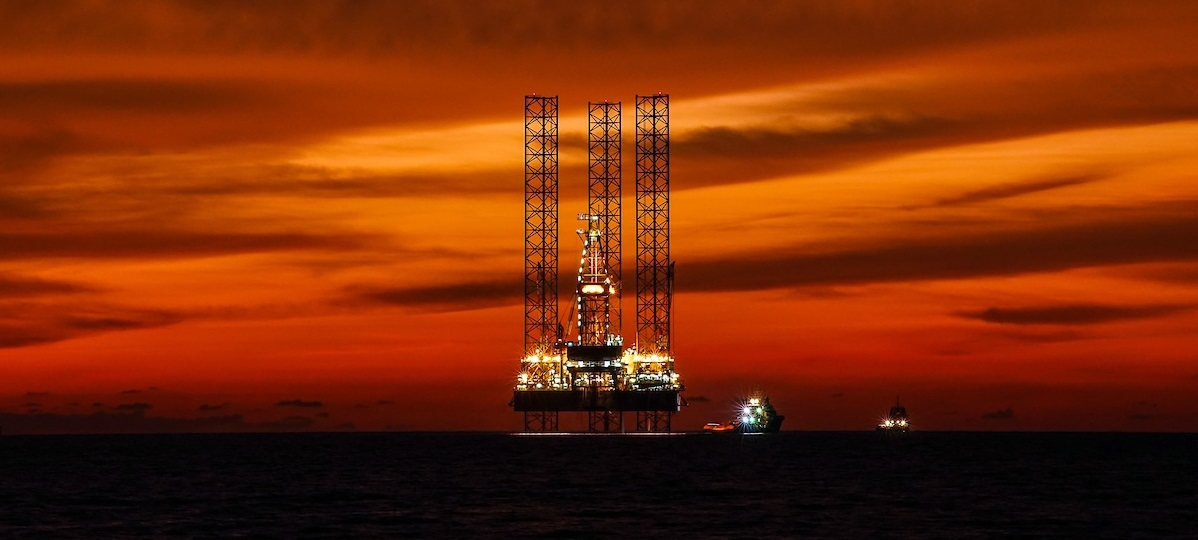

# Introduction

The offshore drilling industry is highly capital-intensive, with day rates for rigs playing a pivotal role in operational costs and profitability. Accurate prediction of these day rates is crucial for optimizing contract negotiations, financial planning, and resource allocation. This study aims to develop a predictive model for offshore rig day rates using historical data obtained from S&P Global. Comprehensive analysis has been done involving univariate and bivariate data exploration, data cleaning, and feature engineering. Multiple machine learning models were evaluated, including Linear Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, and Neural Networks, both with and without hyperparameter tuning & Ensemble Model. The models were trained and tested using a standard train-test split approach, and their performances were compared using metrics such as Mean Squared Error (MSE) and R² Score.  Another important aspect of project is to interpret model dependencies offering valuable insights into the factors influencing rig day rates. This model can serve as a critical tool for industry stakeholders to navigate the volatile offshore drilling market effectively.

# Importing Dependencies, Data Loading and Understanding

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None)
from wordcloud import WordCloud
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import re
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import keras_tuner as kt

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
#loading data
rig_df = pd.read_excel("/content/drive/MyDrive/Rig Analysis/Petrodata_Rigs_Fixtures_FixturesReport_20240426_1020.xlsx")

In [204]:
rig_df.head(2)

Operator  Rig Name           Manager        Contractor  \
0                       PEMEX     CME I               CME               CME   
1  Al-Khafji Joint Operations  Delta 22  Arabian Drilling  Arabian Drilling   

  Rig Type Rig Market Category  Rig Water Depth       Region  Country/Area  \
0   Jackup           JU 300-IC              300       Mexico        Mexico   
1   Jackup          JU <250-IC              200  Middle East  Neutral Zone   

  Contract Start Date Contract End Date Contract Description Day Rate  \
0          2023-12-14        2024-12-31             383 days      NaN   
1          2006-04-16        2009-10-30   3 years + 6 months    65000   

  Day Rate Start Fixture Date        Type Day Rate Type Prior Day Rate  \
0     2023-12-14   2023-12-07  New mutual        Mutual          76000   
1     2006-04-16   2006-03-28  New mutual        Mutual          31000   

  Prior Operator Prior Status Jackup Type  Year In Service DP DP Class  \
0          PEMEX     Drilling          IC             2010  N      NaN   
1           AGOC     Drilling          IC             1980  N      NaN   

   BOP WP Max MPD Status        BOP Stacks                 Rig Design  \
0     15000.0  Not known  Single BOP Stack  Friede & Goldman Super M2   
1     10000.0  Not known  Single BOP Stack    Baker Marine BMC-150-IC   

   Quarters Capacity  Leg Length  Cantilever Reach  Crane Capacity  \
0              110.0       411.0              55.0            60.0   
1               84.0       301.0              40.0            40.0   

   Derrick Capacity  Drilling Depth  Total Mud Pumps  Variable Load  \
0         1500000.0         30000.0              3.0         4500.0   
1         1300000.0         20000.0              3.0         2596.0   

  Auto Pipe Handling Competitive Conventional Mooring Dual Activity  \
0                NaN           Y                    Y             N   
1                NaN           Y                  NaN             N   

  Special Survey Due Build Country/Area                    Build Yard  \
0         2025-02-03                UAE  Maritime Industrial Services   
1         2013-03-25          Singapore            Promet Private Ltd   

  Construction Status Contract Type      IMO  Drawworks HP  \
0           Delivered      Standard  8770807        3000.0   
1           Delivered      Standard  8753134        2000.0   

  Emissions Monitoring Software Green Class Notation Hybrid Power Hull Number  \
0                             N                  NaN            N         109   
1                             N                  NaN            N       P1071   

   Tender Hull Type  Total BOP Rams  RigID  
0               NaN             NaN   2139  
1               NaN             3.0    810

In [205]:
rig_df.shape

(12236, 54)

In [206]:
rig_df.describe()

Rig Water Depth            Contract Start Date  \
count     12236.000000                          12236   
mean       2170.149886  2012-09-26 18:39:18.417783552   
min          66.000000            2004-04-24 00:00:00   
25%         280.000000            2007-08-08 00:00:00   
50%         375.000000            2011-11-20 00:00:00   
75%        1788.000000            2017-07-16 12:00:00   
max       12000.000000            2026-05-28 00:00:00   
std        3361.674360                            NaN   

                   Contract End Date                 Day Rate Start  \
count                          12236                          12236   
mean   2013-10-22 03:36:18.358940928  2012-11-21 20:29:48.819875840   
min              2004-05-18 00:00:00            2004-04-24 00:00:00   
25%              2008-06-27 12:00:00            2007-10-01 00:00:00   
50%              2012-12-31 00:00:00            2012-01-19 00:00:00   
75%              2018-10-10 00:00:00            2017-10-10 18:00:00   
max              2038-12-17 00:00:00            2028-09-15 00:00:00   
std                              NaN                            NaN   

                        Fixture Date  Year In Service    BOP WP Max  \
count                          12236     12236.000000  12002.000000   
mean   2012-04-15 14:01:05.903890176      1991.825924  12328.778537   
min              2004-04-26 00:00:00      1958.000000   5000.000000   
25%              2006-12-31 00:00:00      1980.000000  10000.000000   
50%              2011-06-30 00:00:00      1983.000000  10000.000000   
75%              2017-03-29 00:00:00      2008.000000  15000.000000   
max              2024-04-25 00:00:00      2024.000000  20000.000000   
std                              NaN        15.113512   2616.514758   

       Quarters Capacity   Leg Length  Cantilever Reach  Crane Capacity  \
count       12189.000000  7976.000000       7310.000000    12058.000000   
mean          111.024612   417.820211         55.602189       62.791342   
min            30.000000   134.000000         25.000000       15.000000   
25%            86.000000   343.000000         45.000000       47.000000   
50%           105.000000   417.000000         50.000000       55.000000   
75%           122.000000   506.000000         70.000000       75.000000   
max           300.000000   713.000000        110.000000      300.000000   
std            38.270050   105.872255         15.268712       30.038988   

       Derrick Capacity  Drilling Depth  Total Mud Pumps  Variable Load  \
count      1.203800e+04    12166.000000     12120.000000   12007.000000   
mean       1.479901e+06    27323.162502         2.907508    5335.120430   
min        3.000000e+05        0.000000         1.000000     235.000000   
25%        1.100000e+06    25000.000000         2.000000    2250.000000   
50%        1.400000e+06    25000.000000         3.000000    3559.000000   
75%        1.600000e+06    30000.000000         3.000000    5000.000000   
max        3.400000e+06    50000.000000         7.000000   29762.000000   
std        4.510810e+05     6030.322945         0.734120    5475.170708   

                  Special Survey Due           IMO  Drawworks HP  \
count                          12057  1.223600e+04  11619.000000   
mean   2021-07-29 17:59:11.629758720  8.859668e+06   3228.686118   
min              1984-12-15 00:00:00  5.171189e+06    650.000000   
25%              2017-09-30 00:00:00  8.752594e+06   2000.000000   
50%              2022-10-31 00:00:00  8.755546e+06   3000.000000   
75%              2025-02-05 00:00:00  8.769614e+06   3000.000000   
max              2029-09-30 00:00:00  9.914216e+06  13800.000000   
std                              NaN  4.172003e+05   1649.081484   

       Tender Hull Type  Total BOP Rams         RigID  
count               0.0    11722.000000  12236.000000  
mean                NaN        4.256611   1022.889506  
min                 NaN        1.000000      1.000000  
25%                 NaN 

In [207]:
#Lets check type of variables

cols=rig_df.columns

In [208]:
# # Lets get a basic idea of data
# for col in cols:
#   print("Distribution of feature '%s' is:" % col)
#   print(rig_df[col].value_counts().head(10))
#   print(" ")
#   print("No. of unique enteries are", rig_df[col].value_counts().shape[0])
#   print("***************************************************")
#   print(" ")

# Data Cleaning & Data Visulization

In [209]:
rig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12236 entries, 0 to 12235
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Operator                       12236 non-null  object        
 1   Rig Name                       12236 non-null  object        
 2   Manager                        12236 non-null  object        
 3   Contractor                     12236 non-null  object        
 4   Rig Type                       12236 non-null  object        
 5   Rig Market Category            12236 non-null  object        
 6   Rig Water Depth                12236 non-null  int64         
 7   Region                         12236 non-null  object        
 8   Country/Area                   12236 non-null  object        
 9   Contract Start Date            12236 non-null  datetime64[ns]
 10  Contract End Date              12236 non-null  datetime64[ns]
 11  Contract Descri

- Day Rate is our target variable
- There are 53 no. of features avaiable in Dataset
- There are many features with missing value like `Prior Status`, `Prior Day Rate`, `Prior Operator`, `Jackup Type`, `DP Class`, `Rig Design`, `Quarters Capacity`, `Leg Length`, `Cantilever Reach` , `Crane Capacity`, `Derrick Capacity`, `Drilling Depth`, `Auto Pipe Handling`, `Conventional Mooring`, `Emissions Monitoring Software`, `Green Class Notation`, `Tender Hull Type`
- We will treat the missing value as we fully understand data if required

## Univariate Analysis and Data Manipulation

1. Day Rate

Target variable is Day Rate

In [210]:
rig_df["Day Rate"].value_counts(dropna=False).head()

Day Rate
NaN        2361
Private     847
60000       189
65000       189
75000       180
Name: count, dtype: int64

We hase to dopn NaN and private data points

In [211]:
#Droping Day rate rowns having Private day rates

rig_df = rig_df[~(rig_df["Day Rate"] == "Private")]

In [212]:
#Dropping nan values

rig_df = rig_df.dropna(subset=["Day Rate"])

In [213]:
rig_df["Day Rate"] = rig_df["Day Rate"].astype("int64")

In [214]:
#dropping day rates with zero day rate

rig_df= rig_df[~(rig_df["Day Rate"] == 0)]

In [215]:
rig_df.shape

(9025, 54)

In [216]:
print("No. of data points lost =", (12236-9025))

No. of data points lost = 3211


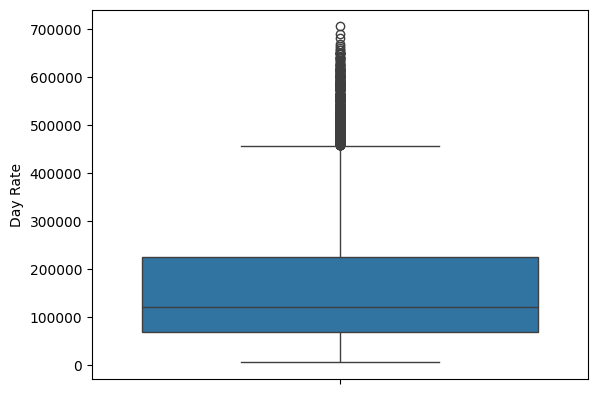

In [217]:
sns.boxplot(rig_df["Day Rate"])
plt.xticks(rotation=90)
plt.show()

In [218]:
rig_df["Day Rate"].describe()

count      9025.000000
mean     170671.789141
std      135882.744579
min        6500.000000
25%       70000.000000
50%      122000.000000
75%      225000.000000
max      706026.000000
Name: Day Rate, dtype: float64

As seen above there is a huge variation in Day rates

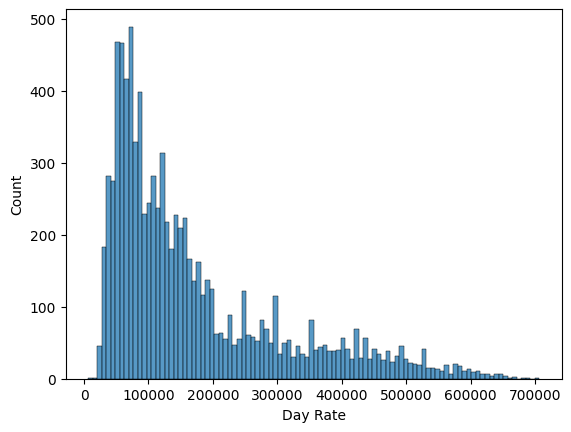

In [219]:
#Sale price is our dependent/target variable
#Lets check distribution of sales
sns.histplot(rig_df['Day Rate'], bins=100)
plt.show()

As we can distribution is highly right skewed

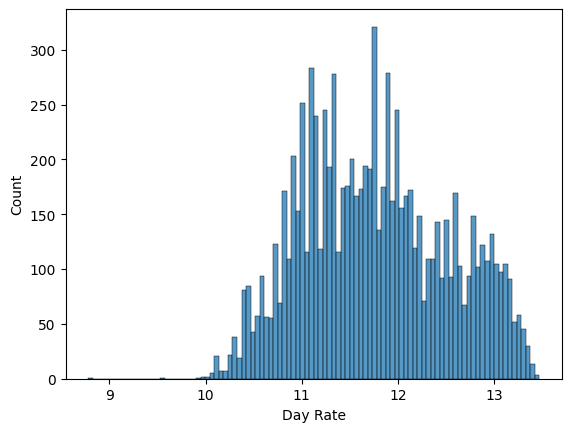

In [220]:
#Lets log transform our SalePrice as sales data is

sns.histplot(np.log(rig_df['Day Rate']), bins=100)
plt.show()


As seen above after log transformation data is now more bell shaped/Guassian distribution.

2. Operator

In [221]:
#Top ten operators
print(rig_df["Operator"].value_counts().head(10))
print("No. of unique operators are =",rig_df["Operator"].value_counts().shape[0])

Operator
PEMEX           357
Total           321
Chevron         306
Saudi Aramco    298
Shell           287
Apache          278
Petrobras       265
ADTI            207
BP              204
ExxonMobil      198
Name: count, dtype: int64
No. of unique operators are = 562


3. Rig Name

In [222]:
#Top ten Rig name
print(rig_df["Rig Name"].value_counts().head(10))
print("No. of unique Rig Name  are =",rig_df["Rig Name"].value_counts().shape[0])

Rig Name
Gaea 3            54
Enterprise 150    46
Gaea 4            45
Enterprise 201    45
Enterprise 264    44
Valaris 75        43
ENSCO 90          43
Valaris 87        42
WFD Rig 350       42
Valaris 107       41
Name: count, dtype: int64
No. of unique Rig Name  are = 875


4. Manager

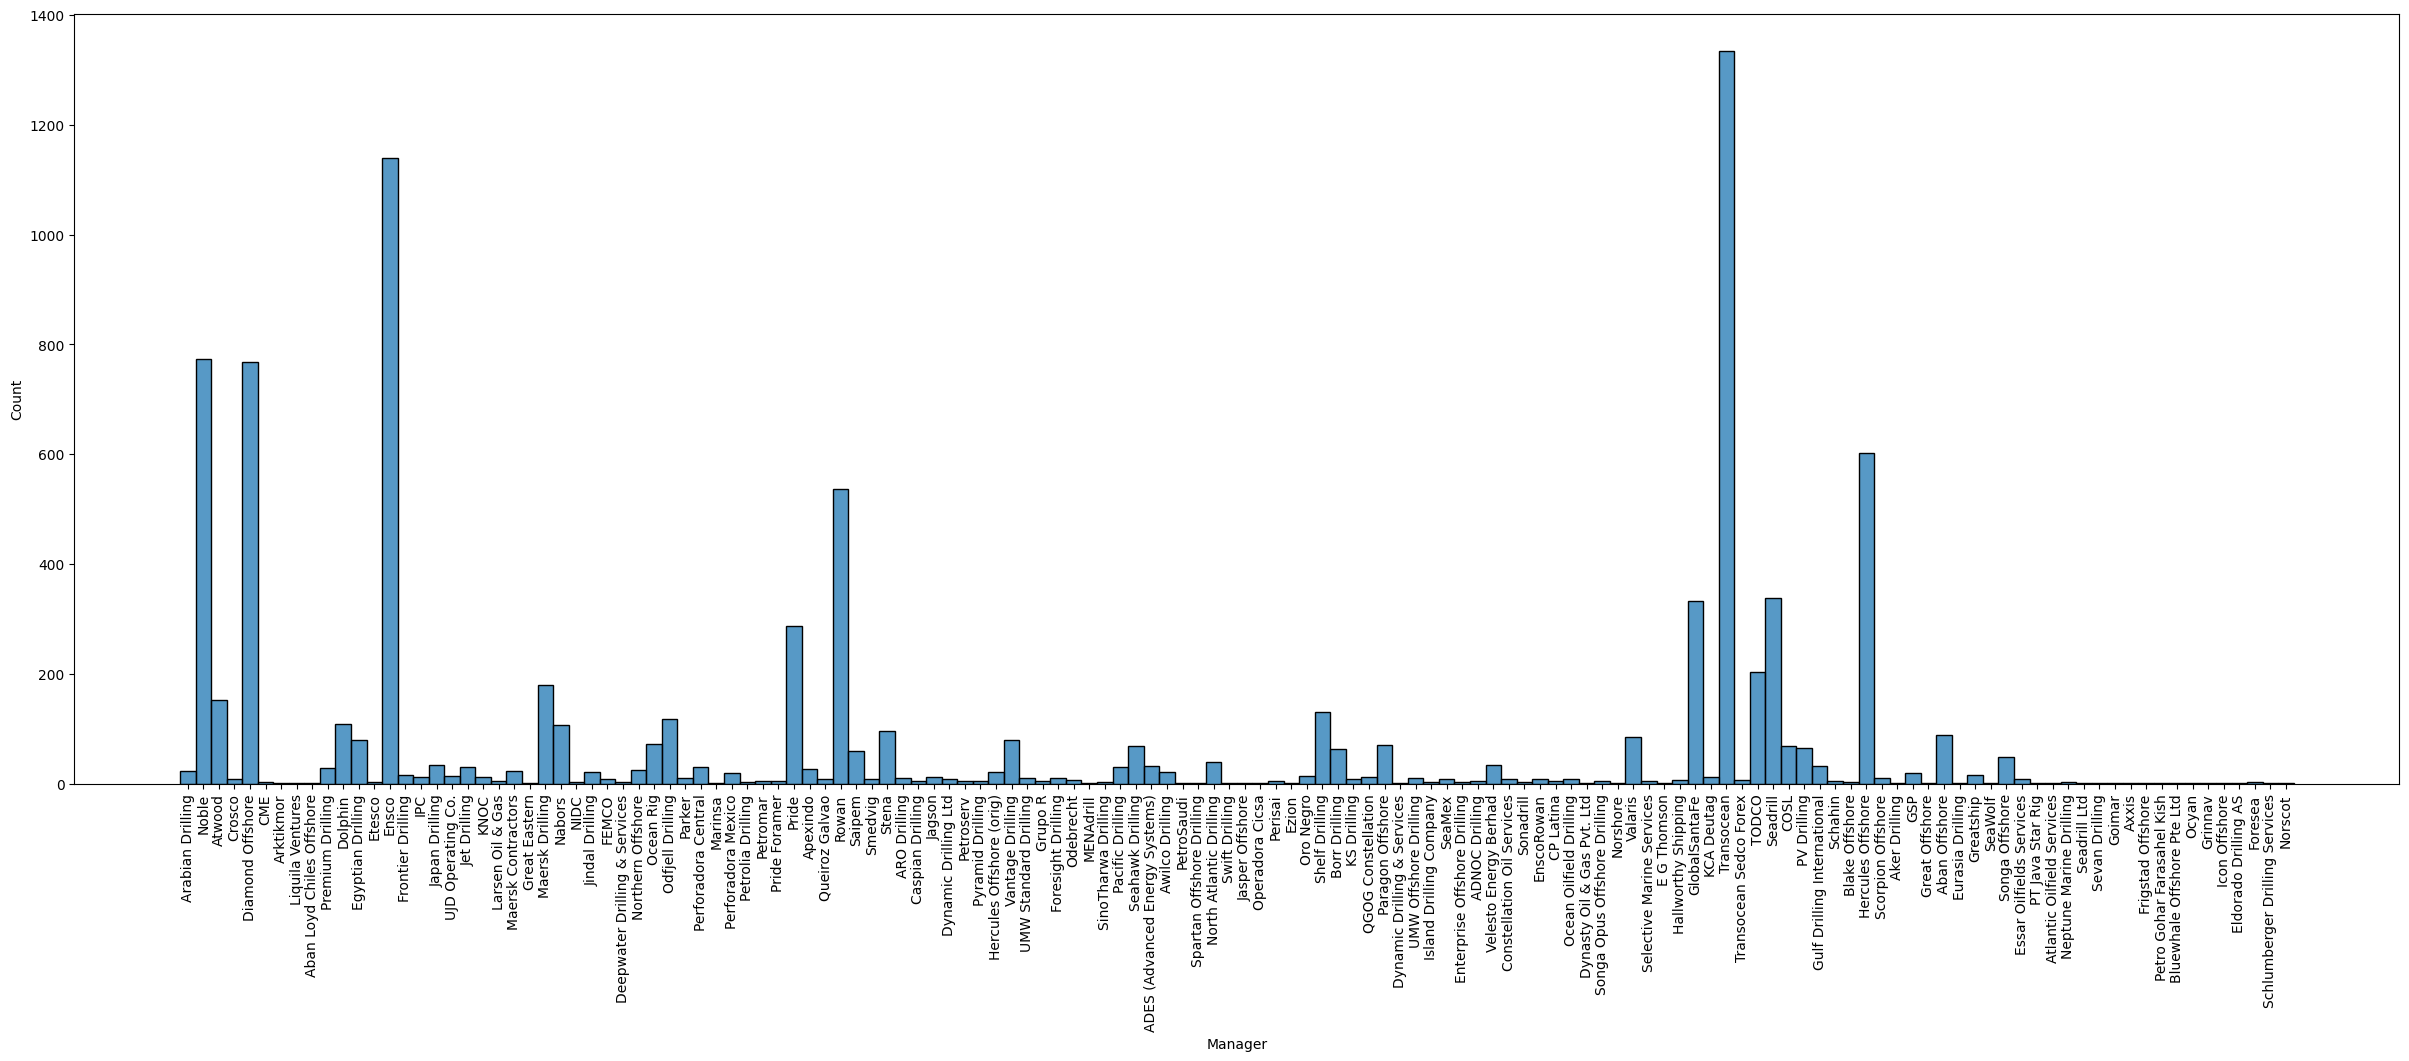

Manager
Transocean           1335
Ensco                1139
Noble                 773
Diamond Offshore      768
Hercules Offshore     603
Rowan                 536
Seadrill              338
GlobalSantaFe         332
Pride                 288
TODCO                 204
Name: count, dtype: int64
No. of unique Manager  are = 136


In [223]:
plt.figure(figsize=(30,10))
sns.histplot(rig_df["Manager"])
plt.xticks(rotation=90)
plt.show()
print(rig_df["Manager"].value_counts().head(10))
print("No. of unique Manager  are =",rig_df["Manager"].value_counts().shape[0])

5. Contractor

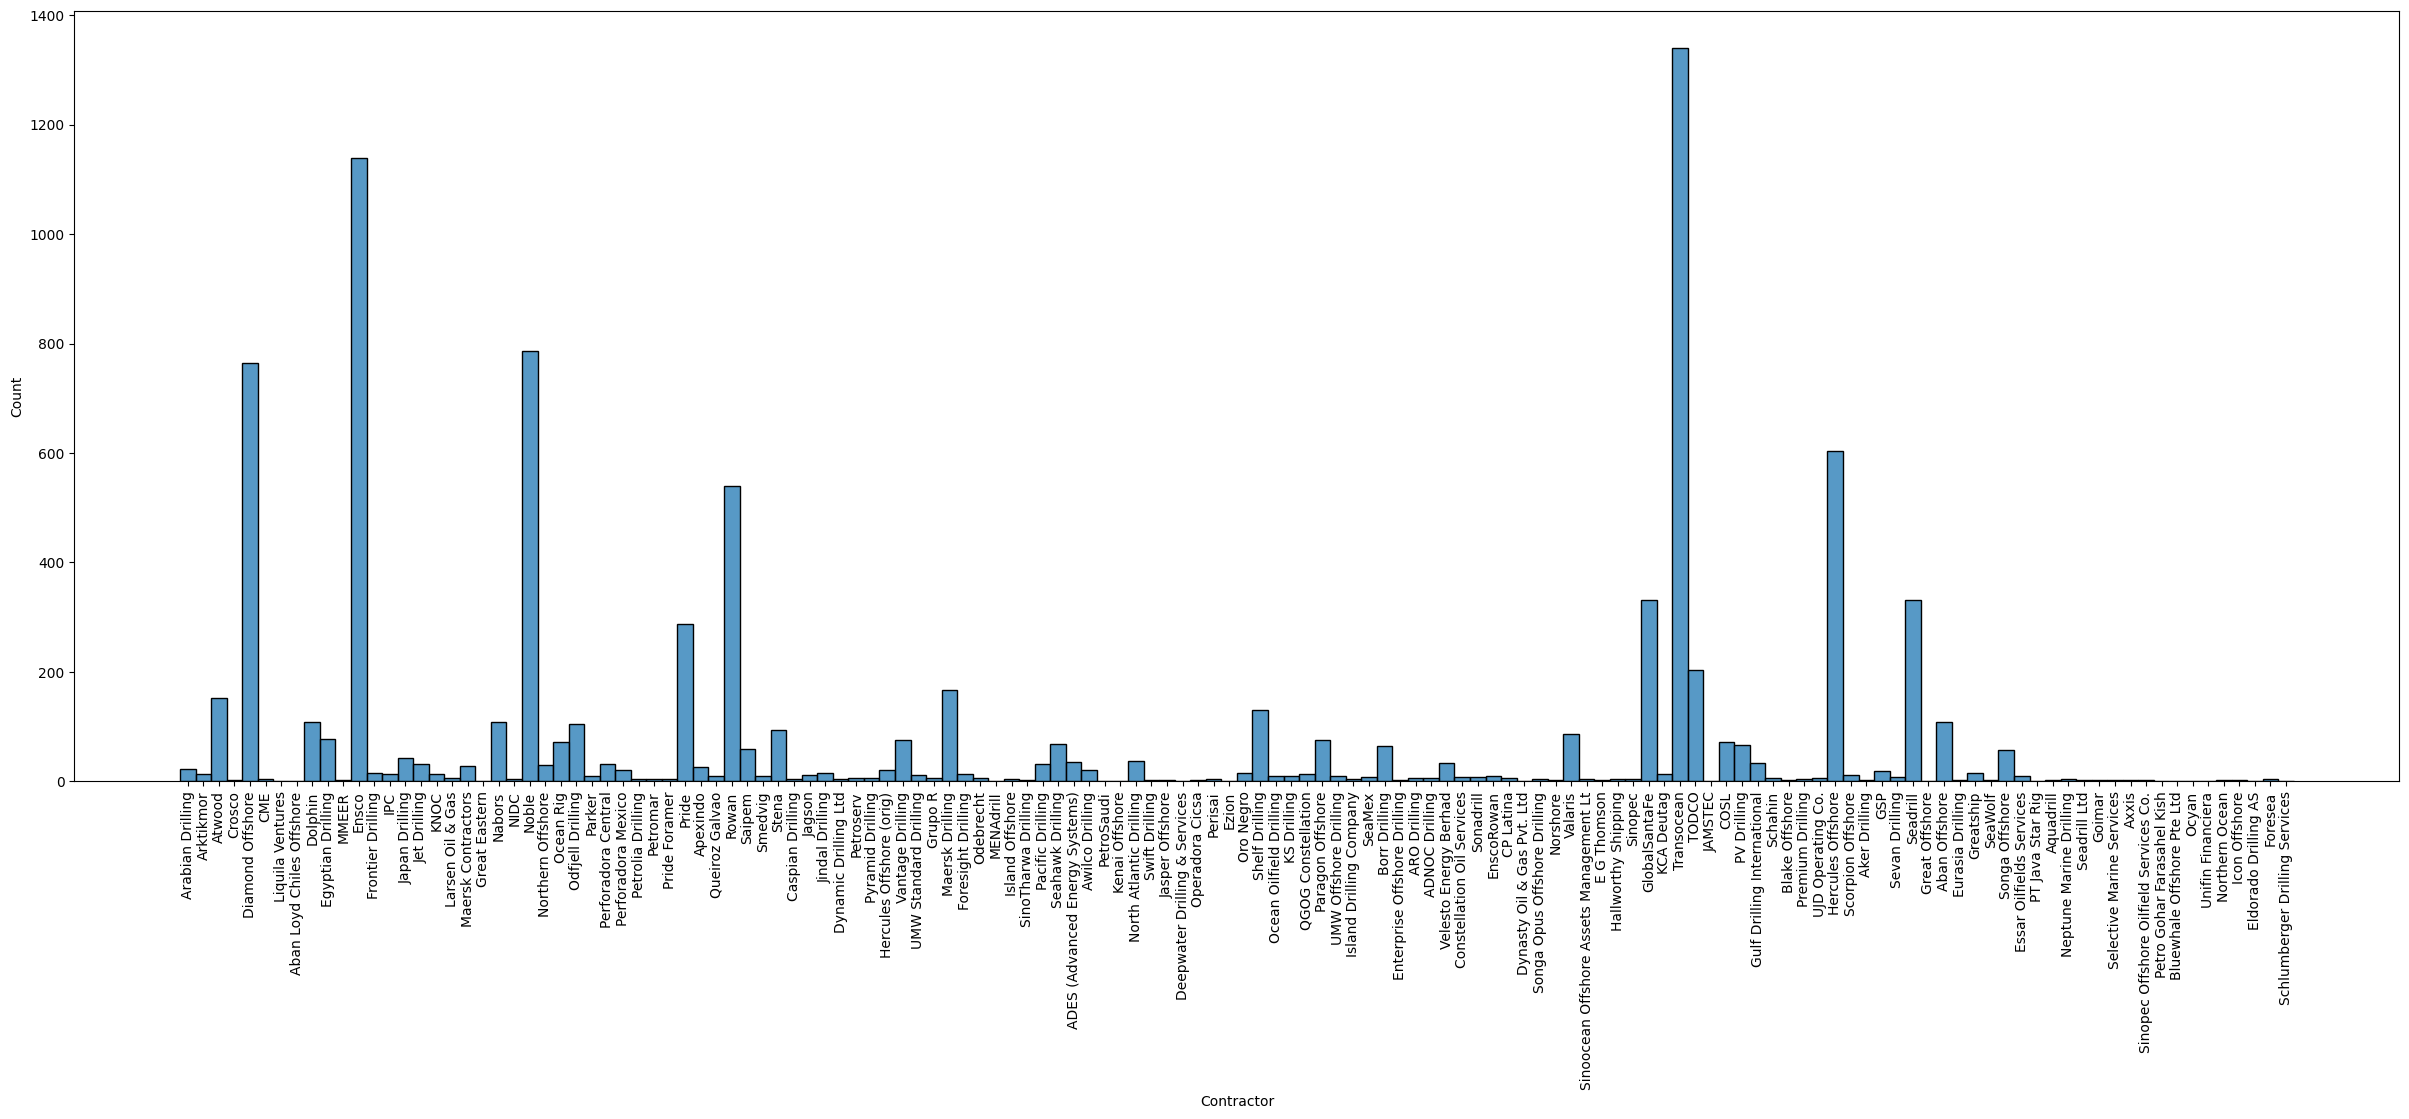

Contractor
Transocean           1340
Ensco                1139
Noble                 787
Diamond Offshore      764
Hercules Offshore     603
Name: count, dtype: int64
No. of unique Contractor  are = 136


In [224]:
plt.figure(figsize=(30,10))
sns.histplot(rig_df["Contractor"])
plt.xticks(rotation=90)
plt.show()
print(rig_df["Contractor"].value_counts().head())
print("No. of unique Contractor  are =",rig_df["Contractor"].value_counts().shape[0])

Same as Rig Manager

6. Rig Type

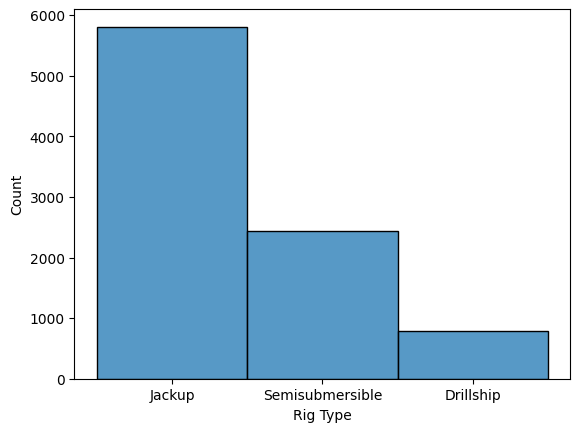

Rig Type
Jackup             5808
Semisubmersible    2436
Drillship           781
Name: count, dtype: int64
No. of unique Rig Type  are = 3


In [225]:
sns.histplot(rig_df["Rig Type"])
plt.show()
print(rig_df["Rig Type"].value_counts().head())
print("No. of unique Rig Type  are =",rig_df["Rig Type"].value_counts().shape[0])

7. Rig Market Category

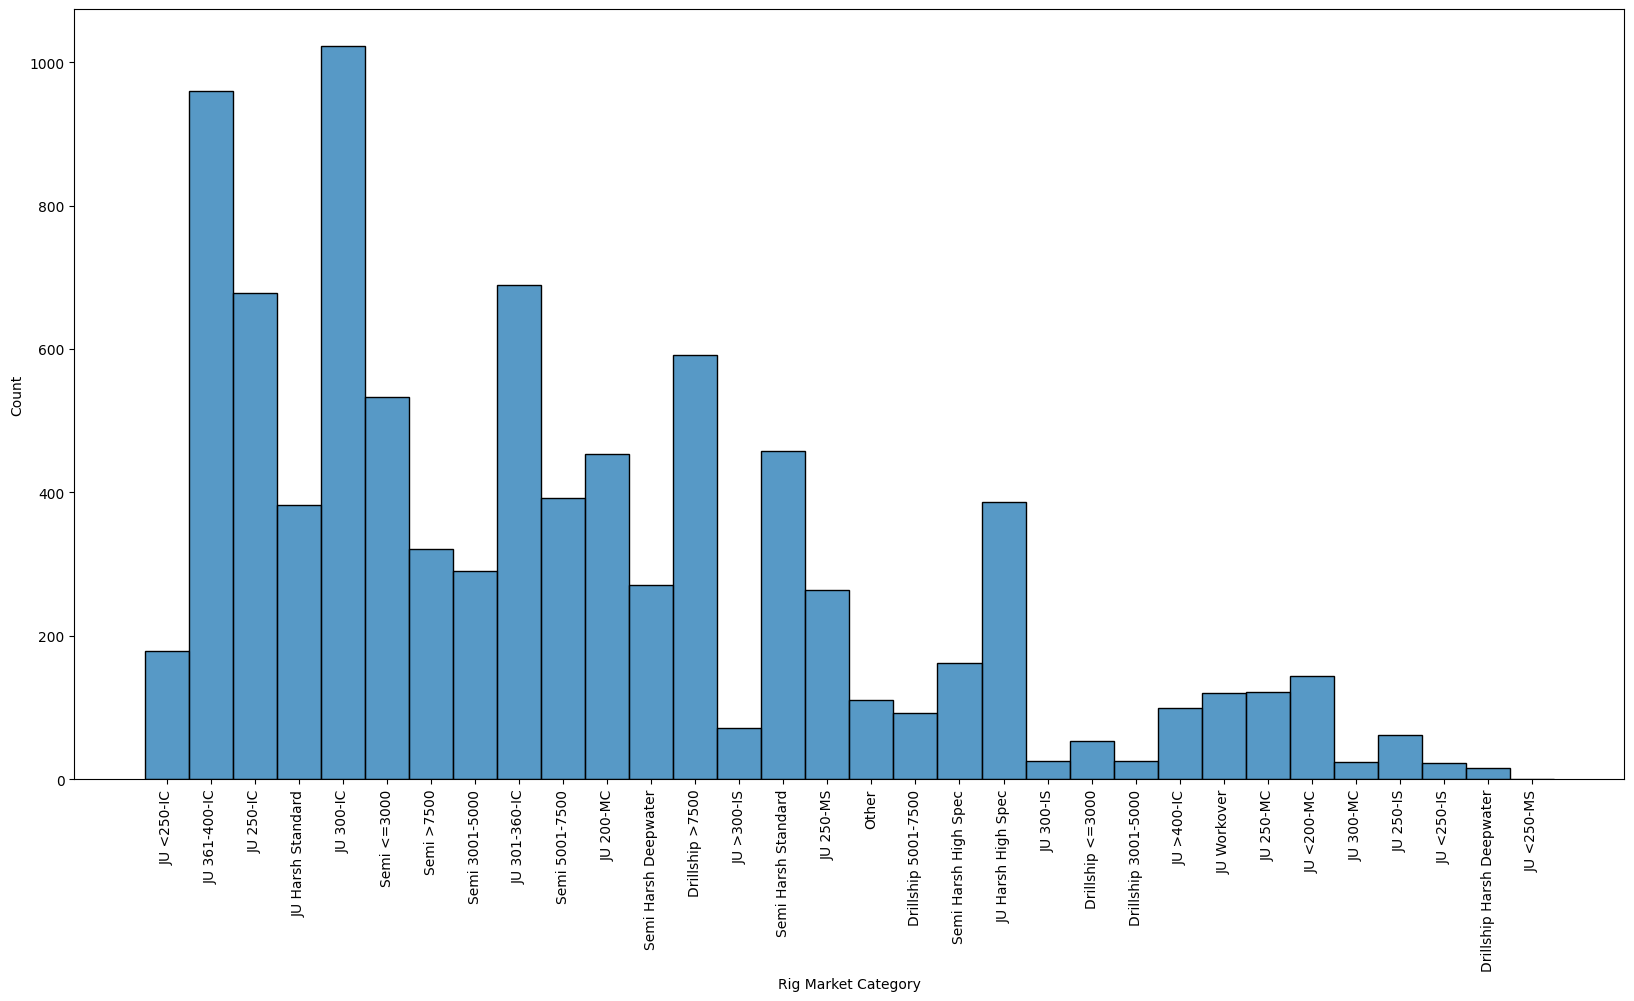

In [226]:
plt.figure(figsize=(20,10))
sns.histplot(rig_df["Rig Market Category"])
plt.xticks(rotation=90)
plt.show()

In [227]:
# Lets check contribution of all the category type in Data
cat_df=pd.DataFrame(rig_df["Rig Market Category"].value_counts()).reset_index()
cat_df["% of cat"] = (cat_df["count"]/(rig_df.shape[0]))*100
cat_df

Rig Market Category  count   % of cat
0                   JU 300-IC   1023  11.335180
1               JU 361-400-IC    960  10.637119
2               JU 301-360-IC    690   7.645429
3                   JU 250-IC    678   7.512465
4             Drillship >7500    592   6.559557
5                 Semi <=3000    533   5.905817
6         Semi Harsh Standard    458   5.074792
7                   JU 200-MC    453   5.019391
8              Semi 5001-7500    393   4.354571
9          JU Harsh High Spec    387   4.288089
10          JU Harsh Standard    382   4.232687
11                 Semi >7500    321   3.556787
12             Semi 3001-5000    291   3.224377
13       Semi Harsh Deepwater    271   3.002770
14                  JU 250-MS    264   2.925208
15                 JU <250-IC    179   1.983380
16       Semi Harsh High Spec    162   1.795014
17                 JU <200-MC    144   1.595568
18                  JU 250-MC    122   1.351801
19                JU Workover    120   1.329640
20                      Other    110   1.218837
21                 JU >400-IC     99   1.096953
22        Drillship 5001-7500     93   1.030471
23                 JU >300-IS     72   0.797784
24                  JU 250-IS     61   0.675900
25           Drillship <=3000     53   0.587258
26                  JU 300-IS     26   0.288089
27        Drillship 3001-5000     25   0.277008
28                  JU 300-MC     24   0.265928
29                 JU <250-IS     22   0.243767
30  Drillship Harsh Deepwater     16   0.177285
31                 JU <250-MS      1   0.011080

 IC = Independent leg and cantilever

 IS = Independent leg and slot

 MC = Mat supported and cantilever

 MS = Mat supported and slot

In [228]:
rig_df.shape

(9025, 54)

In [229]:
#Let us remove  categories with less than 0.5% of total data to reduce sparse categories
cat = ['JU 300-IS','Drillship 3001-5000','JU 300-MC','JU <250-IS','Drillship Harsh Deepwater','JU <250-MS']
rig_df = rig_df[~(rig_df["Rig Market Category"].isin(cat))]

In [230]:
# Lets check now contribution of all the category type in Data
cat_df=pd.DataFrame(rig_df["Rig Market Category"].value_counts()).reset_index()
cat_df["% of cat"] = (cat_df["count"]/(rig_df.shape[0]))*100
cat_df

Rig Market Category  count   % of cat
0              JU 300-IC   1023  11.480193
1          JU 361-400-IC    960  10.773202
2          JU 301-360-IC    690   7.743239
3              JU 250-IC    678   7.608574
4        Drillship >7500    592   6.643474
5            Semi <=3000    533   5.981371
6    Semi Harsh Standard    458   5.139715
7              JU 200-MC    453   5.083605
8         Semi 5001-7500    393   4.410279
9     JU Harsh High Spec    387   4.342947
10     JU Harsh Standard    382   4.286836
11            Semi >7500    321   3.602289
12        Semi 3001-5000    291   3.265627
13  Semi Harsh Deepwater    271   3.041185
14             JU 250-MS    264   2.962630
15            JU <250-IC    179   2.008753
16  Semi Harsh High Spec    162   1.817978
17            JU <200-MC    144   1.615980
18             JU 250-MC    122   1.369094
19           JU Workover    120   1.346650
20                 Other    110   1.234429
21            JU >400-IC     99   1.110986
22   Drillship 5001-7500     93   1.043654
23            JU >300-IS     72   0.807990
24             JU 250-IS     61   0.684547
25      Drillship <=3000     53   0.594771

8. Rig Water Depth

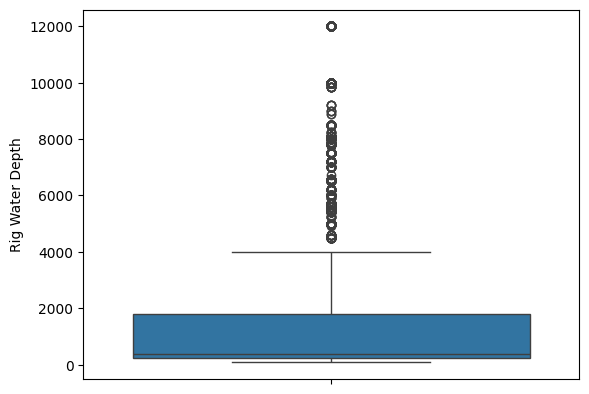

Rig Water Depth
250      1130
300      1123
350       764
10000     753
400       734
Name: count, dtype: int64
No. of unique Rig Water Depth  are = 132


In [231]:
sns.boxplot(rig_df["Rig Water Depth"])
plt.xticks(rotation=90)
plt.show()
print(rig_df["Rig Water Depth"].value_counts().head())
print("No. of unique Rig Water Depth  are =", rig_df["Rig Water Depth"].value_counts().shape[0])

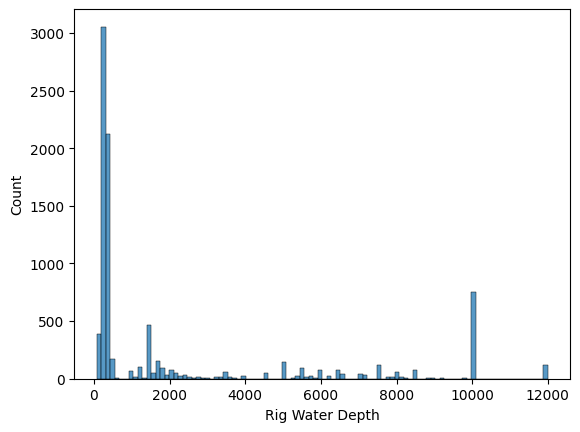

In [232]:
sns.histplot(rig_df['Rig Water Depth'], bins=100)
plt.show()

In [233]:
rig_df['Rig Water Depth'].min()

80

9. Region

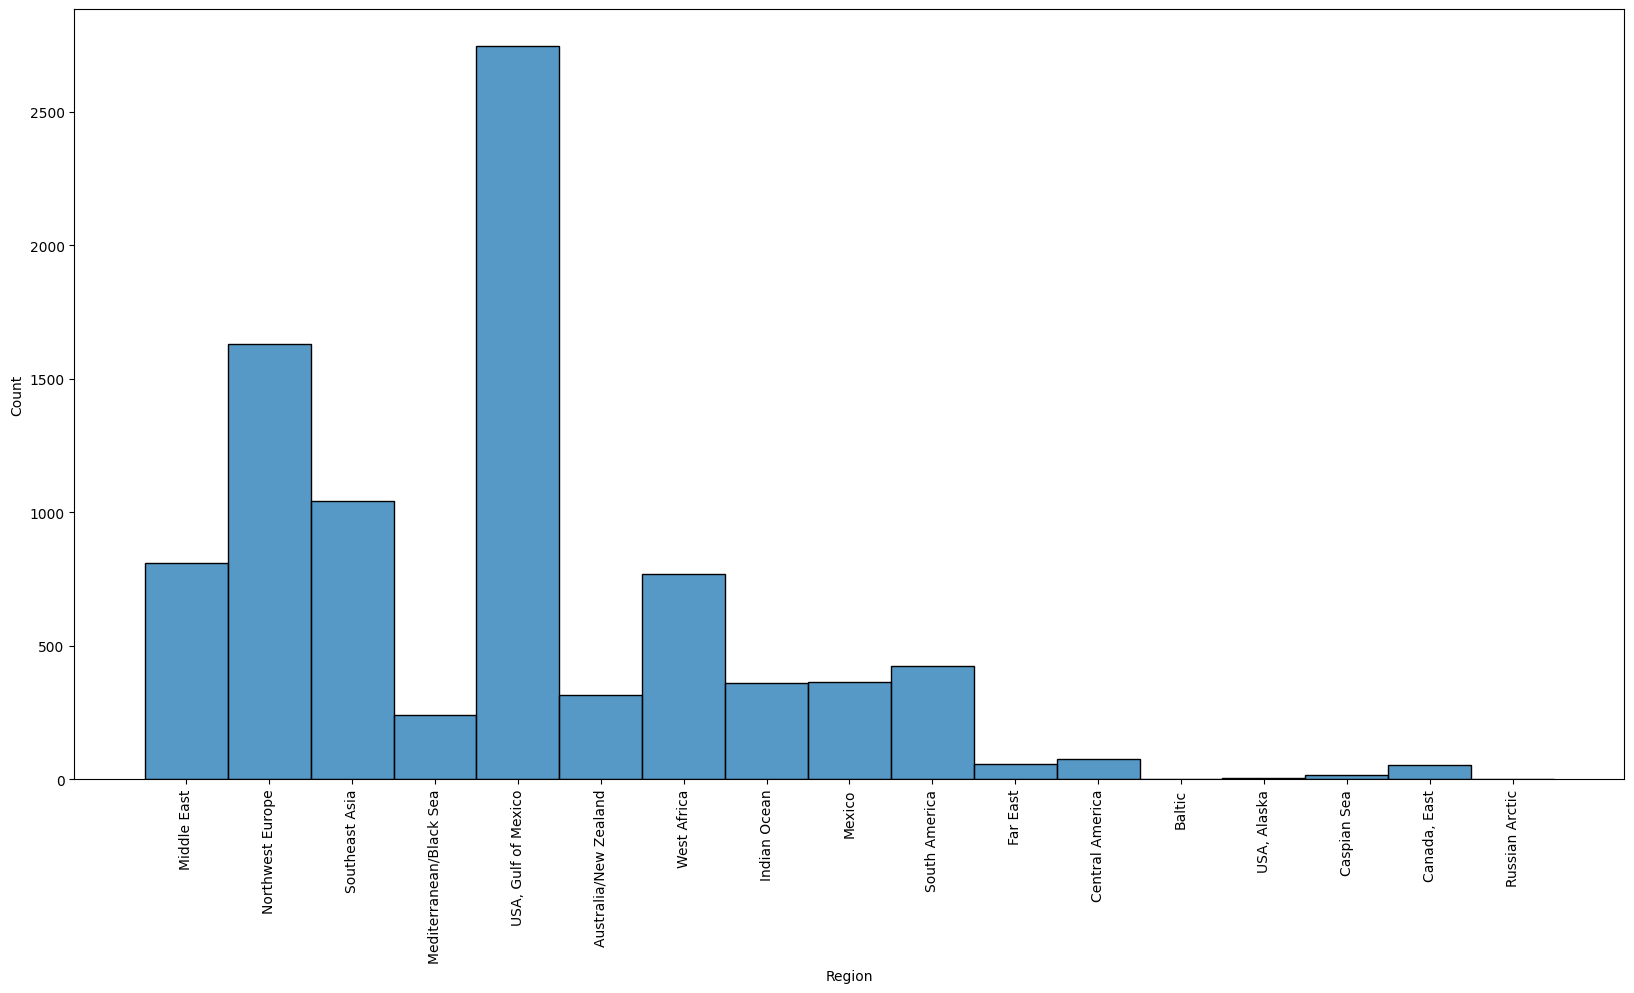

Region
USA, Gulf of Mexico    2747
Northwest Europe       1632
Southeast Asia         1043
Middle East             810
West Africa             767
Name: count, dtype: int64
No. of unique Region  are = 17


In [234]:
plt.figure(figsize=(20,10))
sns.histplot(rig_df["Region"])
plt.xticks(rotation=90)
plt.show()
print(rig_df["Region"].value_counts().head())
print("No. of unique Region  are =",rig_df["Region"].value_counts().shape[0])

In [235]:
# Lets check contribution of all the category type in Data
region_df=pd.DataFrame(rig_df["Region"].value_counts()).reset_index()
region_df["% of cat"] = (cat_df["count"]/(rig_df.shape[0]))*100
region_df.tail(10)

Region  count  % of cat
7              Indian Ocean    361  5.083605
8     Australia/New Zealand    314  4.410279
9   Mediterranean/Black Sea    242  4.342947
10          Central America     76  4.286836
11                 Far East     56  3.602289
12             Canada, East     55  3.265627
13              Caspian Sea     15  3.041185
14              USA, Alaska      4  2.962630
15                   Baltic      1  2.008753
16           Russian Arctic      1  1.817978

In [236]:
#Dropping data with categories less than 3% of total data
rig_df = rig_df[~(rig_df["Region"].isin(["USA, Alaska",'Baltic','Russian Arctic']))]

In [237]:
rig_df.shape

(8905, 54)

In [238]:
print("Data points lost = ", (8605 - 8601) )

Data points lost =  4


10. Country/Area

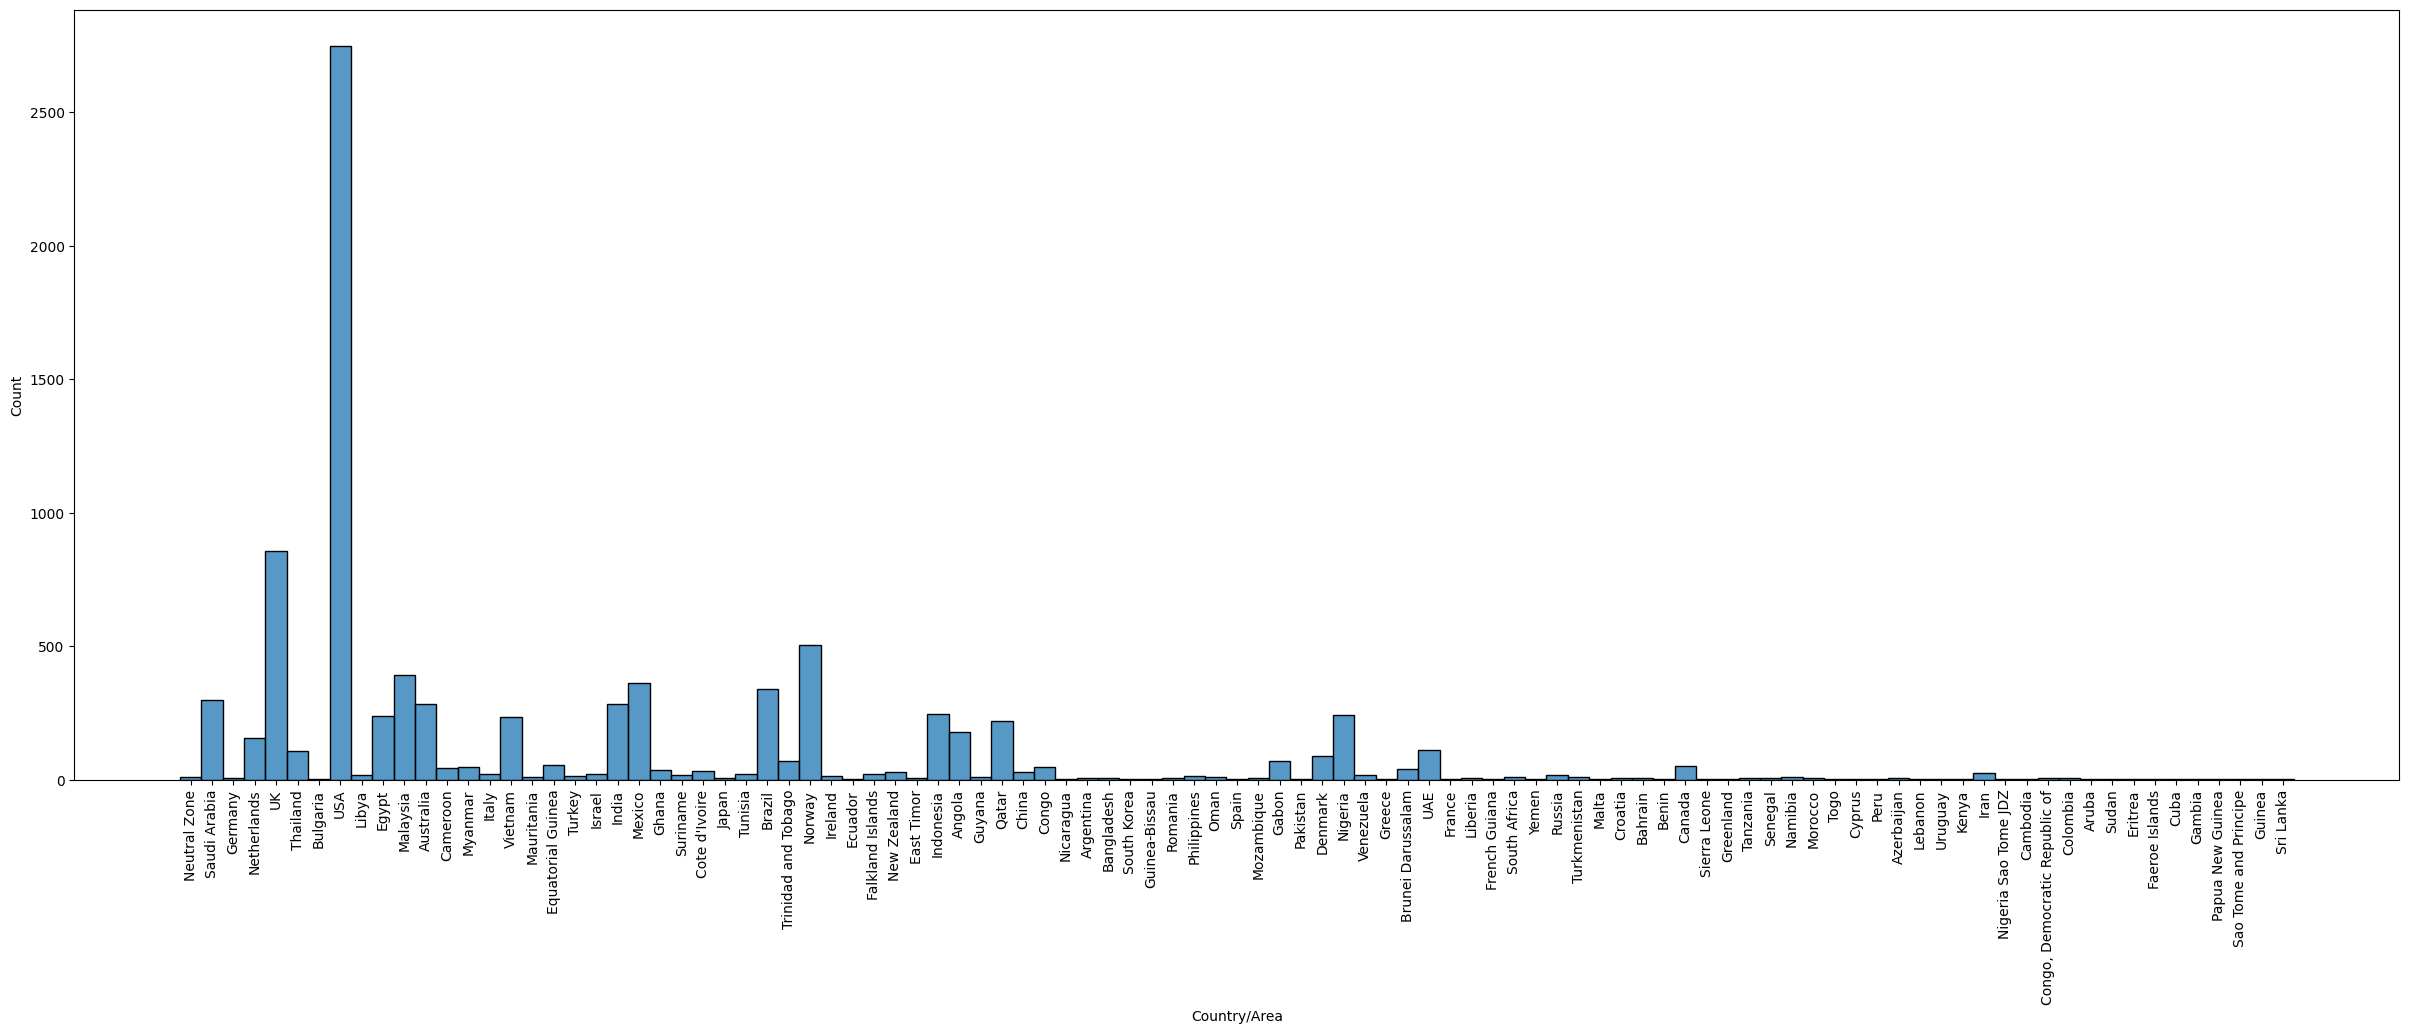

Country/Area
USA         2747
UK           856
Norway       506
Malaysia     392
Mexico       363
Name: count, dtype: int64
No. of unique Country/Area  are = 99


In [239]:
plt.figure(figsize=(30,10))
sns.histplot(rig_df["Country/Area"])
plt.xticks(rotation=90)
plt.show()
print(rig_df["Country/Area"].value_counts().head())
print("No. of unique Country/Area  are =",rig_df["Country/Area"].value_counts().shape[0])

Majority of Data pertains to USA and UK


11. Type

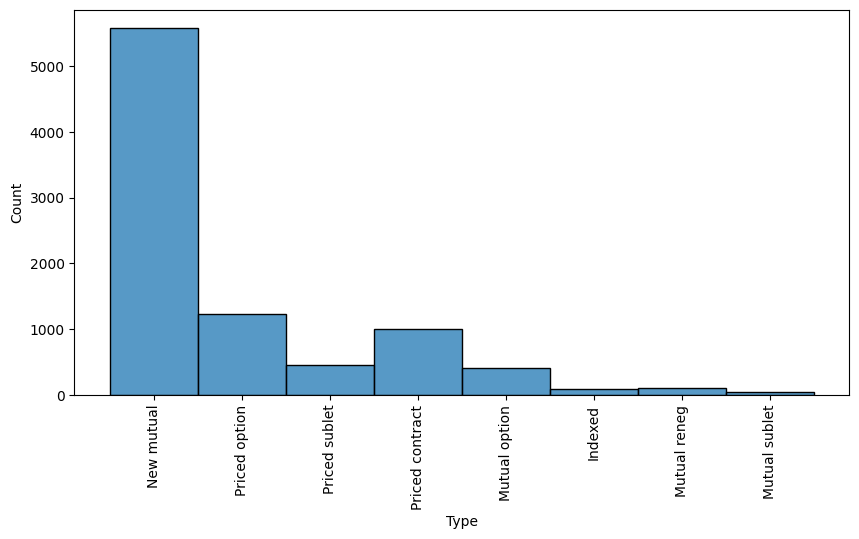

Type
New mutual         5582
Priced option      1222
Priced contract    1004
Priced sublet       452
Mutual option       412
Mutual reneg        102
Indexed              85
Mutual sublet        46
Name: count, dtype: int64
No. of unique Type  are = 8


In [240]:
plt.figure(figsize=(10,5))
sns.histplot(rig_df["Type"])
plt.xticks(rotation=90)
plt.show()
print(rig_df["Type"].value_counts())
print("No. of unique Type  are =",rig_df["Type"].value_counts().shape[0])

12. Day Rate Type

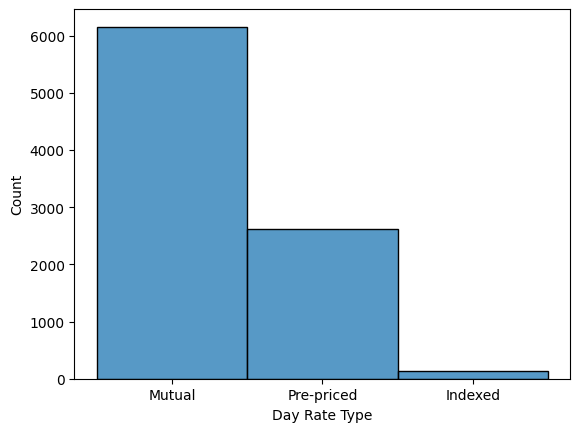

Day Rate Type
Mutual        6156
Pre-priced    2610
Indexed        139
Name: count, dtype: int64
No. of unique Day Rate Type  are = 3


In [241]:
sns.histplot(rig_df["Day Rate Type"])
plt.show()
print(rig_df["Day Rate Type"].value_counts().head())
print("No. of unique Day Rate Type  are =",rig_df["Day Rate Type"].value_counts().shape[0])

In [242]:
#Lets see whether Contract Start Date  is equal to Day Rate Start
#pd.DataFrame(rig_df["Contract Start Date"] < rig_df["Day Rate Start"]).value_counts()

In [243]:
#Lets see whether Contract Start Date  is equal to Fixture Date
#pd.DataFrame(rig_df["Contract Start Date"] > rig_df["Fixture Date"]).value_counts()

In [244]:
#Lets see whether Day Rate Start  is equal to Fixture Date
#pd.DataFrame(rig_df["Day Rate Start"] < rig_df["Fixture Date"]).value_counts()

13. Contract Description

In [245]:
rig_df["Contract Description"].value_counts().head(15)

Contract Description
1 well                     1153
1 well option               522
3 years                     388
2 wells                     362
1-well option               274
1 year                      243
2 years                     239
1 well extension            159
5 years                     132
3 wells                     131
1 year option               130
6 months                    110
1 well sublet                93
3 years + 1 year option      91
1 well + options             74
Name: count, dtype: int64

14. Type of Contract

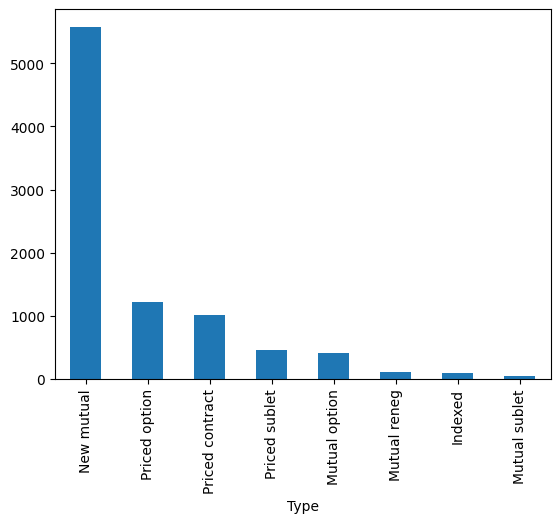

Type
New mutual         5582
Priced option      1222
Priced contract    1004
Priced sublet       452
Mutual option       412
Mutual reneg        102
Indexed              85
Mutual sublet        46
Name: count, dtype: int64


In [246]:
rig_df["Type"].value_counts().plot.bar()
plt.show()
print(rig_df["Type"].value_counts())

15. Day Rate Type

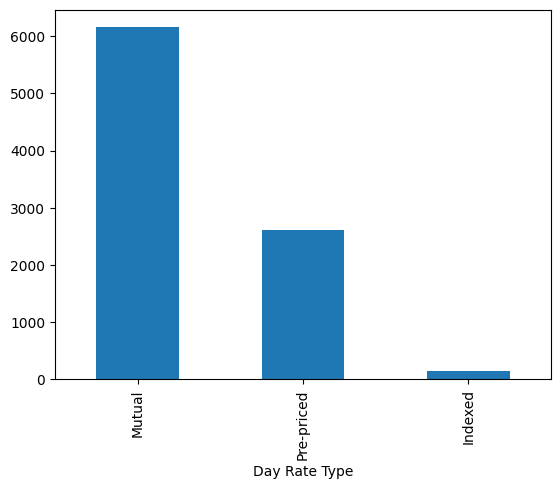

Day Rate Type
Mutual        6156
Pre-priced    2610
Indexed        139
Name: count, dtype: int64


In [247]:
rig_df["Day Rate Type"].value_counts().plot.bar()
plt.show()
print(rig_df["Day Rate Type"].value_counts())

16. Prior Status

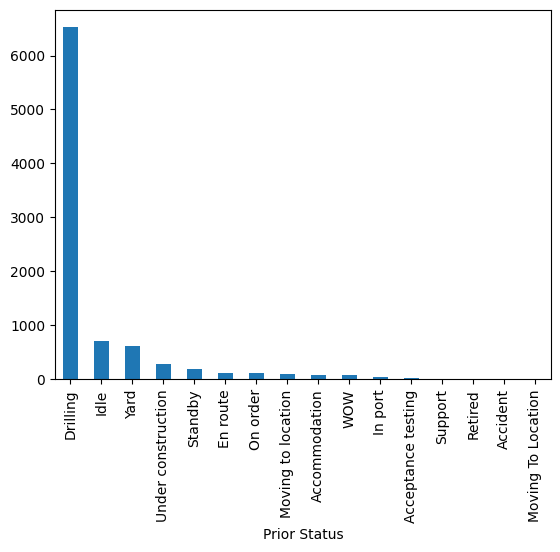

Prior Status
Drilling              6522
Idle                   719
Yard                   626
Under construction     276
Standby                188
En route               118
On order               109
Moving to location      97
Accommodation           86
WOW                     73
In port                 51
Acceptance testing      17
Support                 14
Retired                  2
Accident                 2
Moving To Location       1
Name: count, dtype: int64


In [248]:
rig_df["Prior Status"].value_counts().plot.bar()
plt.show()
print(rig_df["Prior Status"].value_counts())

In [249]:
rig_df.loc[rig_df['Prior Status'] == "Moving To Location", 'Prior Status'] = 'Moving to location'

In [250]:
rig_df = rig_df[~(rig_df['Prior Status'].isin(["Retired","Accident"]))]

In [251]:
print(rig_df["Prior Status"].value_counts())

Prior Status
Drilling              6522
Idle                   719
Yard                   626
Under construction     276
Standby                188
En route               118
On order               109
Moving to location      98
Accommodation           86
WOW                     73
In port                 51
Acceptance testing      17
Support                 14
Name: count, dtype: int64


In [252]:
num_cols_ =['BOP WP Max','Quarters Capacity','Leg Length','Cantilever Reach','Crane Capacity','Derrick Capacity','Drilling Depth','Variable Load',
            'Drawworks HP']

CPU times: user 1.23 s, sys: 78.1 ms, total: 1.31 s
Wall time: 1.98 s


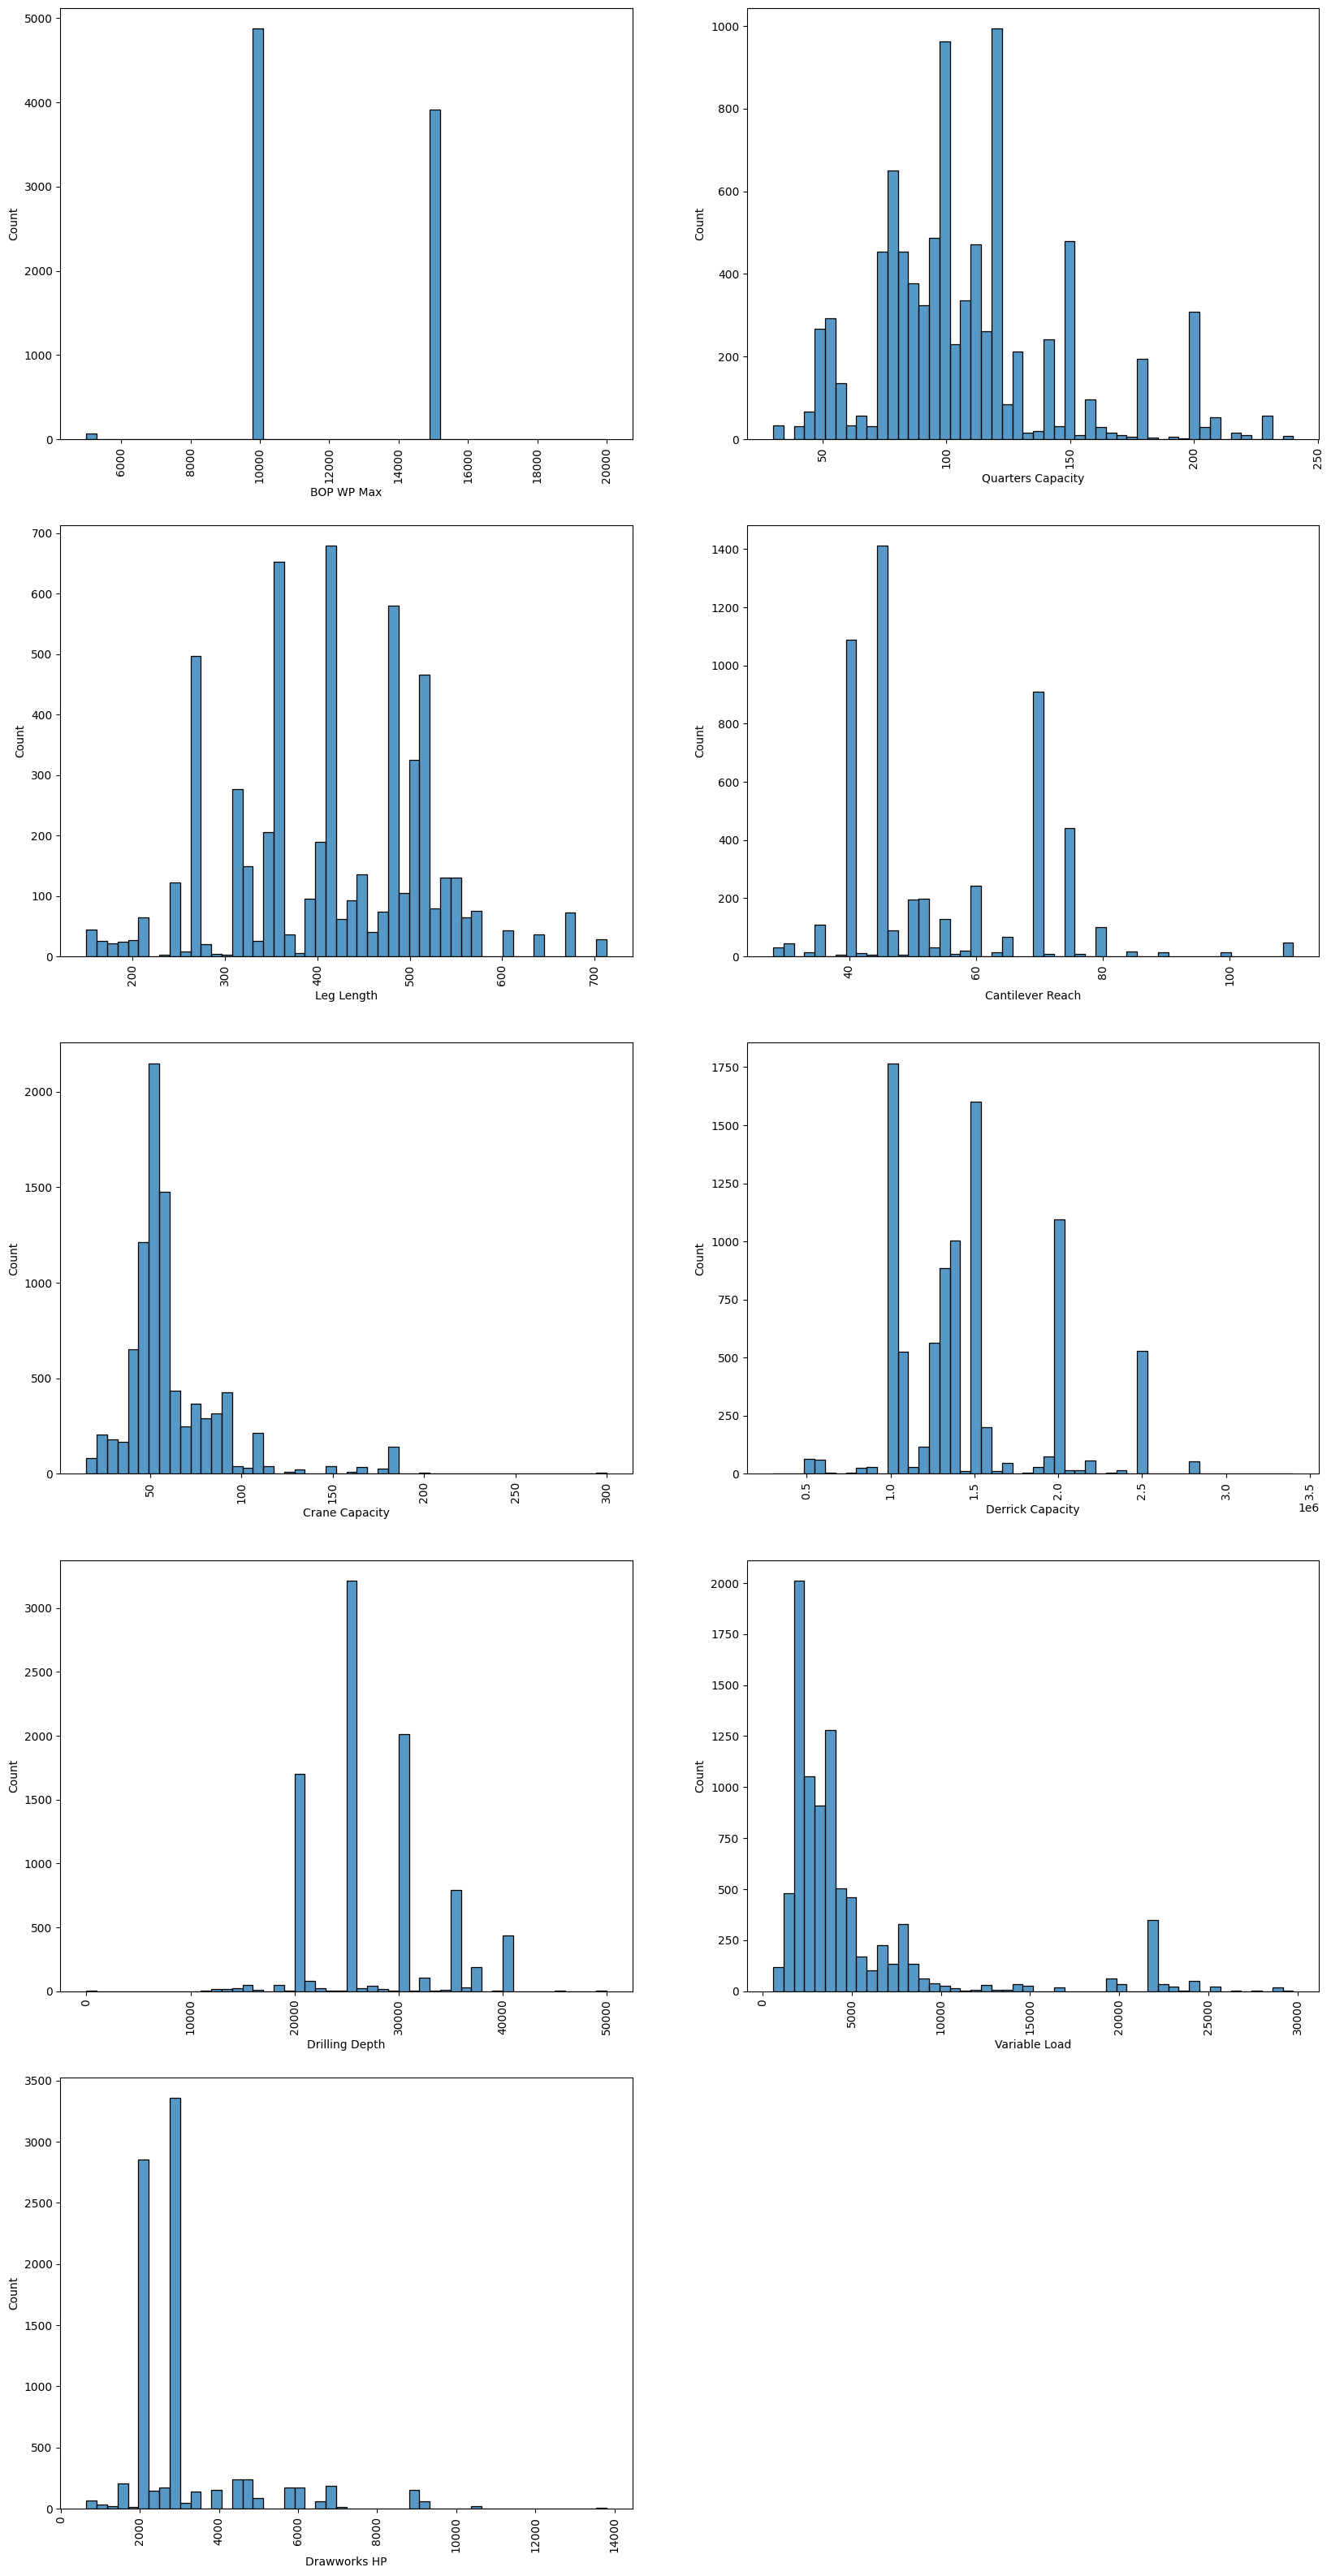

In [253]:
%%time
plt.subplots(figsize=[20,40])
k=1
for col in num_cols_:
  plt.subplot(int(len(num_cols_)/2)+1,2,k)
  sns.histplot(data=rig_df, x=col, bins = 50)
  plt.xticks(rotation=90)
  k=k+1

In [254]:

cat_cols_ =["DP", 'DP Class', 'MPD Status', 'BOP Stacks', 'Total Mud Pumps',
        'Auto Pipe Handling', 'Competitive', 'Conventional Mooring', 'Dual Activity',
         'Construction Status', 'Contract Type', 'Emissions Monitoring Software',
        'Green Class Notation', 'Hybrid Power', 'Total BOP Rams']

CPU times: user 1.25 s, sys: 31.5 ms, total: 1.28 s
Wall time: 1.46 s


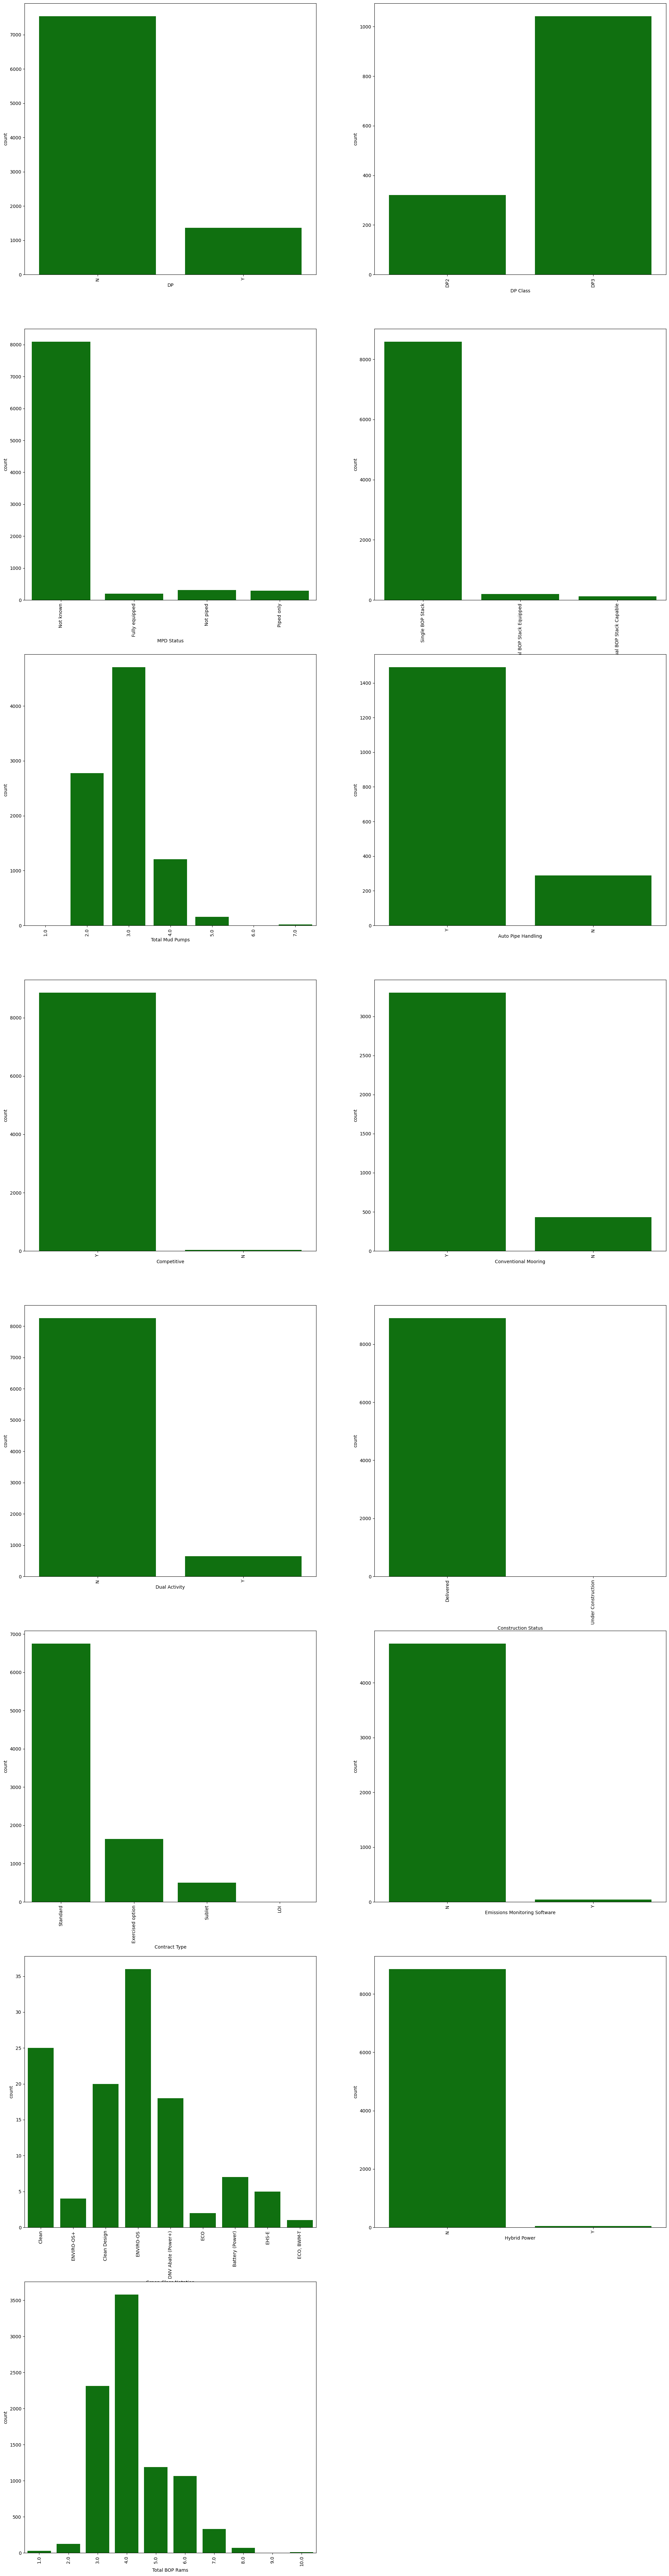

In [255]:
%%time
plt.subplots(figsize=[25,100])
k=1
for col in cat_cols_:
  plt.subplot(int(len(cat_cols_)/2)+1,2,k)
  sns.countplot(data=rig_df, x=col, color = 'green')
  plt.xticks(rotation=90)
  k=k+1

# Feature Engineering

1. Lets us add new feature Contract duration using Contract start dat and end date

In [256]:
rig_df["Contract_duration"]= rig_df["Contract End Date"] - rig_df["Contract Start Date"]
rig_df["Contract_duration"] = rig_df["Contract_duration"].dt.days

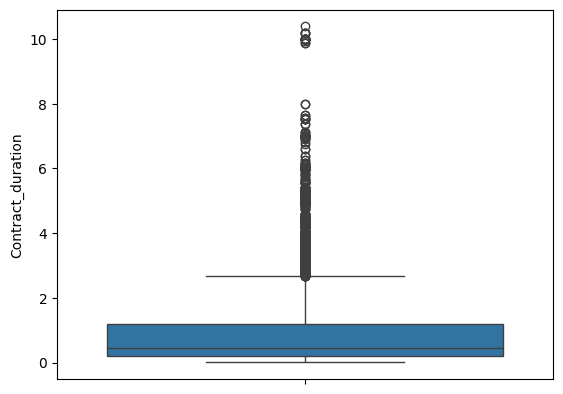

In [257]:
sns.boxplot(rig_df["Contract_duration"]/365)
plt.xticks(rotation=90)
plt.show()

In [258]:
rig_df["Contract_duration"].describe()

count    8901.000000
mean      370.476463
std       485.352452
min         2.000000
25%        68.000000
50%       162.000000
75%       430.000000
max      3792.000000
Name: Contract_duration, dtype: float64

In [259]:
pd.DataFrame(rig_df.groupby(["Contract Description", "Contract_duration"])['Contract_duration'].count()).head(20)

Contract_duration
Contract Description                               Contract_duration                   
 1 well option                                     21                                 1
                                                   39                                 1
 2 wells + 2 x 1 well options                      68                                 1
 2 wells sublet                                    47                                 1
 2 workovers and interventions                     90                                 1
 2 years                                           762                                1
 3 wells                                           46                                 1
 5 years + 2 x 1-year options                      1825                               1
(1 well + 1 sidetrack) + (1 workover OR 1 well ... 33                                 1
1  well                                            89                                 1
1  well + 2  x 1-well options                      36                                 1
1 + 1 wells                                        28                                 1
1 + 1 years                                        730                                1
1 -year option                                     138                                1
1 HPHT well                                        122                                1
                                                   138                                1
                                                   143                                1
                                                   196                                1
                                                   198                                1
1 HPHT well (Oswig) + 1 optional exploration we... 71                                 1

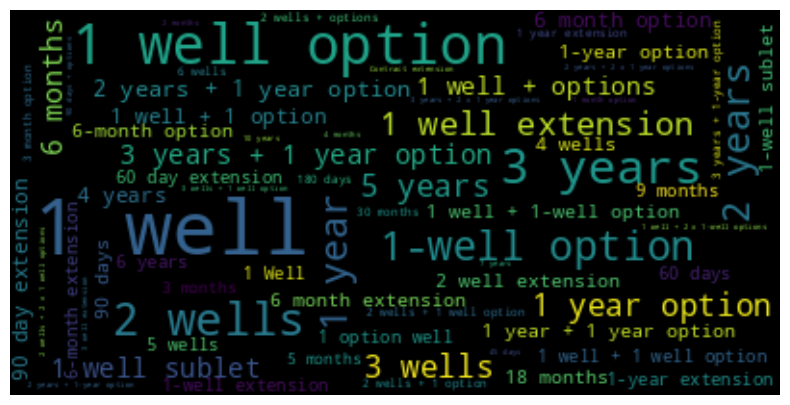

In [260]:
# create word clout for Contract Description column

# Create a dictionary of words and their frequencies
words = rig_df['Contract Description'].value_counts().to_dict()

# Create a word cloud object
wc = WordCloud(background_color="black", max_words=200, max_font_size=40)

# Generate the word cloud
wc.generate_from_frequencies(words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

2. Let us import monthly Crude Futures price

Source: https://in.investing.com/commodities/crude-oil-historical-data

In [261]:
crude_df=pd.read_excel("/content/drive/MyDrive/Rig Analysis/Crude Futures Prices.xlsx")
crude_df.head()

Date  Price   Open   High    Low   Volume    Chg%
0  Apr 26, 2024  83.85  83.81  84.46  83.35        0  0.0034
1  Apr 25, 2024  83.57  82.83  83.83  81.99  314.12K  0.0092
2  Apr 24, 2024  82.81  83.40  83.71  82.44  329.08K -0.0066
3  Apr 23, 2024  83.36  82.13  83.43  80.88  355.81K  0.0062
4  Apr 22, 2024  82.85  83.05  83.35  81.85   30.21K -0.0035

In [262]:
# Using dataframe crude_df Change Date column to date time format

crude_df['Date'] = pd.to_datetime(crude_df['Date'])

In [263]:
crude_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6973 entries, 0 to 6972
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6973 non-null   datetime64[ns]
 1   Price   6973 non-null   float64       
 2   Open    6973 non-null   float64       
 3   High    6973 non-null   float64       
 4   Low     6973 non-null   float64       
 5   Volume  6973 non-null   object        
 6   Chg%    6973 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 381.5+ KB


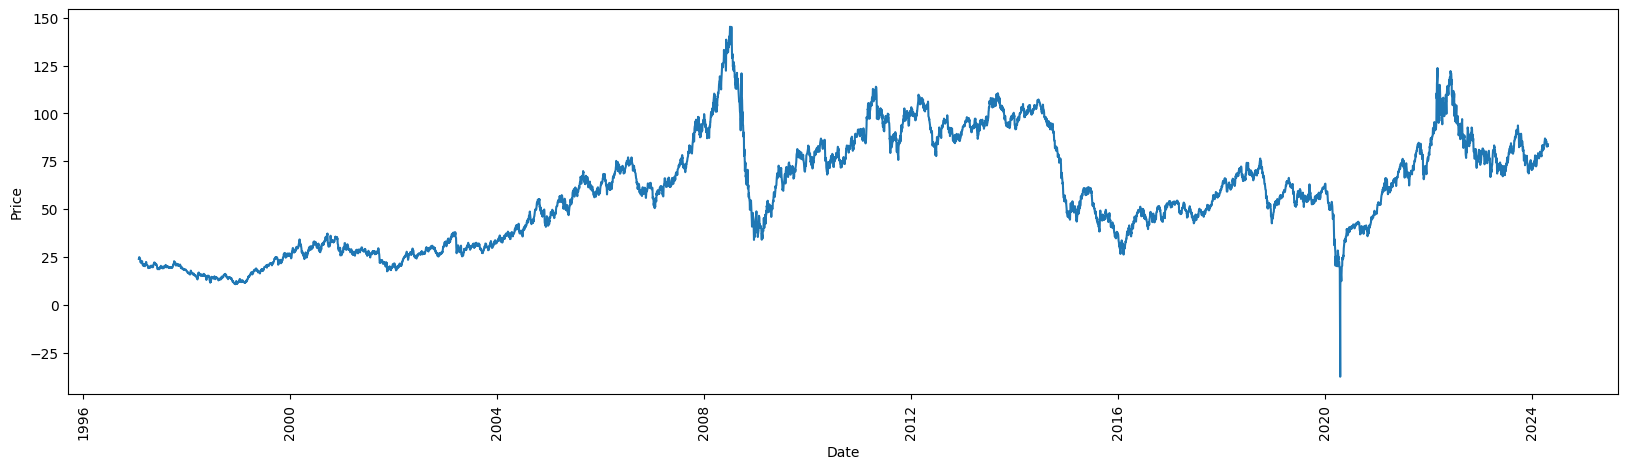

In [264]:
# Crude Oil Price Over Time
plt.figure(figsize = (20, 5))
sns.lineplot(crude_df, x='Date', y='Price')
plt.xticks(rotation=90)
plt.show()

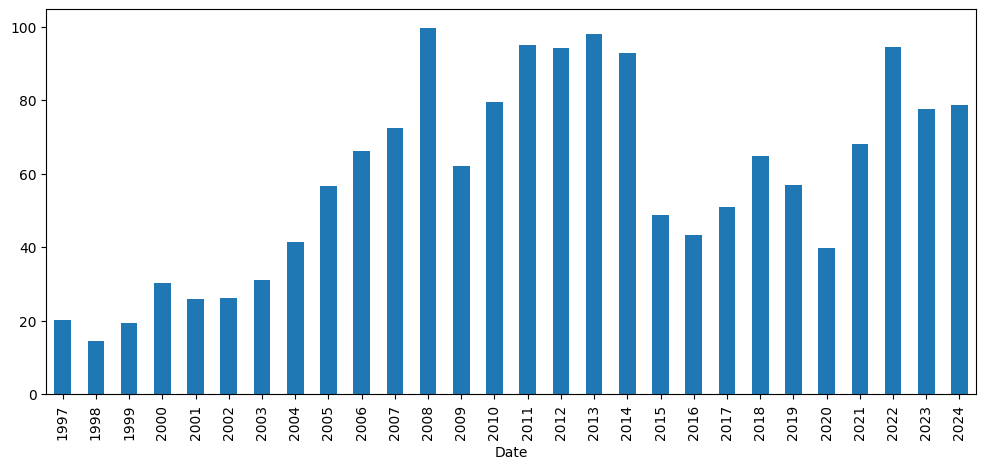

In [265]:
# Average Crude Oil Price by Year

plt.figure(figsize = (12, 5))
crude_df.groupby(crude_df['Date'].dt.year)['Price'].mean().plot(kind='bar')
plt.show()


In [266]:
# Claculate average crude oil for past months after Rig fixture date

def calculate_average_past_months(fixture_date, dataset, past_months):

  '''

  This function calculates average crude oil price for given months
  fixture_date : Date of finalization of fixture
  dataset : dataset in which crude future prices are available
  past_months : months for which average crude price is required

  '''
  try:
        # Convert 'Date' column to datetime
        if not pd.api.types.is_datetime64_any_dtype(dataset['Date']):
          dataset['Date'] = pd.to_datetime(dataset['Date'])

        # Find the index of the given month
        index = dataset[dataset['Date'] == fixture_date].index.tolist()

        # Check if the month exists in the dataset
        if len(index) > 0:
            index = index[0]
            # Calculate the average price for the past months
            # assuming 20-22 working days in a months as Market is closed on Sat & Sunday
            # Taking avg. of 21 working days in a month

            if (index <= (dataset.index.max() - (past_months * 21))):
                average_price = dataset.iloc[index : (index + (past_months * 21))]['Price'].mean()
            else:
                average_price = None  # Not enough data for the past months
        else:
            # Find the nearest available date
            for days in range(0,10):
              nearest_index = dataset[dataset['Date'] == (fixture_date - timedelta(days= days))].index.tolist()
              if len(nearest_index) > 0:
                break
            # Calculate the average price for the past months based on nearest available dates
            nearest_index = nearest_index[0]
            # Taking avg. of 21 working days in a month
            average_price = dataset.iloc[nearest_index : (nearest_index + (past_months * 21))]['Price'].mean()

  except Exception as e:
    print(f"Error: {e}")
    average_price = None

  return average_price

In [267]:
# # Applying the function to original data set to cal. price for past 1 month

# rig_df['Average_crude_Price_Past_1_Months'] = rig_df['Fixture Date'].apply(
#     lambda x: calculate_average_past_months(x, crude_df, 1))

# # Applying the function to original data set to cal. price for past 3 months

# rig_df['Average_crude_Price_Past_3_Months'] = rig_df['Fixture Date'].apply(
#     lambda x: calculate_average_past_months(x, crude_df, 3))

# # Applying the function to original data set to cal. price for past 6 months

# rig_df['Average_crude_Price_Past_6_Months'] = rig_df['Fixture Date'].apply(
#     lambda x: calculate_average_past_months(x, crude_df, 6))

# Applying the function to original data set to cal. price for past 12 months

rig_df['Average_crude_Price_Past_12_Months'] = rig_df['Fixture Date'].apply(
     lambda x: calculate_average_past_months(x, crude_df, 12))

# # Applying the function to original data set to cal. price for past 36 months

# rig_df['Average_crude_Price_Past_36_Months'] = rig_df['Fixture Date'].apply(
#      lambda x: calculate_average_past_months(x, crude_df,36))


In [268]:
rig_df[['Fixture Date', 'Average_crude_Price_Past_12_Months']].head(10)

Fixture Date  Average_crude_Price_Past_12_Months
1    2006-03-28                           59.840952
2    2005-04-05                           45.229167
3    2021-11-01                           64.037857
4    2019-09-30                           56.732024
6    2019-10-01                           56.668016
7    2020-02-11                           57.554167
8    2007-10-03                           64.897500
13   2019-05-09                           62.002579
14   2021-12-30                           68.638413
16   2008-08-31                          105.779087

There are lot of columns which are having null vales thus we have to remove them from data

3. Let us import Rig Utilization Data

In [269]:
# importing Rig utilization Data
util_df= pd.read_excel("/content/drive/MyDrive/Rig Analysis/Petrodata_Rigs_Utilization_ContractedUtilizationReport_20240322_1626.xlsx")
util_df.head(2)

Month  Total Supply  Total Contracted  Marketed Supply  \
0  Apr 2003    593.000000        475.966667       527.233333   
1  May 2003    593.258065        482.129032       527.774194   

   Marketed Contracted  Total Util %  Marketed Util %  
0           471.966667     80.264193        89.517608  
1           477.548387     81.268012        90.483467

In [270]:
util_df["Gap_marketed_supply_contracted"] = util_df['Marketed Supply'] - util_df['Marketed Contracted']
util_df["Gap_total_supply_contracted"] = util_df['Total Supply'] - util_df['Total Contracted']

Total Supply is the entire existing, delivered rig fleet. Marketed supply is that portion of the existing delivered rig fleet which is being actively offered for work in the near term.

In [271]:
util_df['Month'] = pd.to_datetime(util_df['Month'])

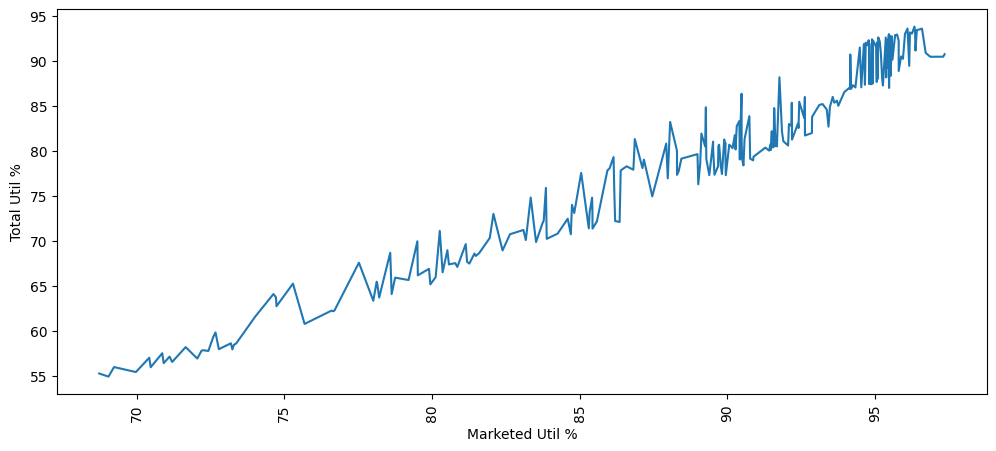

In [272]:
# Marketed Util % vs Total Util %

plt.figure(figsize =(12,5))

sns.lineplot(data =util_df, x= 'Marketed Util %', y = 'Total Util %')
plt.xticks(rotation =90)
plt.show()

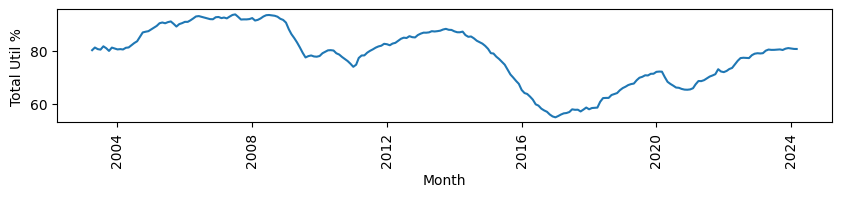

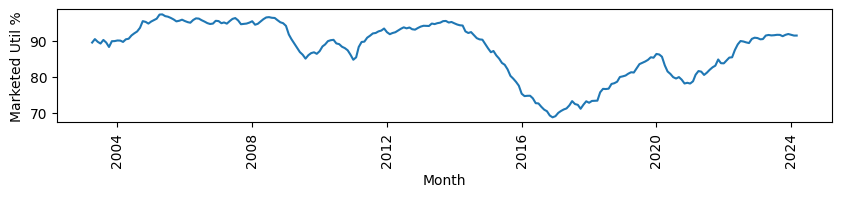

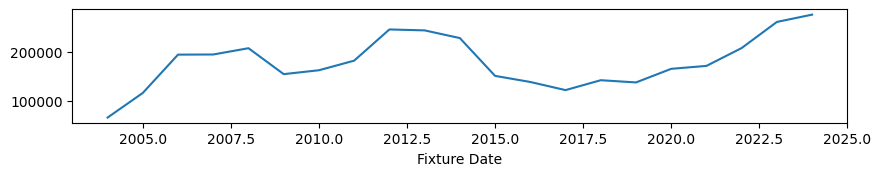

In [273]:
# Plot 1
#  Mean Day rate over a period of time
plt.subplots(figsize=[10,5])
plt.subplot(3, 1, 1)
sns.lineplot(data =util_df, y= 'Total Util %', x = 'Month')
plt.xticks(rotation =90)
plt.show()

#plot 2:
# Crude Oil Price Over Time
plt.subplots(figsize=[10,5])
plt.subplot(3, 1, 2)
sns.lineplot(data =util_df, y= 'Marketed Util %', x = 'Month')
plt.xticks(rotation =90)
plt.show()

#plot 3:
# Crude Oil Price Over Time
plt.subplots(figsize=[10,5])
plt.subplot(3, 1, 3)
rig_df.groupby(rig_df['Fixture Date'].dt.year)['Day Rate'].mean().plot(kind='line')
plt.show()

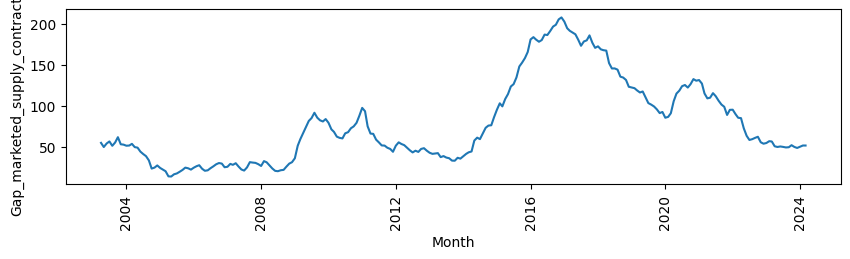

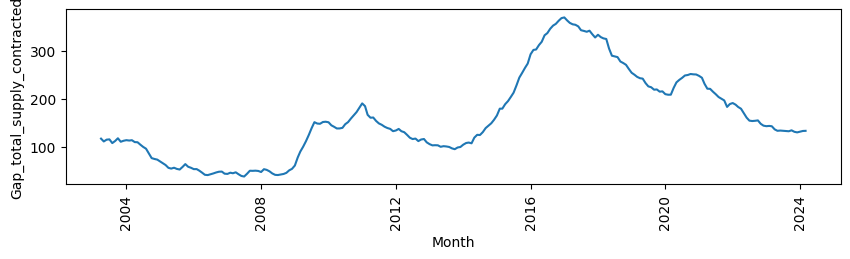

In [274]:
# gap in market supply demand Over Time

# Plot 1
#  Gap_marketed_supply_contracted over a period of time
plt.subplots(figsize=[10,5])
plt.subplot(2, 1, 1)
sns.lineplot(util_df, x='Month', y='Gap_marketed_supply_contracted')
plt.xticks(rotation=90)
plt.show()

#plot 2:
# CGap_total_supply_contracted Over Time
plt.subplots(figsize=[10,5])
plt.subplot(2, 1, 2)
sns.lineplot(util_df, x='Month', y='Gap_total_supply_contracted')
plt.xticks(rotation=90)
plt.show()

In [275]:
rig_df['Fixture Date'] = pd.to_datetime(rig_df['Fixture Date'])

In [276]:
rig_df['Fixture %Y%M'] = rig_df['Fixture Date'].apply(lambda x: x.strftime('%Y-%m'))

In [277]:
rig_df['Fixture %Y%M'].head(2)

1    2006-03
2    2005-04
Name: Fixture %Y%M, dtype: object

In [278]:
util_df['Date_%Y%M'] = util_df['Month'].apply(lambda x: x.strftime('%Y-%m'))

In [279]:
#drooping data peratining to april 2024 as utilization data is not available for April
rig_df = rig_df[~(rig_df['Fixture %Y%M'] == "2024-04")]

In [280]:
# Claculate average Utlilization for past months after Rig fixture Month and year
# As Utilization data is month wise Fixure is also considered month wise assuming actual date won't have much of any impact

def calculate_average_util_past_months(fixture_mon_year, dataset, num_past_months,util):

  '''
  This function calculates Utlilization for past months after Rig fixture Month for given months

  fixture_mon_year : Month and year of finalization of fixture
  dataset : dataset in which crude future prices are available
  past_months : months for which average crude price is required
  util : Type of utilization
  '''
  try:
        # Find the index of the given month
        index_target = dataset[dataset['Date_%Y%M'] == fixture_mon_year].index.tolist()

        # Check if the month exists in the dataset
        index_target = index_target[0]

        # Calculate the average utilization for the past months
        index_start = max(0, index_target - num_past_months + 1)  # Add 1 to include the target month
        index_end = index_target + 1  # Add 1 to include the target month

        #Average utlization
        average_util = dataset.iloc[index_start : index_end][util].mean()


  except Exception as e:
    print(f"Error: {e}")
    average_util = None

  return average_util

In [281]:
# #Applying the function to original data set to cal. Marketed utilization for past 1 month

# rig_df['Average_marketed_util_past_1_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 1, 'Marketed Util %' ))

# # Applying the function to original data set to cal. Marketed utilization for past 3 months

# rig_df['Average_marketed_util_past_3_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 3, 'Marketed Util %'))

# # Applying the function to original data set to cal. Marketed utilization for past 6 months

# rig_df['Average_marketed_util_past_6_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 6, 'Marketed Util %'))

#Applying the function to original data set to cal. Marketed utilization for past 12 months

rig_df['Average_marketed_util_past_12_Months'] = rig_df['Fixture %Y%M'].apply(
     lambda x: calculate_average_util_past_months(x, util_df, 12, 'Marketed Util %'))

# # Applying the function to original data set to cal. Marketed utilization for past 36 months

# rig_df['Average_marketed_util_past_36_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 36, 'Marketed Util %'))

In [282]:
# # Applying the function to original data set to cal. Marketed Supply for past 1 month

# rig_df['Average_Marketed Supply_past_1_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 1, 'Marketed Supply' ))

# # Applying the function to original data set to cal. Marketed Supply for past 3 months

# rig_df['Average_Marketed Supply_past_3_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 3, 'Marketed Supply'))

# # Applying the function to original data set to cal. Marketed Supply for past 6 months

# rig_df['Average_Marketed Supply_past_6_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 6, 'Marketed Supply'))

# # Applying the function to original data set to cal. Marketed Supply for past 12 months

# rig_df['Average_Marketed Supply_past_12_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 12, 'Marketed Supply'))

# # Applying the function to original data set to cal. Marketed Supply for past 36 months

# rig_df['Average_Marketed Supply_past_36_Months'] = rig_df['Fixture %Y%M'].apply(
#    lambda x: calculate_average_util_past_months(x, util_df, 36, 'Marketed Supply'))

In [283]:
# Applying the function to original data set to cal. Marketed Contracted for past 1 month

# rig_df['Average_Marketed Contracted_past_1_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 1, 'Marketed Contracted' ))

# Applying the function to original data set to cal. Marketed Contracted for past 3 months

# rig_df['Average_Marketed Contracted_past_3_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 3, 'Marketed Contracted'))

# Applying the function to original data set to cal. Marketed Contracted for past 6 months

rig_df['Average_Marketed Contracted_past_6_Months'] = rig_df['Fixture %Y%M'].apply(
    lambda x: calculate_average_util_past_months(x, util_df, 6, 'Marketed Contracted'))

# # Applying the function to original data set to cal. Marketed Contracted for past 12 months

# rig_df['Average_Marketed Contracted_past_12_Months'] = rig_df['Fixture %Y%M'].apply(
#    lambda x: calculate_average_util_past_months(x, util_df, 12, 'Marketed Contracted'))

# Applying the function to original data set to cal. Marketed Contracted for past 36 months

#rig_df['Average_Marketed Contracted_past_36_Months'] = rig_df['Fixture %Y%M'].apply(
#    lambda x: calculate_average_util_past_months(x, util_df, 36, 'Marketed Contracted'))

In [284]:
# # Applying the function to original data set to cal. Average gap in marketed supply demand in past 1 Months

# rig_df['Average_gap_in_marketed_supply_demand_past_1_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 1, 'Gap_marketed_supply_demand' ))

# # Applying the function to original data set to cal. Average gap in marketed supply demand for past 3 months

# rig_df['Average_gap_in_marketed_supply_demand_past_3_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 3, 'Gap_marketed_supply_demand'))

# # Applying the function to original data set to cal. Average gap in marketed supply demand for past 6 months

# rig_df['Average_gap_in__marketed_supply_demand_past_6_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 6, 'Gap_marketed_supply_demand'))

# Applying the function to original data set to cal. Average gap in marketed supply demand for past 12 months

rig_df['Average_gap_in_marketed_supply_contracted_past_12_Months'] = rig_df['Fixture %Y%M'].apply(
     lambda x: calculate_average_util_past_months(x, util_df, 12, 'Gap_marketed_supply_contracted'))

# # Applying the function to original data set to cal. Average gap in marketed supply demand for past 36 months

# rig_df['Average_gap_in_marketed_supply_demand_36_Months'] = rig_df['Fixture %Y%M'].apply(
#     lambda x: calculate_average_util_past_months(x, util_df, 36, 'Gap_marketed_supply_demand'))

4. Age of Rig as on Fixture

In [285]:
rig_df.head(1)

Operator  Rig Name           Manager        Contractor  \
1  Al-Khafji Joint Operations  Delta 22  Arabian Drilling  Arabian Drilling   

  Rig Type Rig Market Category  Rig Water Depth       Region  Country/Area  \
1   Jackup          JU <250-IC              200  Middle East  Neutral Zone   

  Contract Start Date Contract End Date Contract Description  Day Rate  \
1          2006-04-16        2009-10-30   3 years + 6 months     65000   

  Day Rate Start Fixture Date        Type Day Rate Type Prior Day Rate  \
1     2006-04-16   2006-03-28  New mutual        Mutual          31000   

  Prior Operator Prior Status Jackup Type  Year In Service DP DP Class  \
1           AGOC     Drilling          IC             1980  N      NaN   

   BOP WP Max MPD Status        BOP Stacks               Rig Design  \
1     10000.0  Not known  Single BOP Stack  Baker Marine BMC-150-IC   

   Quarters Capacity  Leg Length  Cantilever Reach  Crane Capacity  \
1               84.0       301.0              40.0            40.0   

   Derrick Capacity  Drilling Depth  Total Mud Pumps  Variable Load  \
1         1300000.0         20000.0              3.0         2596.0   

  Auto Pipe Handling Competitive Conventional Mooring Dual Activity  \
1                NaN           Y                  NaN             N   

  Special Survey Due Build Country/Area          Build Yard  \
1         2013-03-25          Singapore  Promet Private Ltd   

  Construction Status Contract Type      IMO  Drawworks HP  \
1           Delivered      Standard  8753134        2000.0   

  Emissions Monitoring Software Green Class Notation Hybrid Power Hull Number  \
1                             N                  NaN            N       P1071   

   Tender Hull Type  Total BOP Rams  RigID  Contract_duration  \
1               NaN             3.0    810               1293   

   Average_crude_Price_Past_12_Months Fixture %Y%M  \
1                           59.840952      2006-03   

   Average_marketed_util_past_12_Months  \
1                             96.097132   

   Average_Marketed Contracted_past_6_Months  \
1                                 531.957258   

   Average_gap_in_marketed_supply_contracted_past_12_Months  
1                                           21.63871

In [286]:
rig_df["Age_in_years"] = rig_df['Contract Start Date'].dt.year - rig_df['Year In Service']

In [287]:
rig_df["Age_in_years"].describe()

count    8894.000000
mean       21.114796
std        11.771952
min        -1.000000
25%         9.000000
50%        25.000000
75%        30.000000
max        56.000000
Name: Age_in_years, dtype: float64

In [288]:
rig_df.loc[rig_df["Age_in_years"] < 0, 'Age_in_years'] = 0

## Bivariate Analysis

We will work out relationship of Day rate with all the features

Let us seperate categorical and numerical variable

In [289]:
rig_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8894 entries, 1 to 12234
Data columns (total 61 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   Operator                                                  8894 non-null   object        
 1   Rig Name                                                  8894 non-null   object        
 2   Manager                                                   8894 non-null   object        
 3   Contractor                                                8894 non-null   object        
 4   Rig Type                                                  8894 non-null   object        
 5   Rig Market Category                                       8894 non-null   object        
 6   Rig Water Depth                                           8894 non-null   int64         
 7   Region                                        

In [290]:
num_col=list(rig_df.select_dtypes(['float64','int64','float32','int32']).columns)
num_col = [col for col in num_col if col not in ("RigID",'IMO','Tender Hull Type')]
print(num_col)

['Rig Water Depth', 'Day Rate', 'Year In Service', 'BOP WP Max', 'Quarters Capacity', 'Leg Length', 'Cantilever Reach', 'Crane Capacity', 'Derrick Capacity', 'Drilling Depth', 'Total Mud Pumps', 'Variable Load', 'Drawworks HP', 'Total BOP Rams', 'Contract_duration', 'Average_crude_Price_Past_12_Months', 'Average_marketed_util_past_12_Months', 'Average_Marketed Contracted_past_6_Months', 'Average_gap_in_marketed_supply_contracted_past_12_Months', 'Age_in_years']


In [291]:
cat_col=list(rig_df.select_dtypes(['object']).columns)

In [292]:
#removing feature with voluminous categories
cat_col = [col for col in cat_col if col not in ('Operator', 'Rig Name', 'Manager',
                          'Contractor','Country/Area','Contract Description','Prior Operator',
                            'Prior Day Rate','Rig Design','Build Yard','Hull Number')]
print(cat_col)

['Rig Type', 'Rig Market Category', 'Region', 'Type', 'Day Rate Type', 'Prior Status', 'Jackup Type', 'DP', 'DP Class', 'MPD Status', 'BOP Stacks', 'Auto Pipe Handling', 'Competitive', 'Conventional Mooring', 'Dual Activity', 'Build Country/Area', 'Construction Status', 'Contract Type', 'Emissions Monitoring Software', 'Green Class Notation', 'Hybrid Power', 'Fixture %Y%M']


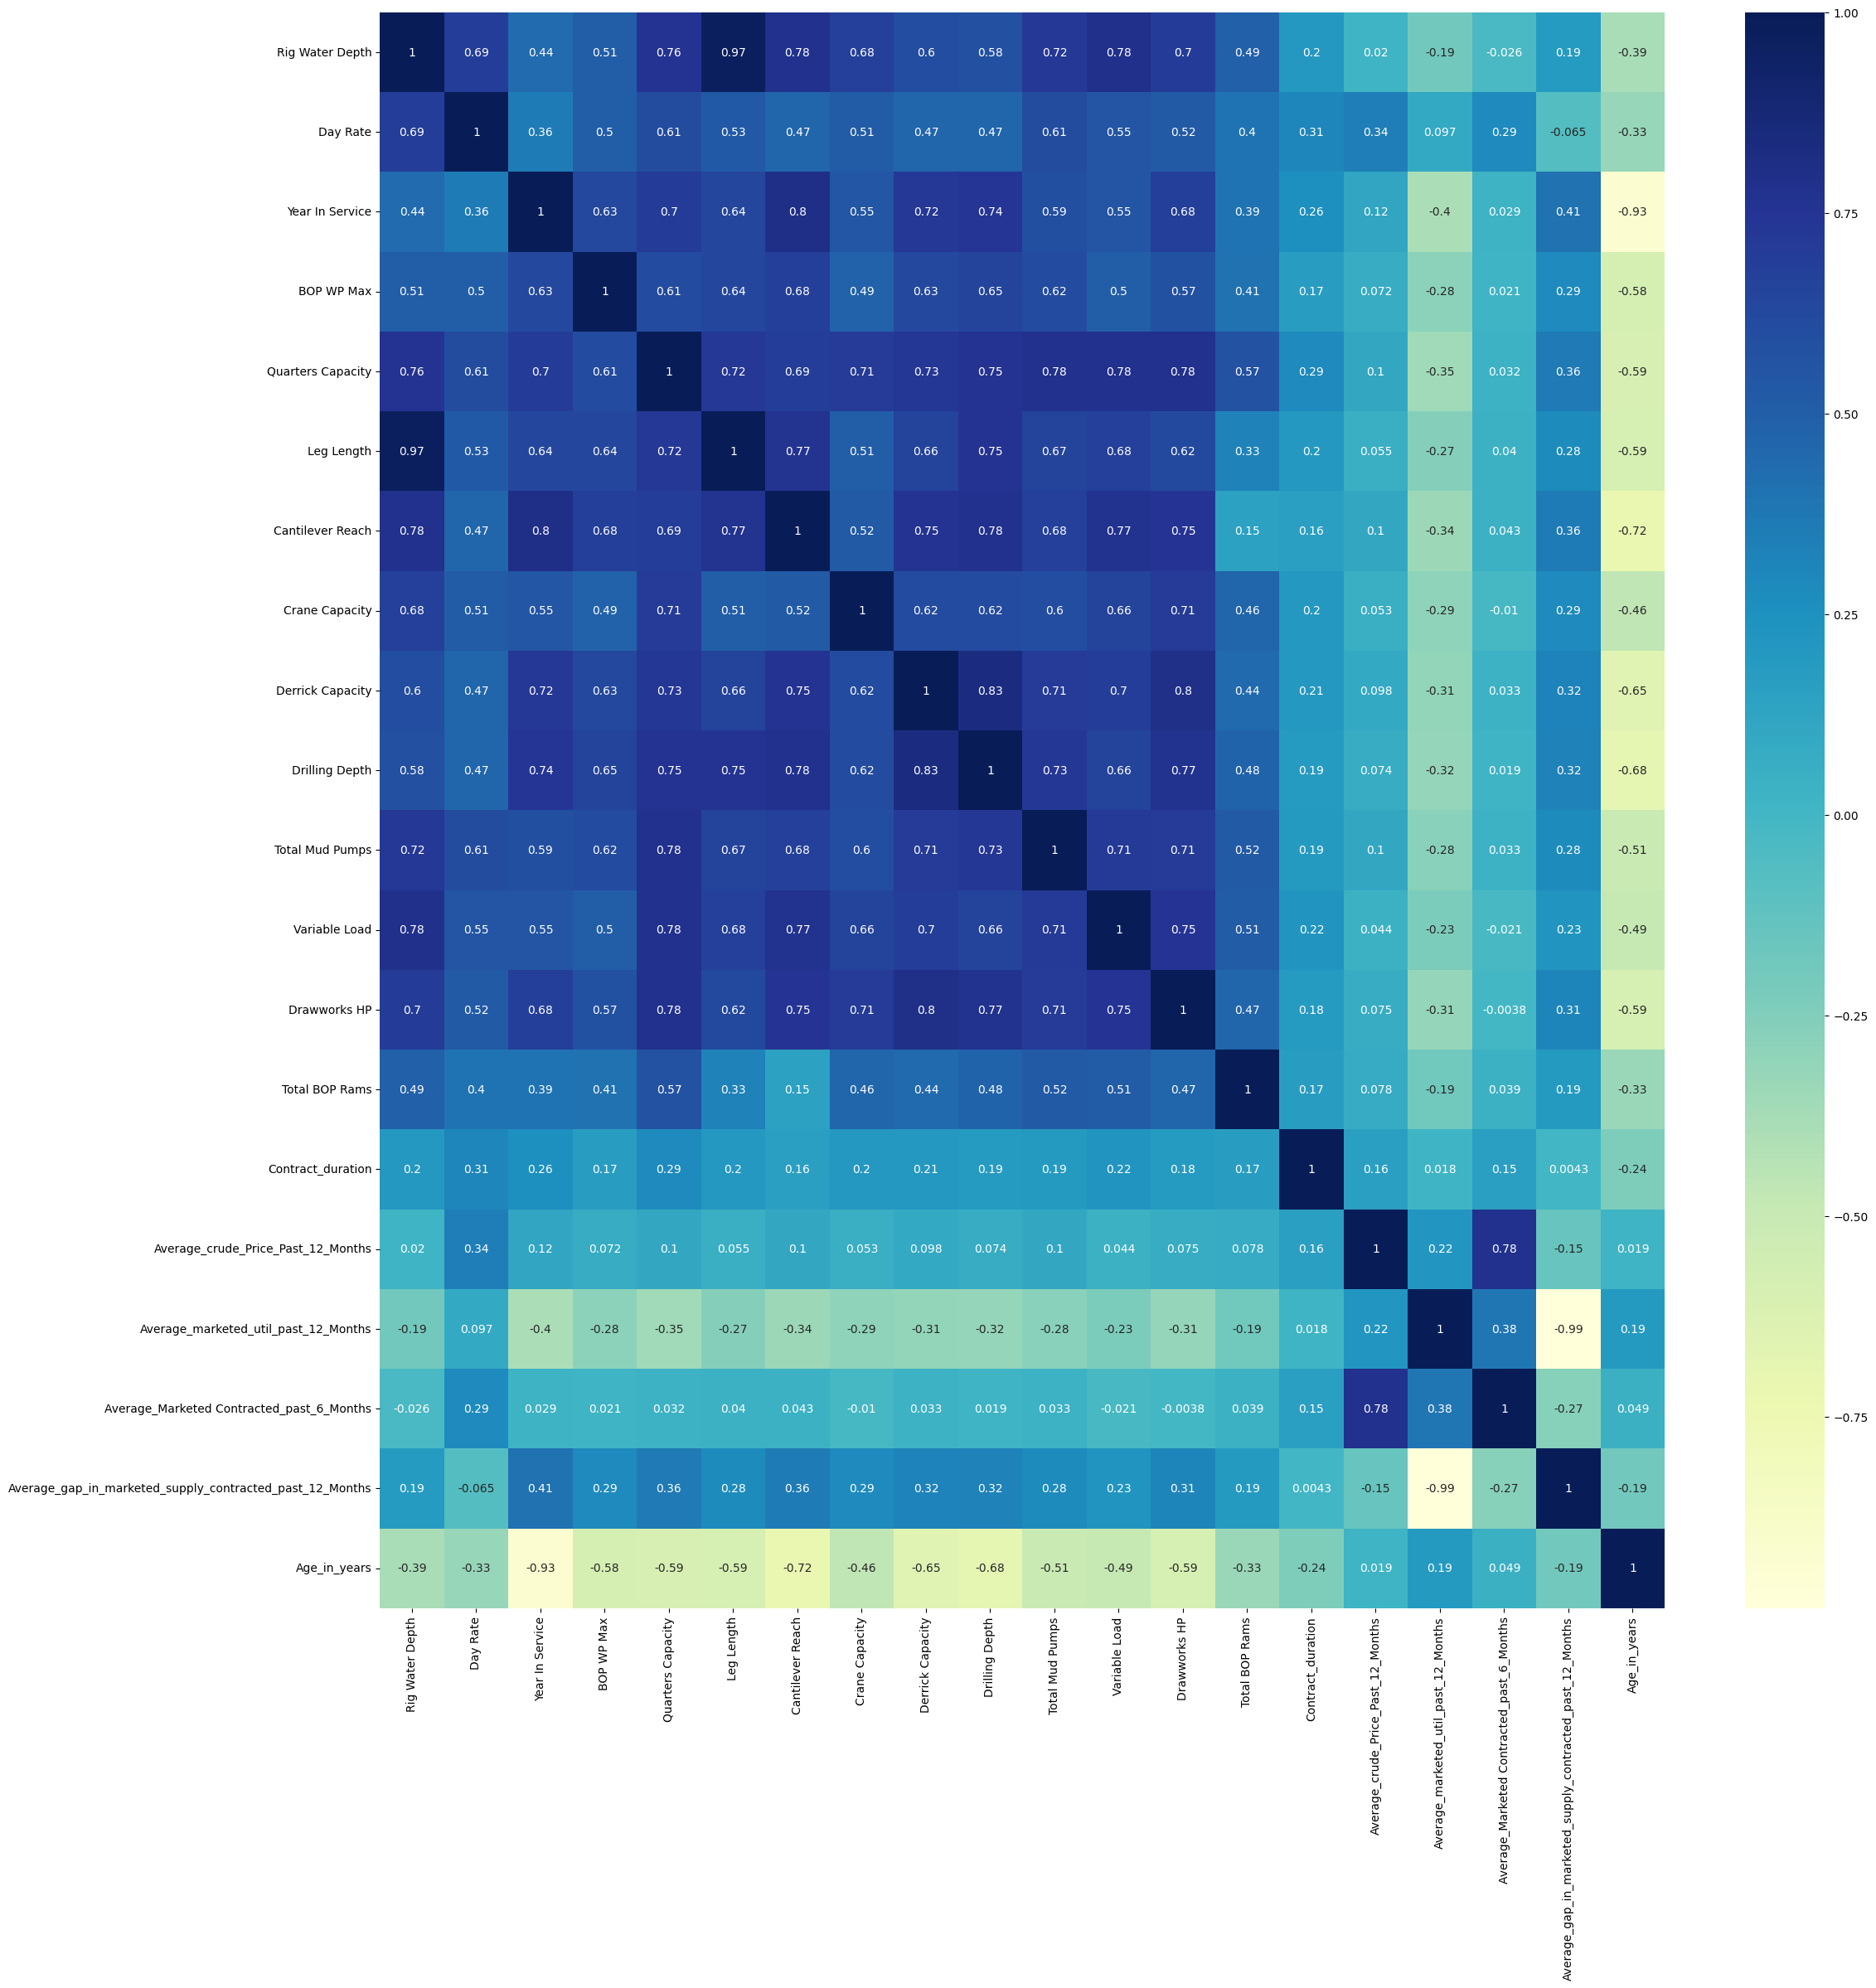

In [293]:
plt.figure(figsize=(25,25))
sns.heatmap(rig_df[num_col].corr(), annot=True, cmap="YlGnBu")
plt.show()

- Day rate is having high correlation with Rig water Depth and moderate correlation with Crude oil price.
- Average Crude oil for different periods is having almost same correlation wwith Day rate.
- Average Crude oil for different periods is having high correlation among themeselves thus it might create high Collinearity in our model.
- Contract Duration is having weak correlation with Day rate

In [294]:
num_col.remove("Day Rate")

CPU times: user 9.81 s, sys: 330 ms, total: 10.1 s
Wall time: 9.9 s


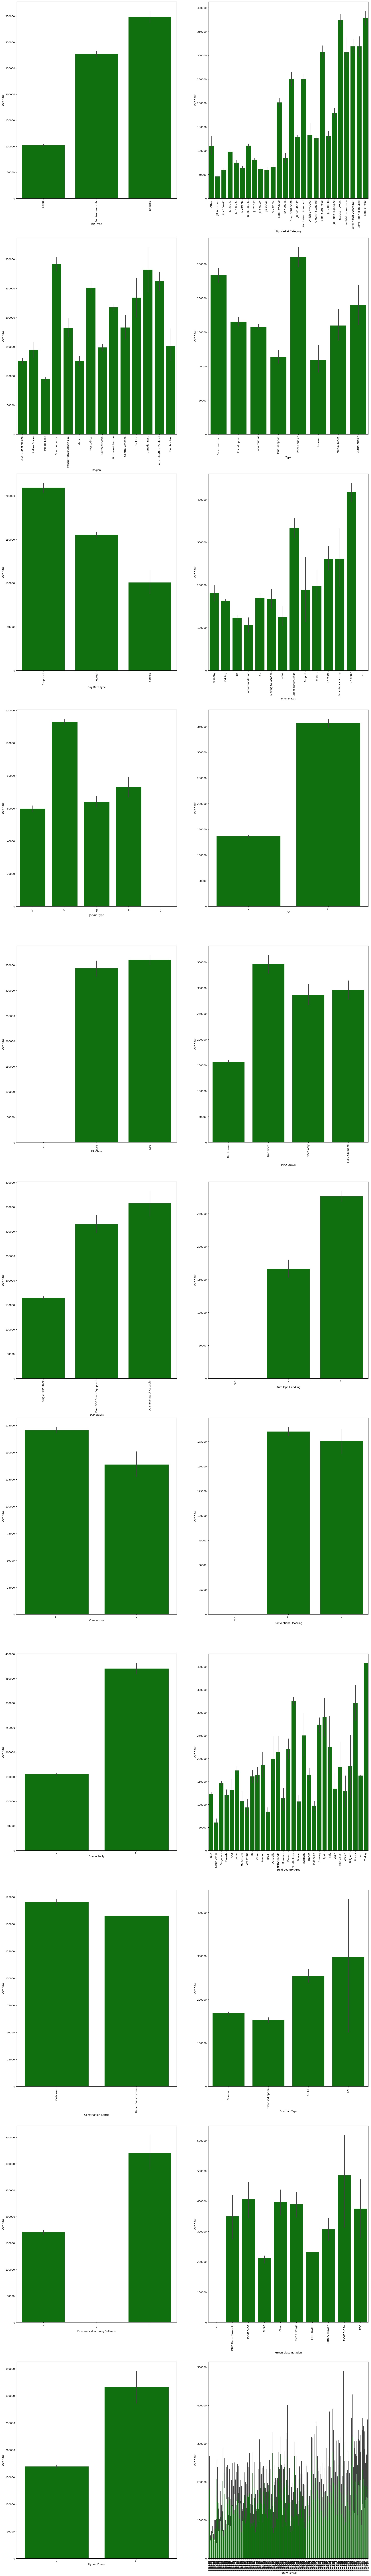

In [295]:
%%time
plt.subplots(figsize=[25,200])
k=1
for col in cat_col:
  plt.subplot(int(len(cat_col)/2)+1,2,k)
  sns.barplot(data=rig_df, x=col, y='Day Rate', color = 'green', order = rig_df.sort_values('Day Rate')[col])
  plt.xticks(rotation=90)
  k=k+1

CPU times: user 932 ms, sys: 61.7 ms, total: 994 ms
Wall time: 945 ms


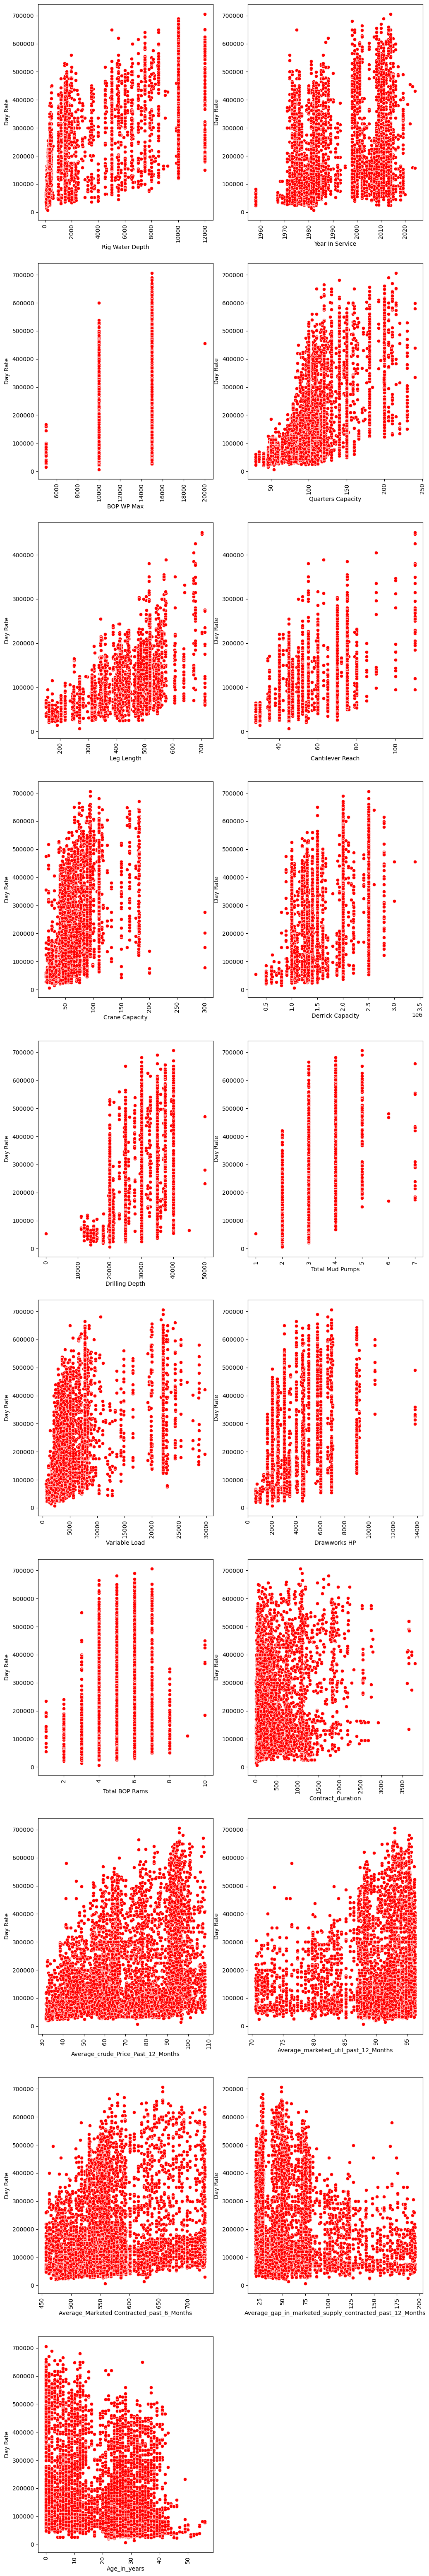

In [296]:
%%time
plt.subplots(figsize=[12,80])
k=1
for col in num_col:
  plt.subplot(int(len(num_col)/2)+1,2,k)
  sns.scatterplot(data=rig_df, x=col, y='Day Rate', color = 'red')
  plt.xticks(rotation=90)
  k=k+1

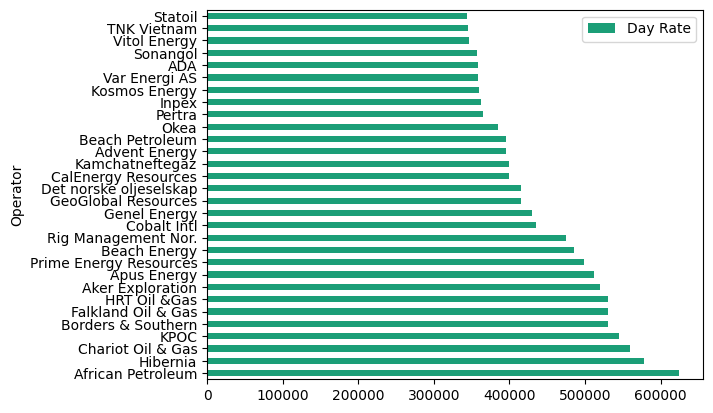

In [297]:
# top thirty operators with maximum day rate
pd.DataFrame(rig_df.groupby(['Operator'])['Day Rate'].mean()).sort_values(["Day Rate"],
            ascending =False)[0:30].plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.show()

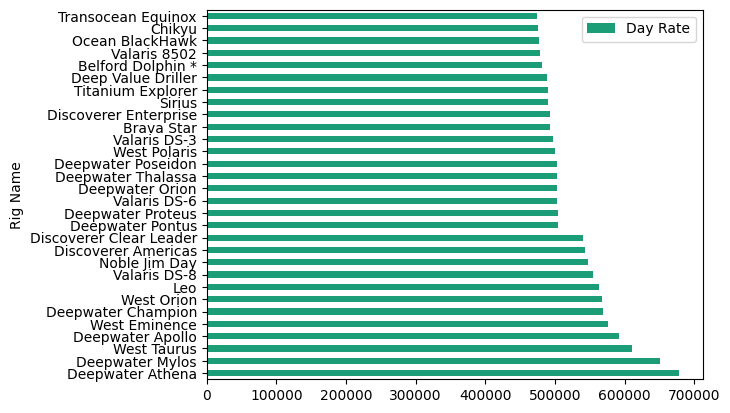

In [298]:
# top thirty Rig Name with maximum day rate
pd.DataFrame(rig_df.groupby(['Rig Name'])['Day Rate'].mean()).sort_values(["Day Rate"],
            ascending =False)[0:30].plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.show()

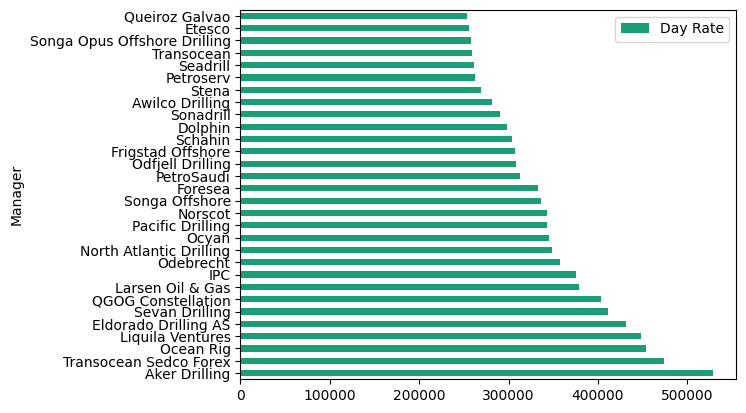

In [299]:
# top thirty Manager with maximum day rate
pd.DataFrame(rig_df.groupby(['Manager'])['Day Rate'].mean()).sort_values(["Day Rate"],
            ascending =False)[0:30].plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.show()

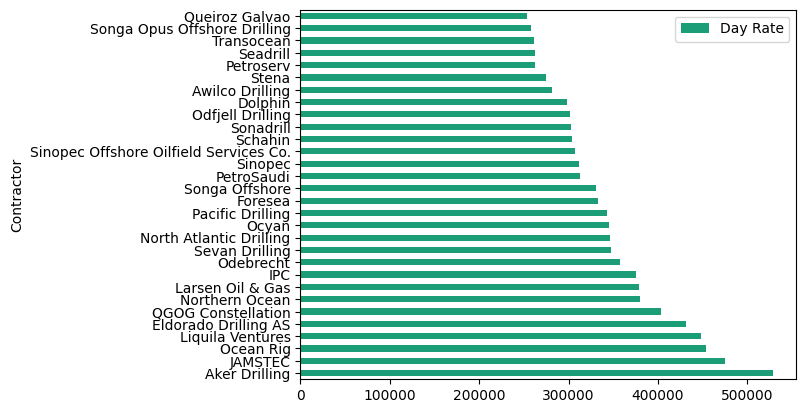

In [300]:
# top thirty Contractors with maximum day rate
pd.DataFrame(rig_df.groupby(['Contractor'])['Day Rate'].mean()).sort_values(["Day Rate"],
            ascending =False)[0:30].plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.show()

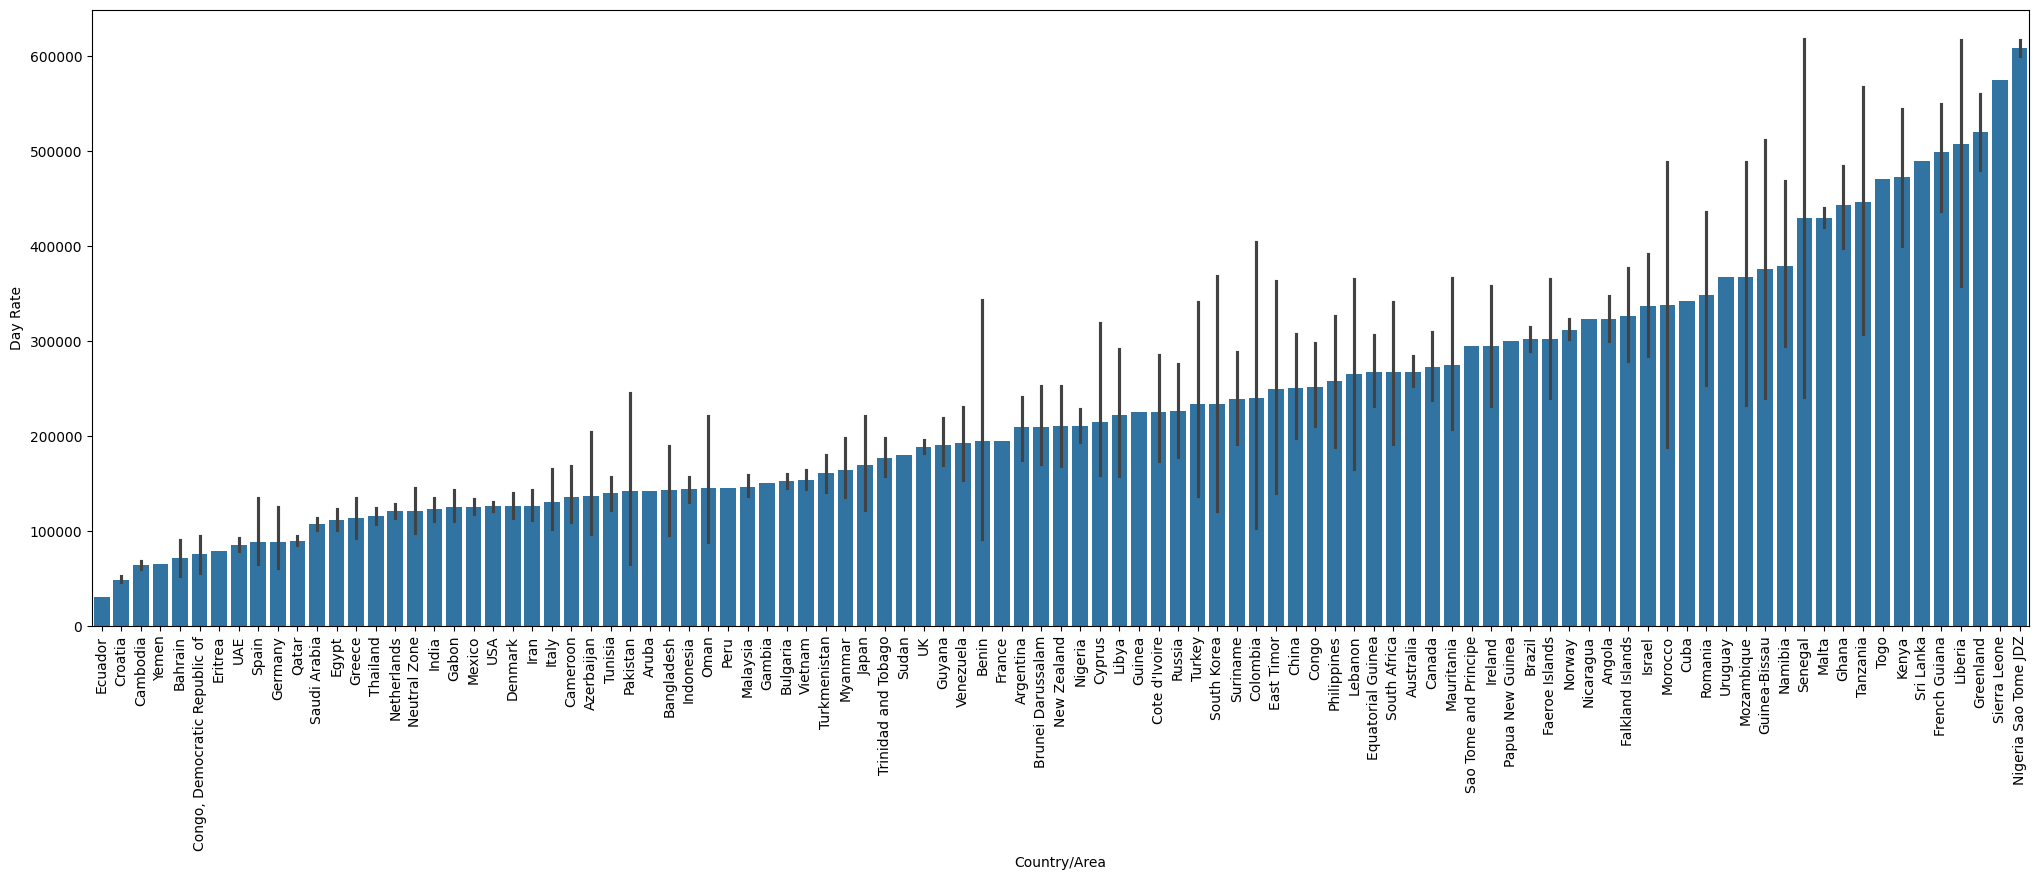

In [301]:
plt.figure(figsize=(25,8))

# Calculate mean price per Country
country_df = rig_df.groupby('Country/Area')['Day Rate'].mean().reset_index()

# Sort categories by mean price
sorted_countries = country_df.sort_values(by='Day Rate')['Country/Area']

sns.barplot(data = rig_df, x="Country/Area", y='Day Rate',estimator=np.mean, order = sorted_countries)
plt.xticks(rotation=90)
plt.show()

Lets workout impact Prior Day Rate on Day Rate

In [302]:
rig_df["Prior Day Rate"] = pd.to_numeric(rig_df["Prior Day Rate"], errors='coerce')

In [303]:
rig_df_copy= rig_df.copy()

In [304]:
rig_df_copy["Prior Day Rate"] = rig_df_copy["Prior Day Rate"].dropna()
rig_df_copy= rig_df_copy[~(rig_df_copy["Prior Day Rate"] == 0)]

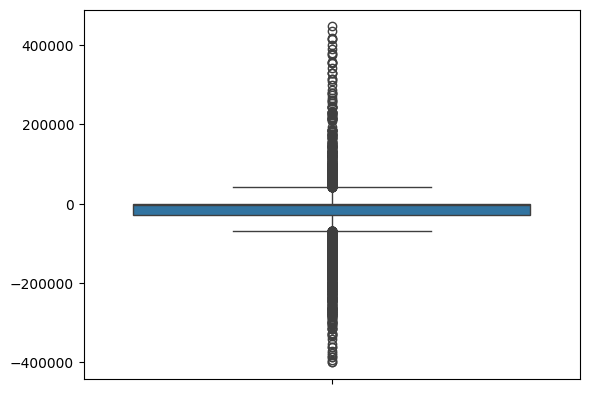

In [305]:
sns.boxplot((rig_df_copy["Prior Day Rate"] - rig_df_copy["Day Rate"]))
#plt.xticks(rotation=90)
plt.show()

In [306]:
((rig_df_copy["Day Rate"] - rig_df_copy["Prior Day Rate"])/(rig_df_copy["Prior Day Rate"])).describe()

count    6597.000000
mean        0.205428
std         0.516203
min        -0.789350
25%         0.000000
50%         0.031579
75%         0.250000
max         6.037037
dtype: float64

- Average increase in Day rate compared to prior Rate is 20.86%.
- Also, considering Median values Day rate is around 3.35 % higher compared to prios Day rate.
- Maximum increase is 603% and maximum reduction is 78.9%

There is considerable difference between Day Rate and Prior Day rate

Lets check variation of price with Fixture day and crude price

In [307]:
# #Lets do the univariate analysis on Numeric data typesLotArea
# plt.figure(figsize=(5,10))
# sns.boxplot(x="value", y="variable",data=pd.melt(rig_df[num_col]))
# plt.show()

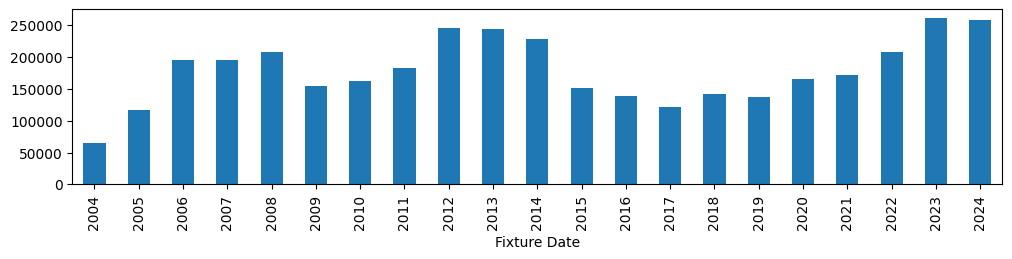

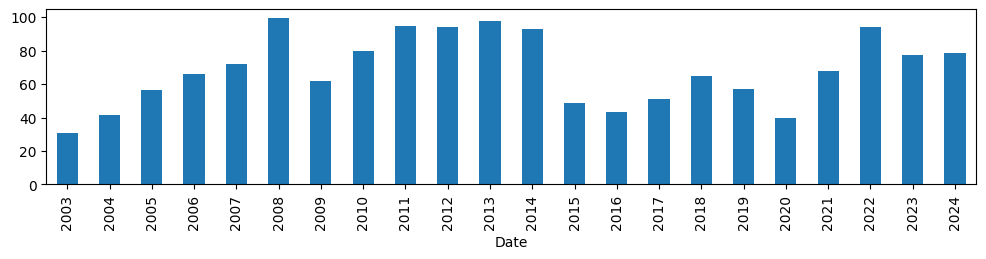

In [308]:
# Create a figure and a set of subplots
plt.subplots(figsize=[12,5])

# Plot 1
#  Mean Day rate over a period of time
plt.subplot(2, 1, 1)
rig_df.groupby(rig_df['Fixture Date'].dt.year)['Day Rate'].mean().plot(kind='bar')
plt.show()

#plot 2:
# Crude Oil Price Over Time
plt.subplots(figsize=[12,5])
plt.subplot(2, 1, 2)
crude_df[0:5480].groupby(crude_df['Date'].dt.year)['Price'].mean().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

As seen above there seems to be some correlation of Crude price with Day Rate atleast at year level

Let us check variation for Indian Ocean

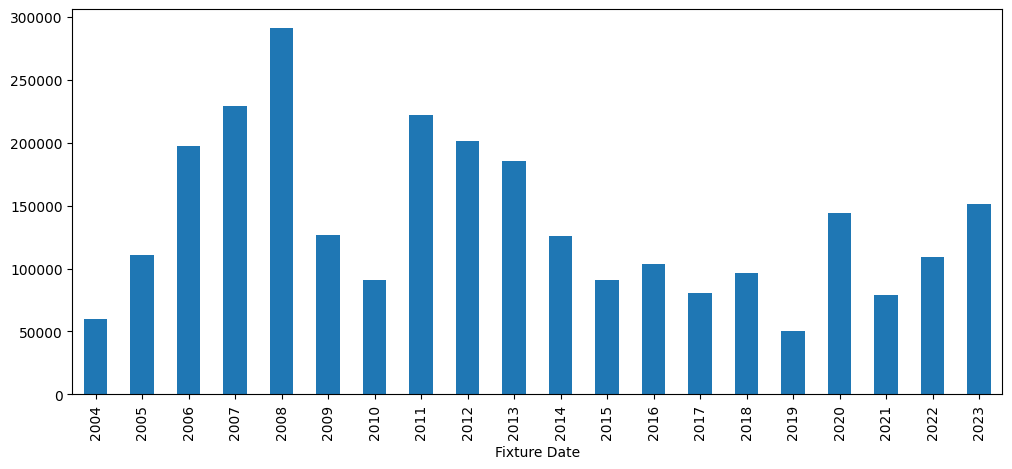

In [309]:
plt.figure(figsize = (12, 5))
rig_df[rig_df['Region'].isin(['Indian Ocean'])].groupby(rig_df['Fixture Date'].dt.year)['Day Rate'].mean().plot(kind='bar')
plt.show()

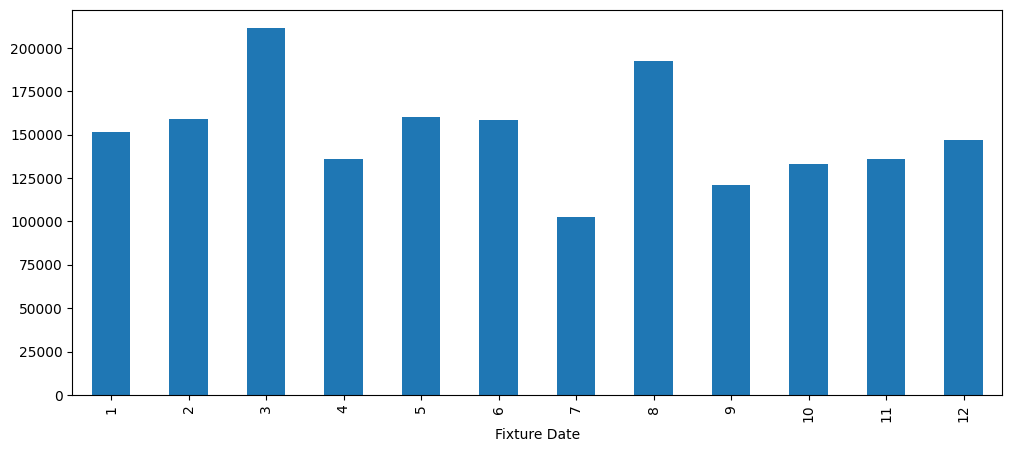

In [310]:
plt.figure(figsize = (12, 5))
rig_df[rig_df['Region'] == 'Indian Ocean'].groupby(rig_df['Fixture Date'].dt.month)['Day Rate'].mean().plot(kind='bar')
plt.show()

In [311]:
rig_df = rig_df[~(rig_df['Competitive'] == "N")]

Let is drop all the features who are not having any impact on Day rate.

In [312]:
rig_df.drop(["Operator","Rig Name","Manager","Contractor","Country/Area","Contract Start Date","Contract End Date",
             "Contract Description", "Day Rate Start", "Fixture Date", "Prior Operator", 'Prior Day Rate', "Fixture %Y%M",
             'Tender Hull Type', 'Green Class Notation','Conventional Mooring', 'IMO', 'DP Class', 'Hull Number','Special Survey Due',
             "Year In Service","Rig Design",'Competitive','Build Yard', 'Construction Status', 'RigID', 'Build Country/Area'], axis =1, inplace=True)

In [313]:
rig_df.shape

(8854, 34)

In [314]:
rig_df.head(2)

Rig Type Rig Market Category  Rig Water Depth       Region  Day Rate  \
1   Jackup          JU <250-IC              200  Middle East     65000   
2   Jackup          JU <250-IC              200  Middle East     31000   

            Type Day Rate Type Prior Status Jackup Type DP  BOP WP Max  \
1     New mutual        Mutual     Drilling          IC  N     10000.0   
2  Priced option    Pre-priced     Drilling          IC  N     10000.0   

  MPD Status        BOP Stacks  Quarters Capacity  Leg Length  \
1  Not known  Single BOP Stack               84.0       301.0   
2  Not known  Single BOP Stack               84.0       301.0   

   Cantilever Reach  Crane Capacity  Derrick Capacity  Drilling Depth  \
1              40.0            40.0         1300000.0         20000.0   
2              40.0            40.0         1300000.0         20000.0   

   Total Mud Pumps  Variable Load Auto Pipe Handling Dual Activity  \
1              3.0         2596.0                NaN             N   
2              3.0         2596.0                NaN             N   

      Contract Type  Drawworks HP Emissions Monitoring Software Hybrid Power  \
1          Standard        2000.0                             N            N   
2  Exercised option        2000.0                             N            N   

   Total BOP Rams  Contract_duration  Average_crude_Price_Past_12_Months  \
1             3.0               1293                           59.840952   
2             3.0                365                           45.229167   

   Average_marketed_util_past_12_Months  \
1                             96.097132   
2                             94.213881   

   Average_Marketed Contracted_past_6_Months  \
1                                 531.957258   
2                                 515.844790   

   Average_gap_in_marketed_supply_contracted_past_12_Months  Age_in_years  
1                                          21.638710                   26  
2                                          30.759415                   25

# Data Imputation for missing values

1. Let us check issing values

In [315]:
null_df = pd.DataFrame(rig_df.isnull().sum()/rig_df.shape[0] * 100).reset_index()
null_df.columns=["Feature", "% null values"]
null_df = null_df[null_df["% null values"] >0]
null_df.sort_values("% null values", ascending = False)


Feature  % null values
21             Auto Pipe Handling      79.929975
25  Emissions Monitoring Software      46.803705
15               Cantilever Reach      40.625706
14                     Leg Length      35.803027
8                     Jackup Type      35.690084
24                   Drawworks HP       3.354416
27                 Total BOP Rams       2.157217
20                  Variable Load       1.005195
16                 Crane Capacity       0.779309
17               Derrick Capacity       0.508245
10                     BOP WP Max       0.474362
19                Total Mud Pumps       0.316241
18                 Drilling Depth       0.248475
13              Quarters Capacity       0.146826
7                    Prior Status       0.045177

2. Missing value treatment

In [316]:
#Dropping Auto Pipe Handling as there are majority null values
rig_df.drop(["Auto Pipe Handling", "Emissions Monitoring Software"], axis =1, inplace =True)

In [317]:
# As Emissions Monitoring Software is having major impact on Day rate replacing nan values with "NA"
#rig_df["Emissions Monitoring Software"].fillna("NA", inplace=True)

In [318]:
rig_df['Cantilever Reach'].describe()

count    5257.000000
mean       53.845539
std        14.832991
min        28.000000
25%        45.000000
50%        45.000000
75%        70.000000
max       110.000000
Name: Cantilever Reach, dtype: float64

In [319]:
rig_df[rig_df["Rig Type"] == "Jackup"]['Cantilever Reach'].isnull().sum()/rig_df.shape[0] *100

4.935622317596566

In [320]:
ss_ds_df = rig_df[rig_df['Rig Type'].isin(["Semisubmersible", "Drillship"])]

In [321]:
ss_ds_df['Cantilever Reach'].isnull().sum()/ss_ds_df.shape[0] *100

100.0

As Cantilever Reach is applicable only in jackup rig for semisubmersible and Drillship its value should be Zero

In [322]:
# let replace all null values with median values
rig_df["Cantilever Reach"].fillna(rig_df["Cantilever Reach"].median(), inplace =True)

In [323]:
# Now let us change value to zero for Semisubmersible and Drillships
rig_df.loc[rig_df['Cantilever Reach'].isin(["Semisubmersible", "Drillship"]), 'Cantilever Reach'] = 0

For Leg length let us check missing values for jack up rigs


In [324]:
rig_df[rig_df["Rig Type"] == "Jackup"]['Leg Length'].isnull().sum()/rig_df.shape[0] *100

0.112943302462164

In [325]:
ss_ds_df['Leg Length'].isnull().sum()/ss_ds_df.shape[0] *100

100.0

As Leg Length is applicable only in jackup rig for semisubmersible and Drillship its value should be Zero

In [326]:
# let replace all null values with median values
rig_df["Leg Length"].fillna(rig_df["Leg Length"].median(), inplace =True)

In [327]:
# Now let us change Leg Length to zero for Semisubmersible and Drillships
rig_df.loc[rig_df['Leg Length'].isin(["Semisubmersible", "Drillship"]), 'Leg Length'] = 0

For Jackup Type let us check missing values for jack up rigs

In [328]:
rig_df[rig_df["Rig Type"] == "Jackup"]['Jackup Type'].isnull().sum()/rig_df.shape[0] *100

0.0

In [329]:
ss_ds_df['Jackup Type'].isnull().sum()/ss_ds_df.shape[0] *100

100.0

Thus all the null values are for Semi sumersible and drillship

In [330]:
rig_df["Jackup Type"].fillna("Not Jackup", inplace =True)

Imputing other features

In [331]:
# %%time
# null_num_cols =["Variable Load", "Crane Capacity","Derrick Capacity", "Quarters Capacity"]

# plt.subplots(figsize=[12,50])
# k=1
# for col in null_num_cols:
#   plt.subplot(int(len(cat_cols_)/2)+1,2,k)
#   sns.boxplot(data=rig_df, x=col)
#   plt.xticks(rotation=90)
#   k=k+1

There are many outliers in data fro above features thus while imputing value let us impute median value

In [332]:
#imputing median values for numeric values with many unique values and outliers

null_num_cols =["Variable Load", "Crane Capacity","Derrick Capacity", "Quarters Capacity"]
for col in null_num_cols:
  rig_df[col].fillna(rig_df[col].median(), inplace =True)

In [333]:
#imputing mode values for categorical values

null_cat_cols = ["Drawworks HP", "BOP WP Max", "Drilling Depth", "Total BOP Rams","Total Mud Pumps","Prior Status"]
for col in null_cat_cols:
  rig_df[col].fillna(rig_df[col].mode()[0], inplace =True)

In [334]:
rig_df.isnull().sum()

Rig Type                                                    0
Rig Market Category                                         0
Rig Water Depth                                             0
Region                                                      0
Day Rate                                                    0
Type                                                        0
Day Rate Type                                               0
Prior Status                                                0
Jackup Type                                                 0
DP                                                          0
BOP WP Max                                                  0
MPD Status                                                  0
BOP Stacks                                                  0
Quarters Capacity                                           0
Leg Length                                                  0
Cantilever Reach                                            0
Crane Capacity                                              0
Derrick Capacity                                            0
Drilling Depth                                              0
Total Mud Pumps                                             0
Variable Load                                               0
Dual Activity                                               0
Contract Type                                               0
Drawworks HP                                                0
Hybrid Power                                                0
Total BOP Rams                                              0
Contract_duration                                           0
Average_crude_Price_Past_12_Months                          0
Average_marketed_util_past_12_Months                        0
Average_Marketed Contracted_past_6_Months                   0
Average_gap_in_marketed_supply_contracted_past_12_Months    0
Age_in_years                                                0
dtype: int64

# Data Preperation

Now as we know have of many categorical variables, we need to treat these variables in order to draw patterns from them through modelling.Now we have two types of categorical variables:

- Nominal categorical variables
- Ordered categorical variables

For Nominal Nominal categorical variables we will create dummy variables; for k no of labels/categories in variables we will define k-1 no. of features and original variable shall be dropped.

For Ordered categorical variables we will implement Label encoding in incresing order of categories in variable as 0,1,2,3,4,....

In instatnt problem all the categorical varaibles are nominal

In [335]:
rig_df.shape

(8854, 32)

In [336]:
rig_df_mod = rig_df.copy()

In [337]:
rig_df_mod.head(2)

Rig Type Rig Market Category  Rig Water Depth       Region  Day Rate  \
1   Jackup          JU <250-IC              200  Middle East     65000   
2   Jackup          JU <250-IC              200  Middle East     31000   

            Type Day Rate Type Prior Status Jackup Type DP  BOP WP Max  \
1     New mutual        Mutual     Drilling          IC  N     10000.0   
2  Priced option    Pre-priced     Drilling          IC  N     10000.0   

  MPD Status        BOP Stacks  Quarters Capacity  Leg Length  \
1  Not known  Single BOP Stack               84.0       301.0   
2  Not known  Single BOP Stack               84.0       301.0   

   Cantilever Reach  Crane Capacity  Derrick Capacity  Drilling Depth  \
1              40.0            40.0         1300000.0         20000.0   
2              40.0            40.0         1300000.0         20000.0   

   Total Mud Pumps  Variable Load Dual Activity     Contract Type  \
1              3.0         2596.0             N          Standard   
2              3.0         2596.0             N  Exercised option   

   Drawworks HP Hybrid Power  Total BOP Rams  Contract_duration  \
1        2000.0            N             3.0               1293   
2        2000.0            N             3.0                365   

   Average_crude_Price_Past_12_Months  Average_marketed_util_past_12_Months  \
1                           59.840952                             96.097132   
2                           45.229167                             94.213881   

   Average_Marketed Contracted_past_6_Months  \
1                                 531.957258   
2                                 515.844790   

   Average_gap_in_marketed_supply_contracted_past_12_Months  Age_in_years  
1                                          21.638710                   26  
2                                          30.759415                   25

In [338]:
#Creating dummy variables for all the categorical variables
nominal = ["Rig Type", "Region", "Type", "Day Rate Type",
           "Prior Status", "DP", "BOP Stacks", "Dual Activity",'Contract Type'
           ,"Hybrid Power"]
for i in nominal:
    dummy_df=pd.get_dummies(rig_df_mod[i],prefix=i, drop_first =True, dtype =int)
    rig_df_mod = rig_df_mod.join(dummy_df, how='left')
    rig_df_mod = rig_df_mod.drop([i], axis=1)

In [339]:
# Dummies for Rig Market Category
dummy_df=pd.get_dummies(rig_df_mod["Rig Market Category"],prefix="Rig Market Category", drop_first =False, dtype =int)
rig_df_mod = rig_df_mod.join(dummy_df, how='left')

# Dummies for Jackup Type
dummy_df=pd.get_dummies(rig_df_mod["Jackup Type"],prefix="Jackup Type", drop_first =False, dtype =int)
rig_df_mod = rig_df_mod.join(dummy_df, how='left')

# Dummies for MPD Status
dummy_df=pd.get_dummies(rig_df_mod["MPD Status"],prefix="MPD Status", drop_first =False, dtype =int)
rig_df_mod = rig_df_mod.join(dummy_df, how='left')

#dummy_df=pd.get_dummies(rig_df_mod["Emissions Monitoring Software"],prefix="Emissions Monitoring Software", drop_first =False, dtype =int)
#rig_df_mod = rig_df_mod.join(dummy_df, how='left')

rig_df_mod = rig_df_mod.drop(["Jackup Type", "Rig Market Category", "MPD Status", "Jackup Type_Not Jackup",
                              "MPD Status_Not known", 'Rig Market Category_Drillship <=3000'], axis=1) # "Emissions Monitoring Software_NA", "Emissions Monitoring Software",

In [340]:
rig_df_mod.shape

(8854, 95)

In [341]:
rig_df_mod.head(2)

Rig Water Depth  Day Rate  BOP WP Max  Quarters Capacity  Leg Length  \
1              200     65000     10000.0               84.0       301.0   
2              200     31000     10000.0               84.0       301.0   

   Cantilever Reach  Crane Capacity  Derrick Capacity  Drilling Depth  \
1              40.0            40.0         1300000.0         20000.0   
2              40.0            40.0         1300000.0         20000.0   

   Total Mud Pumps  Variable Load  Drawworks HP  Total BOP Rams  \
1              3.0         2596.0        2000.0             3.0   
2              3.0         2596.0        2000.0             3.0   

   Contract_duration  Average_crude_Price_Past_12_Months  \
1               1293                           59.840952   
2                365                           45.229167   

   Average_marketed_util_past_12_Months  \
1                             96.097132   
2                             94.213881   

   Average_Marketed Contracted_past_6_Months  \
1                                 531.957258   
2                                 515.844790   

   Average_gap_in_marketed_supply_contracted_past_12_Months  Age_in_years  \
1                                          21.638710                   26   
2                                          30.759415                   25   

   Rig Type_Jackup  Rig Type_Semisubmersible  Region_Canada, East  \
1                1                         0                    0   
2                1                         0                    0   

   Region_Caspian Sea  Region_Central America  Region_Far East  \
1                   0                       0                0   
2                   0                       0                0   

   Region_Indian Ocean  Region_Mediterranean/Black Sea  Region_Mexico  \
1                    0                               0              0   
2                    0                               0              0   

   Region_Middle East  Region_Northwest Europe  Region_South America  \
1                   1                        0                     0   
2                   1                        0                     0   

   Region_Southeast Asia  Region_USA, Gulf of Mexico  Region_West Africa  \
1                      0                           0                   0   
2                      0                           0                   0   

   Type_Mutual option  Type_Mutual reneg  Type_Mutual sublet  Type_New mutual  \
1                   0                  0                   0                1   
2                   0                  0                   0                0   

   Type_Priced contract  Type_Priced option  Type_Priced sublet  \
1                     0                   0                   0   
2                     0                   1                   0   

   Day Rate Type_Mutual  Day Rate Type_Pre-priced  Prior Status_Accommodation  \
1                     1                         0                           0   
2                     0                         1                           0   

   Prior Status_Drilling  Prior Status_En route  Prior Status_Idle  \
1                      1                      0                  0   
2                      1                      0                  0   

   Prior Status_In port  Prior Status_Moving to location  \
1                     0                                0   
2                     0                                0   

   Prior Status_On order  Prior Status_Standby  Prior Status_Support  \
1                      0                     0                     0   
2                      0                     0                     0   

   Prior Status_Under construction  Prior Status_WOW  Prior Status_Yard  DP_Y  \
1                                0                 0                  0     0   
2                                0                 0                  0     0   

   BOP Stacks_Dual BOP Stack Equipped  BOP Stacks_S

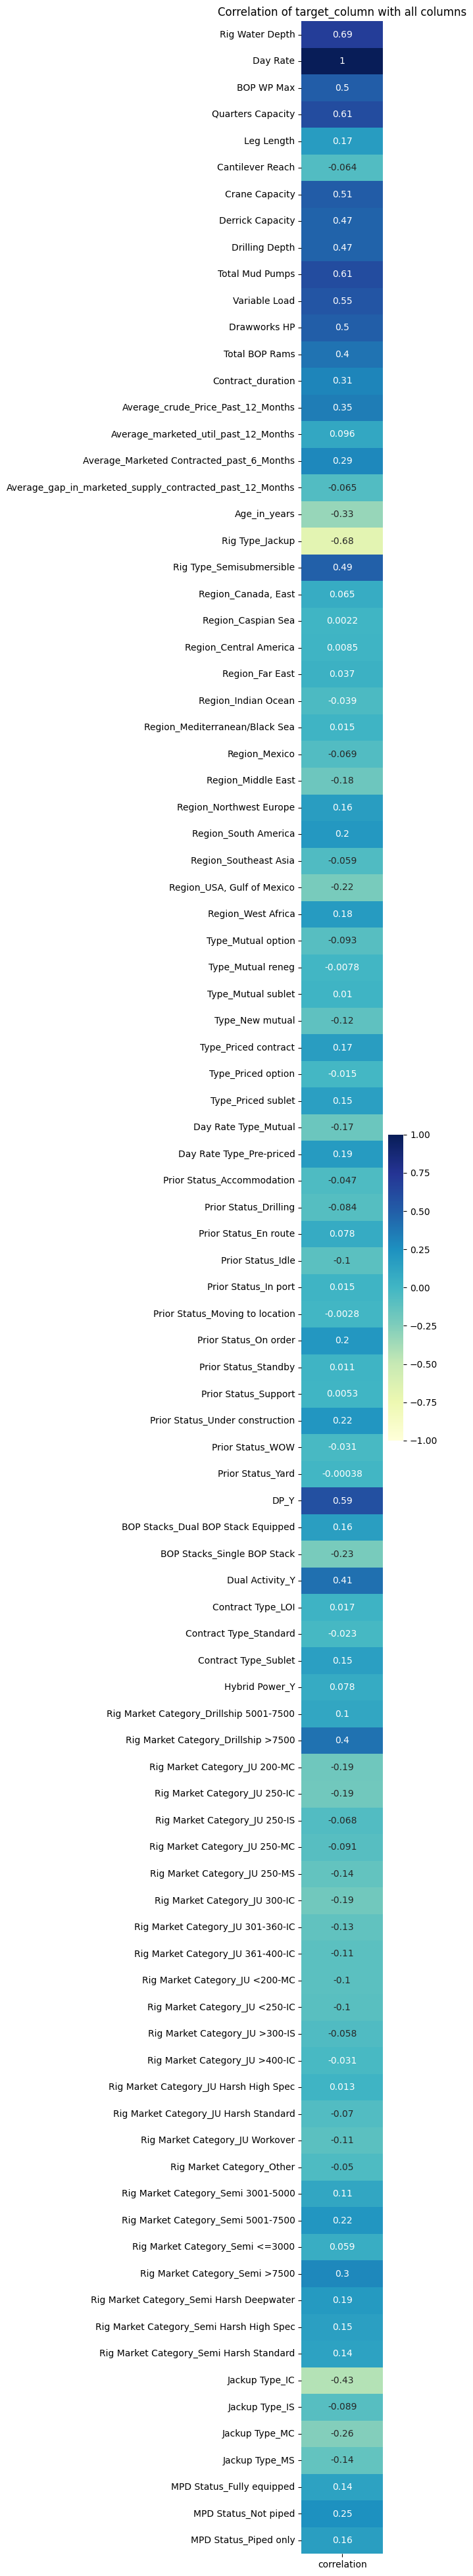

In [342]:
# correlation of Day rate with other coluns
correlation = rig_df_mod.corrwith(rig_df_mod['Day Rate'])
# Reshape the correlation values to a DataFrame for plotting
correlation_df = correlation.to_frame(name='correlation')
# Plot heatmap
plt.figure(figsize=(2,50))
sns.heatmap(correlation_df, cmap='YlGnBu', annot=True, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation of target_column with all columns')
plt.show()

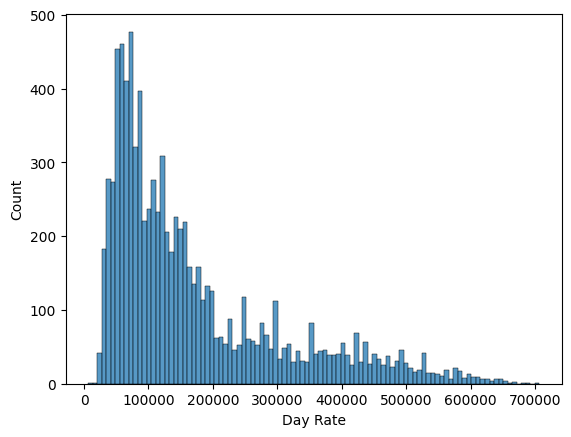

In [343]:
sns.histplot(rig_df_mod['Day Rate'], bins=100)
plt.show()

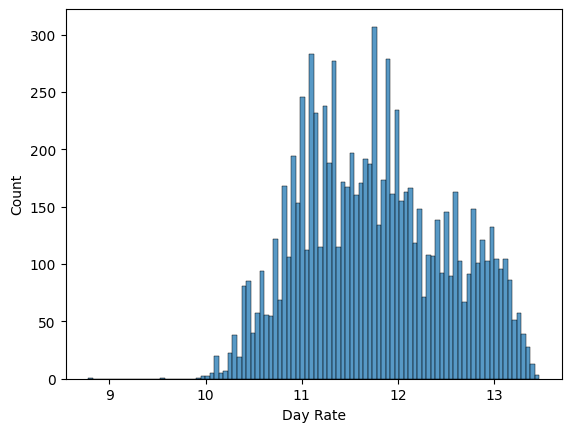

In [344]:
sns.histplot(np.log(rig_df_mod['Day Rate']), bins=100)
plt.show()

In [345]:
rig_df_mod['Day Rate']= np.log(rig_df_mod['Day Rate'])

In [346]:
rig_df_mod['Day Rate'].describe()

count    8854.000000
mean       11.760663
std         0.755561
min         8.779557
25%        11.156251
50%        11.711776
75%        12.323856
max        13.467407
Name: Day Rate, dtype: float64

In [347]:
rig_df_mod[rig_df_mod['Day Rate'] == -np.inf]

Empty DataFrame
Columns: [Rig Water Depth, Day Rate, BOP WP Max, Quarters Capacity, Leg Length, Cantilever Reach, Crane Capacity, Derrick Capacity, Drilling Depth, Total Mud Pumps, Variable Load, Drawworks HP, Total BOP Rams, Contract_duration, Average_crude_Price_Past_12_Months, Average_marketed_util_past_12_Months, Average_Marketed Contracted_past_6_Months, Average_gap_in_marketed_supply_contracted_past_12_Months, Age_in_years, Rig Type_Jackup, Rig Type_Semisubmersible, Region_Canada, East, Region_Caspian Sea, Region_Central America, Region_Far East, Region_Indian Ocean, Region_Mediterranean/Black Sea, Region_Mexico, Region_Middle East, Region_Northwest Europe, Region_South America, Region_Southeast Asia, Region_USA, Gulf of Mexico, Region_West Africa, Type_Mutual option, Type_Mutual reneg, Type_Mutual sublet, Type_New mutual, Type_Priced contract, Type_Priced option, Type_Priced sublet, Day Rate Type_Mutual, Day Rate Type_Pre-priced, Prior Status_Accommodation, Prior Status_Drilling, Prior Status_En route, Prior Status_Idle, Prior Status_In port, Prior Status_Moving to location, Prior Status_On order, Prior Status_Standby, Prior Status_Support, Prior Status_Under construction, Prior Status_WOW, Prior Status_Yard, DP_Y, BOP Stacks_Dual BOP Stack Equipped, BOP Stacks_Single BOP Stack, Dual Activity_Y, Contract Type_LOI, Contract Type_Standard, Contract Type_Sublet, Hybrid Power_Y, Rig Market Category_Drillship 5001-7500, Rig Market Category_Drillship >7500, Rig Market Category_JU 200-MC, Rig Market Category_JU 250-IC, Rig Market Category_JU 250-IS, Rig Market Category_JU 250-MC, Rig Market Category_JU 250-MS, Rig Market Category_JU 300-IC, Rig Market Category_JU 301-360-IC, Rig Market Category_JU 361-400-IC, Rig Market Category_JU <200-MC, Rig Market Category_JU <250-IC, Rig Market Category_JU >300-IS, Rig Market Category_JU >400-IC, Rig Market Category_JU Harsh High Spec, Rig Market Category_JU Harsh Standard, Rig Market Category_JU Workover, Rig Market Category_Other, Rig Market Category_Semi 3001-5000, Rig Market Category_Semi 5001-7500, Rig Market Category_Semi <=3000, Rig Market Category_Semi >7500, Rig Market Category_Semi Harsh Deepwater, Rig Market Category_Semi Harsh High Spec, Rig Market Category_Semi Harsh Standard, Jackup Type_IC, Jackup Type_IS, Jackup Type_MC, Jackup Type_MS, MPD Status_Fully equipped, MPD Status_Not piped, MPD Status_Piped only]
Index: []

In [348]:
# Dropping negative infine values
rig_df_mod = rig_df_mod[~(rig_df_mod['Day Rate'] == -np.inf)]

# Test, train and Validation split

In [349]:
#Defining X & Y for Regression
data =rig_df_mod.drop(["Day Rate"], axis=1)
labels =(rig_df_mod["Day Rate"])

In [350]:
#Train data
train_X, temp_X, train_y, temp_y = train_test_split(data, labels, test_size=0.3, random_state=42)

In [351]:
#Validation and Test data
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, random_state=42)

In [352]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((6197, 94), (6197,), (1328, 94), (1328,), (1329, 94), (1329,))

In [353]:
#num_col=list(rig_df_mod.select_dtypes(['float64','int64','float32','int32']).columns)
#num_col.remove("Day Rate")
#print(num_col)
num_col =['Rig Water Depth', 'BOP WP Max', 'Quarters Capacity', 'Leg Length',
          'Cantilever Reach', 'Crane Capacity', 'Derrick Capacity', 'Drilling Depth',
          'Total Mud Pumps', 'Variable Load', 'Drawworks HP', 'Total BOP Rams',
          'Contract_duration', 'Average_crude_Price_Past_12_Months',
          'Average_marketed_util_past_12_Months', 'Average_Marketed Contracted_past_6_Months',
          'Average_gap_in_marketed_supply_contracted_past_12_Months', 'Age_in_years']

In [354]:
#Lets perform normalization on the numeric data
#Creating scaler object
scaler=MinMaxScaler()

# Now normalization needs to be performed on all the numeric and label encoded varaibles
train_X[num_col]=scaler.fit_transform(train_X[num_col])
val_X[num_col]=scaler.transform(val_X[num_col])

# Model Building

## Linear Regression

In [355]:
# initialing model
lr_model= LinearRegression()

# fiiiting model
lr_model.fit(train_X,train_y)


LinearRegression()

In [356]:
# Initialize a DataFrame to store results globally
results_df = pd.DataFrame(columns=['Model Name', 'Type', 'R2 Score %', 'MSE'])

def evaluate_model_metrics(train_data, actual, model_name, train_or_val, model_type):
    global results_df

    # Calculate metrics

    predicted = model_type.predict(train_data)
    r2  = round((r2_score(actual, predicted)*100),3)
    mse = round(mean_squared_error(actual, predicted),3)

    # Create a new row with the results
    new_row = {
        'Model Name': model_name,
        'Type' : train_or_val,
        'R2 Score %': r2,
        'MSE': mse
    }

    # Append new row to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    return results_df

In [357]:
evaluate_model_metrics(train_X, train_y, "Linear Regression", "Train", lr_model)
evaluate_model_metrics(val_X, val_y, "Linear Regression", "Val", lr_model)

Model Name   Type  R2 Score %    MSE
0  Linear Regression  Train      83.340  0.094
1  Linear Regression    Val      82.546  0.103

Model is not overfitting nor underfitting :P. Lets not get carried away. Residual Analysis next >>

In [358]:
# Best model after considering everything = 0.85
# Model after dropping hightly correleated features to reduce complexity = 0.83
# With using Crude oil and Demand Supply Data = 0.63
# Without using Supply and Demand Data = 0.79


### Residual Analysis

In [359]:
val_y_pred = lr_model.predict(val_X)
res=val_y_pred-val_y

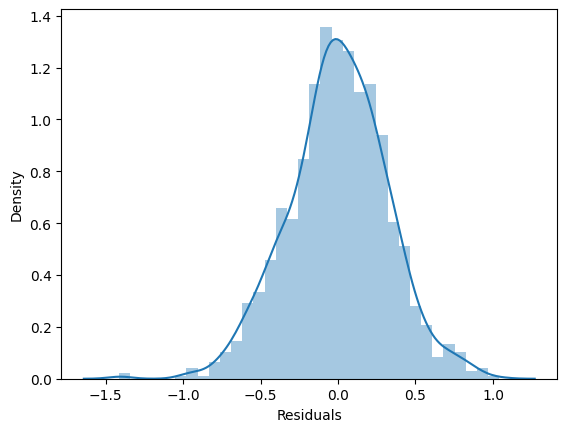

In [360]:
#Validiating Linear Regresion assumptions
sns.distplot(res)
plt.xlabel("Residuals")
plt.show()

Errors are normally distributed

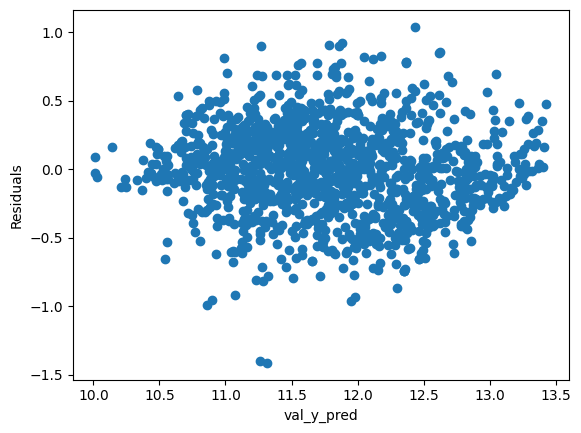

In [361]:
plt.scatter(val_y_pred,res)
plt.xlabel("val_y_pred")
plt.ylabel("Residuals")
plt.show()

In [362]:
#Coefficients in model
lin_reg_coeff=pd.DataFrame({"Variable":train_X.columns, "coeff":lr_model.coef_ })
lin_reg_coeff.sort_values(by="coeff", ascending =False, inplace =True)
lin_reg_coeff[0:10]

Variable         coeff
88                                     Jackup Type_IS  1.205918e+12
87                                     Jackup Type_IC  1.205918e+12
89                                     Jackup Type_MC  1.205918e+12
68                      Rig Market Category_JU 250-MS  6.848683e+11
90                                     Jackup Type_MS  5.210493e+11
60                               Contract Type_Sublet  3.894752e+11
14               Average_marketed_util_past_12_Months  6.616603e+00
16  Average_gap_in_marketed_supply_contracted_past...  5.670499e+00
85           Rig Market Category_Semi Harsh High Spec  1.397797e+00
84           Rig Market Category_Semi Harsh Deepwater  1.309769e+00

## Linear Regression after dropping Multi collenarity using VIF

In [363]:
#As there are multiple features let us work out multi collenarity
# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

In [364]:
# Calculate VIF
vif_data = calculate_vif(train_X)

# sorting features with highest VIF
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature  VIF
35             Type_Mutual sublet  inf
68  Rig Market Category_JU 250-MS  inf
60           Contract Type_Sublet  inf
39             Type_Priced sublet  inf
87                 Jackup Type_IC  inf

In [365]:
# dropping feature with most VIF
train_X_drop = train_X.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped = [vif_data["feature"][0:1].to_list()[0]]

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature  VIF
18                Rig Type_Jackup  inf
67  Rig Market Category_JU 250-MS  inf
86                 Jackup Type_IC  inf
87                 Jackup Type_IS  inf
88                 Jackup Type_MC  inf

In [366]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped = [vif_data["feature"][0:1].to_list()[0]]

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature          VIF
66         Rig Market Category_JU 250-MS          inf
88                        Jackup Type_MS          inf
85                        Jackup Type_IC  1962.972701
18              Rig Type_Semisubmersible  1280.931399
14  Average_marketed_util_past_12_Months   860.105387

In [367]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature          VIF
84                        Jackup Type_IC  1962.972701
18              Rig Type_Semisubmersible  1280.931399
14  Average_marketed_util_past_12_Months   860.105387
34                       Type_New mutual   488.865592
57                Contract Type_Standard   475.254403

In [368]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
14  Average_marketed_util_past_12_Months  859.874526
34                       Type_New mutual  488.865591
57                Contract Type_Standard  475.044165
38                  Day Rate Type_Mutual  466.589487
18              Rig Type_Semisubmersible  394.725534

In [369]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
33           Type_New mutual  486.905499
37      Day Rate Type_Mutual  466.575765
17  Rig Type_Semisubmersible  394.709975
56    Contract Type_Standard  340.331849
40     Prior Status_Drilling  256.588364

In [370]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
17  Rig Type_Semisubmersible  394.709575
55    Contract Type_Standard  338.123437
39     Prior Status_Drilling  256.041715
3                 Leg Length  155.740585
7             Drilling Depth  125.292845

In [371]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
54  Contract Type_Standard  338.107768
38   Prior Status_Drilling  256.040649
3               Leg Length  155.429727
7           Drilling Depth  125.143310
82          Jackup Type_MC   93.873808

In [372]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
38        Prior Status_Drilling  204.057225
3                    Leg Length  149.432735
7                Drilling Depth  123.342235
81               Jackup Type_MC   93.872494
51  BOP Stacks_Single BOP Stack   89.567376

In [373]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
3                      Leg Length  139.754744
7                  Drilling Depth  118.768774
80                 Jackup Type_MC   93.869772
50    BOP Stacks_Single BOP Stack   81.906186
57  Rig Market Category_JU 200-MC   59.717357

In [374]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature         VIF
6                  Drilling Depth  118.323142
79                 Jackup Type_MC   93.807706
49    BOP Stacks_Single BOP Stack   78.683561
56  Rig Market Category_JU 200-MC   59.639179
34           Day Rate Type_Mutual   57.912860

In [375]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
78                 Jackup Type_MC  93.403255
48    BOP Stacks_Single BOP Stack  78.070633
55  Rig Market Category_JU 200-MC  59.637035
33           Day Rate Type_Mutual  56.571669
0                 Rig Water Depth  51.928043

In [376]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
48  BOP Stacks_Single BOP Stack  78.061407
33         Day Rate Type_Mutual  56.565874
0               Rig Water Depth  51.924784
2             Quarters Capacity  43.932226
23      Region_Northwest Europe  39.861135

In [377]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
33     Day Rate Type_Mutual  53.152295
0           Rig Water Depth  51.723760
2         Quarters Capacity  43.870403
23  Region_Northwest Europe  39.815871
5          Derrick Capacity  39.066110

In [378]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
0            Rig Water Depth  51.709042
2          Quarters Capacity  43.737464
23   Region_Northwest Europe  39.632650
5           Derrick Capacity  38.988778
33  Day Rate Type_Pre-priced  37.068428

In [379]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
1          Quarters Capacity  42.131045
22   Region_Northwest Europe  39.631775
4           Derrick Capacity  38.814983
32  Day Rate Type_Pre-priced  37.062707
74            Jackup Type_IS  36.193433

In [380]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
21   Region_Northwest Europe  39.602189
3           Derrick Capacity  38.329201
31  Day Rate Type_Pre-priced  37.039810
73            Jackup Type_IS  36.189062
4            Total Mud Pumps  32.738667

In [381]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
3           Derrick Capacity  38.315986
30  Day Rate Type_Pre-priced  37.035216
72            Jackup Type_IS  36.005137
4            Total Mud Pumps  32.712152
0                 BOP WP Max  25.285637

In [382]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
29  Day Rate Type_Pre-priced  37.019236
71            Jackup Type_IS  35.967459
3            Total Mud Pumps  32.168346
0                 BOP WP Max  24.883452
1           Cantilever Reach  21.074523

In [383]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
70                  Jackup Type_IS  35.967448
3                  Total Mud Pumps  32.154269
0                       BOP WP Max  24.874029
1                 Cantilever Reach  21.047130
57  Rig Market Category_JU >300-IS  19.593848

In [384]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
3   Total Mud Pumps  32.117926
0        BOP WP Max  24.873736
1  Cantilever Reach  21.014815
4     Variable Load  17.969220
6    Total BOP Rams  15.896081

In [385]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
0                            BOP WP Max  24.831006
1                      Cantilever Reach  20.253258
3                         Variable Load  17.521108
5                        Total BOP Rams  15.749518
46  Rig Market Category_Drillship >7500  14.341648

In [386]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
0                      Cantilever Reach  19.983387
2                         Variable Load  17.176219
4                        Total BOP Rams  15.583222
45  Rig Market Category_Drillship >7500  13.029230
9                          Age_in_years  12.890566

In [387]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
1                         Variable Load  15.929136
3                        Total BOP Rams  15.530975
44  Rig Market Category_Drillship >7500  13.028209
5    Average_crude_Price_Past_12_Months  11.898553
8                          Age_in_years  11.749436

In [388]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
2                       Total BOP Rams  15.214699
4   Average_crude_Price_Past_12_Months  11.898386
7                         Age_in_years  11.744215
40                Contract Type_Sublet  10.584512
1                         Drawworks HP  10.518488

In [389]:
# dropping feature with most VIF
train_X_drop = train_X_drop.drop([vif_data["feature"][0:1].to_list()[0]], axis = 1)

#list of features dropped
features_dropped.append(vif_data["feature"][0:1].to_list()[0])

# Calculate VIF
vif_data = calculate_vif(train_X_drop)
vif_data = vif_data.sort_values(by = "VIF", ascending = False).head(5)
vif_data

feature        VIF
3   Average_crude_Price_Past_12_Months  11.894708
6                         Age_in_years  11.681936
39                Contract Type_Sublet  10.583954
1                         Drawworks HP  10.487818
23                  Type_Priced sublet  10.452779

In [390]:
features_dropped

['Rig Type_Jackup',
 'Rig Market Category_JU 250-MS',
 'Jackup Type_IC',
 'Average_marketed_util_past_12_Months',
 'Type_New mutual',
 'Rig Type_Semisubmersible',
 'Contract Type_Standard',
 'Prior Status_Drilling',
 'Leg Length',
 'Drilling Depth',
 'Jackup Type_MC',
 'BOP Stacks_Single BOP Stack',
 'Day Rate Type_Mutual',
 'Rig Water Depth',
 'Quarters Capacity',
 'Region_Northwest Europe',
 'Derrick Capacity',
 'Day Rate Type_Pre-priced',
 'Jackup Type_IS',
 'Total Mud Pumps',
 'BOP WP Max',
 'Cantilever Reach',
 'Variable Load',
 'Total BOP Rams']

In [391]:
features_dropped.append("Type_Mutual sublet")

In [392]:
val_X_drop = val_X.drop(features_dropped, axis = 1)

In [393]:
# initialing model
lr_model_vif= LinearRegression()

# fiiiting model
lr_model_vif.fit(train_X_drop,train_y)

LinearRegression()

In [394]:
evaluate_model_metrics(train_X_drop, train_y, "Linear Regression VIF", "Train", lr_model_vif)
evaluate_model_metrics(val_X_drop, val_y, "Linear Regression VIF", "Val", lr_model_vif)

Model Name   Type  R2 Score %    MSE
0      Linear Regression  Train      83.340  0.094
1      Linear Regression    Val      82.546  0.103
2  Linear Regression VIF  Train      80.161  0.112
3  Linear Regression VIF    Val      79.348  0.122

In [395]:
#Coefficients in model
lin_reg_coeff=pd.DataFrame({"Variable":train_X_drop.columns, "coeff":lr_model_vif.coef_ })
lin_reg_coeff.sort_values(by="coeff", ascending =False, inplace =True)
lin_reg_coeff[0:10]

Variable     coeff
61            Rig Market Category_Semi >7500  0.901992
42       Rig Market Category_Drillship >7500  0.832245
62  Rig Market Category_Semi Harsh Deepwater  0.794655
41   Rig Market Category_Drillship 5001-7500  0.794035
59        Rig Market Category_Semi 5001-7500  0.758425
3         Average_crude_Price_Past_12_Months  0.712812
63  Rig Market Category_Semi Harsh High Spec  0.694523
58        Rig Market Category_Semi 3001-5000  0.515097
64   Rig Market Category_Semi Harsh Standard  0.427935
2                          Contract_duration  0.356226

## Ridge Regression

In [396]:
# Initialize Ridge Regression model
alpha = 1.0  # Regularization strength
ridge = Ridge(alpha=alpha)

# Fit the model
ridge.fit(train_X,train_y)

Ridge()

In [397]:
evaluate_model_metrics(train_X, train_y, "Ridge Regression", "Train", ridge)
evaluate_model_metrics(val_X, val_y, "Ridge Regression", "Val", ridge)

Model Name   Type  R2 Score %    MSE
0      Linear Regression  Train      83.340  0.094
1      Linear Regression    Val      82.546  0.103
2  Linear Regression VIF  Train      80.161  0.112
3  Linear Regression VIF    Val      79.348  0.122
4       Ridge Regression  Train      82.751  0.097
5       Ridge Regression    Val      81.873  0.107

## Lasso Regression

In [398]:
# Initialize Lasso Regression model
alpha = 0.001  # Regularization strength
lasso = Lasso(alpha=alpha)

# Fit the model
lasso.fit(train_X,train_y)


Lasso(alpha=0.001)

In [399]:
evaluate_model_metrics(train_X, train_y, "Lasso Regression", "Train", lasso)
evaluate_model_metrics(val_X, val_y, "Lasso Regression", "Val", lasso)

Model Name   Type  R2 Score %    MSE
0      Linear Regression  Train      83.340  0.094
1      Linear Regression    Val      82.546  0.103
2  Linear Regression VIF  Train      80.161  0.112
3  Linear Regression VIF    Val      79.348  0.122
4       Ridge Regression  Train      82.751  0.097
5       Ridge Regression    Val      81.873  0.107
6       Lasso Regression  Train      80.881  0.108
7       Lasso Regression    Val      80.202  0.117

## Decison Tree model

In [400]:
dt_model = DecisionTreeRegressor()
dt_model.fit(train_X,train_y)

DecisionTreeRegressor()

In [401]:
evaluate_model_metrics(train_X, train_y, "Decison Tree", "Train", dt_model)
evaluate_model_metrics(val_X, val_y, "Decison Tree", "Val", dt_model)

Model Name   Type  R2 Score %    MSE
0      Linear Regression  Train      83.340  0.094
1      Linear Regression    Val      82.546  0.103
2  Linear Regression VIF  Train      80.161  0.112
3  Linear Regression VIF    Val      79.348  0.122
4       Ridge Regression  Train      82.751  0.097
5       Ridge Regression    Val      81.873  0.107
6       Lasso Regression  Train      80.881  0.108
7       Lasso Regression    Val      80.202  0.117
8           Decison Tree  Train      99.915  0.000
9           Decison Tree    Val      87.849  0.072

Model is  overfitting.

## Random Forest model

In [402]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_X,train_y)

RandomForestRegressor()

In [403]:
evaluate_model_metrics(train_X, train_y, "Random Forest", "Train", rf_model)
evaluate_model_metrics(val_X, val_y, "Random Forest", "Val", rf_model)

Model Name   Type  R2 Score %    MSE
0       Linear Regression  Train      83.340  0.094
1       Linear Regression    Val      82.546  0.103
2   Linear Regression VIF  Train      80.161  0.112
3   Linear Regression VIF    Val      79.348  0.122
4        Ridge Regression  Train      82.751  0.097
5        Ridge Regression    Val      81.873  0.107
6        Lasso Regression  Train      80.881  0.108
7        Lasso Regression    Val      80.202  0.117
8            Decison Tree  Train      99.915  0.000
9            Decison Tree    Val      87.849  0.072
10          Random Forest  Train      98.955  0.006
11          Random Forest    Val      93.228  0.040

Model performance has significantly improved.

## Support Vector Machine (SVM) model

In [404]:
svm_model = SVR()
svm_model.fit(train_X,train_y)

SVR()

In [405]:
evaluate_model_metrics(train_X, train_y, "Support Vector Machine", "Train", svm_model)
evaluate_model_metrics(val_X, val_y, "Support Vector Machine", "Val", svm_model)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061

## K-nearest neighbors (KNN) model

In [406]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(train_X,train_y)

KNeighborsRegressor()

In [407]:
evaluate_model_metrics(train_X, train_y, "K-nearest neighbors", "Train", knn_model)
evaluate_model_metrics(val_X, val_y, "K-nearest neighbors", "Val", knn_model)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112

Performance has significantly decreased.

## Gradient Boosting model

In [408]:
gb_model = GradientBoostingRegressor()
gb_model.fit(train_X,train_y)

GradientBoostingRegressor()

In [409]:
evaluate_model_metrics(train_X, train_y, "Gradient Boosting", "Train", gb_model)
evaluate_model_metrics(val_X, val_y, "Gradient Boosting", "Val", gb_model)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062

## XG Boost Model

In [410]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
train_X_mod= train_X.copy()
val_X_mod = val_X.copy()
train_X_mod.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train_X.columns.values]
val_X_mod.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in val_X.columns.values]

In [411]:
xgb_reg = xgb.XGBRegressor(n_jobs = -1) # default paramters
xgb_reg.get_params()

xgb_reg.fit(train_X_mod,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [412]:
evaluate_model_metrics(train_X_mod, train_y, "XG Boost", "Train", xgb_reg)
evaluate_model_metrics(val_X_mod, val_y, "XG Boost", "Val", xgb_reg)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062
18                XG Boost  Train      98.521  0.008
19                XG Boost    Val      93.717  0.037

## Neural Networks

As neural networks use inbuilt validation data. We have to split data accordingly

In [413]:
#Train data
train_X_nn, test_X_nn, train_y_nn, test_y_nn = train_test_split(data, labels, test_size=0.3, random_state=42)
train_X_nn.shape, train_y_nn.shape, test_X_nn.shape, test_y_nn.shape

#Scaling data set
train_X_nn[num_col]=scaler.fit_transform(train_X_nn[num_col])
test_X_nn[num_col]=scaler.transform(test_X_nn[num_col])

In [414]:
%%time
# Define the neural network architecture
nn_model = Sequential([
    Dense(10, input_shape=(94,), activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)  # Output layer with single neuron for regression
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(train_X_nn,train_y_nn, epochs=100, batch_size=10)

Epoch 1/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 51.5862
Epoch 2/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3403
Epoch 3/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2442
Epoch 4/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2062
Epoch 5/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1979
Epoch 6/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1741
Epoch 7/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1617
Epoch 8/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1586
Epoch 9/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1505
Epoch 10/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1322
Epoch 11/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1310
Epoch 12/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1201
Epoch 13/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1186
Epoch 14/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1117
Epoch 15/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 

In [415]:
evaluate_model_metrics(train_X_nn, train_y_nn, "Neural Networks", "Train", nn_model)
evaluate_model_metrics(test_X_nn, test_y_nn, "Neural Networks", "Test", nn_model)

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062
18                XG Boost  Train      98.521  0.008
19                XG Boost    Val      93.717  0.037
20         Neural Networks  Train      89.635  0.058
21         Neural Networks   Test      88.388  0.068

## Hyperparameter Tuning

Let us tune our Best performing models

### HPT of Random forest


In [416]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100], # , 200, 300
    'max_depth': [None], #, 10, 20
    'min_samples_split': [2], # , 5, 10
    'min_samples_leaf': [1], # , 2, 4
}

# Initialize the Random Forest classifier
rf = RandomForestRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(train_X,train_y)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='neg_mean_squared_error')

In [417]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -0.04249516940419745


In [418]:
# Evaluate the model on the test set
best_rf = grid_search.best_estimator_

In [419]:
evaluate_model_metrics(train_X, train_y, "Random Forest HPT", "Train", best_rf)
evaluate_model_metrics(val_X, val_y, "Random Forest HPT", "Val", best_rf)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062
18                XG Boost  Train      98.521  0.008
19                XG Boost    Val      93.717  0.037
20         Neural Networks  Train      89.635  0.058
21         Neural Networks   Test      88.388  0.068
22       Random Forest HPT  Train      98.939  0.006
23       Random Forest HPT    Val      93.266  0.040

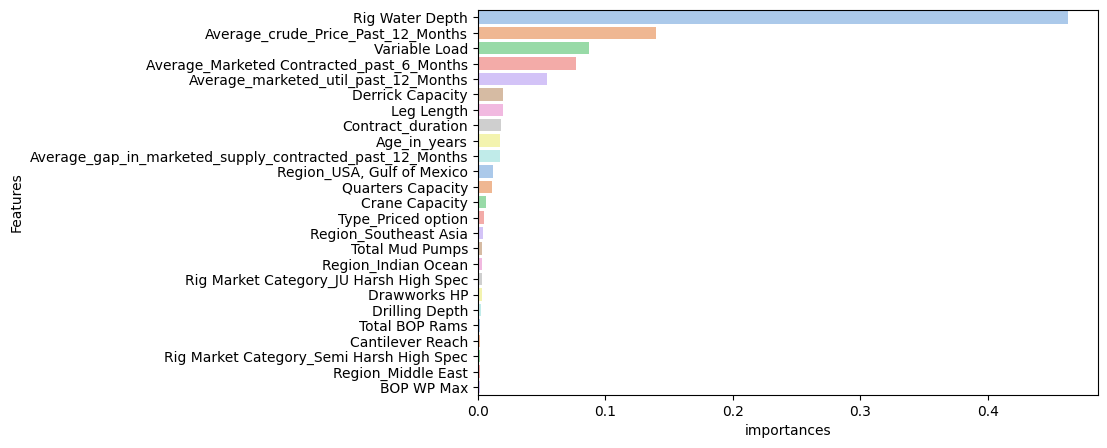

In [420]:
# feature importance for top 25 features
import_ = best_rf.feature_importances_
imp=pd.DataFrame()
imp["Features"] = train_X.columns
imp["importances"]= import_
imp.sort_values("importances", ascending =False, inplace = True)
plt.figure(figsize=(8,5))
colors = sns.color_palette('pastel')
sns.barplot(imp [0:25], x= "importances", y = "Features",  palette=colors) # top 25 features by importance
plt.show()

### HPT of Gradient Boosting model

In [421]:
%%time
# Let's tune the hyperparameters of the Gradient Boosting model to see if we can improve its performance.
parameters = {'n_estimators': [300], # 280, 320
              'max_depth': [7,], # 6,8
              'learning_rate': [0.1, ]} # 0.08, 0.12
grid_search = GridSearchCV(gb_model,
                           parameters,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')

grid_search.fit(train_X,train_y)

CPU times: user 14.2 s, sys: 71.2 ms, total: 14.3 s
Wall time: 1min 1s


GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'n_estimators': [300]},
             scoring='neg_mean_squared_error')

In [422]:
best_gb = grid_search.best_estimator_
best_gb.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [423]:
evaluate_model_metrics(train_X, train_y, "Gradient Boosting HPT", "Train", best_gb)
evaluate_model_metrics(val_X, val_y, "Gradient Boosting HPT", "Val", best_gb)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062
18                XG Boost  Train      98.521  0.008
19                XG Boost    Val      93.717  0.037
20         Neural Networks  Train      89.635  0.058
21         Neural Networks   Test      88.388  0.068
22       Random Forest HPT  Train      98.939  0.006
23       Random Forest HPT    Val      93.266  0.040
24   Gradient Boosting HPT  Train      99.414  0.003
25   Gradient Boosting HPT    Val      94.103  0.035

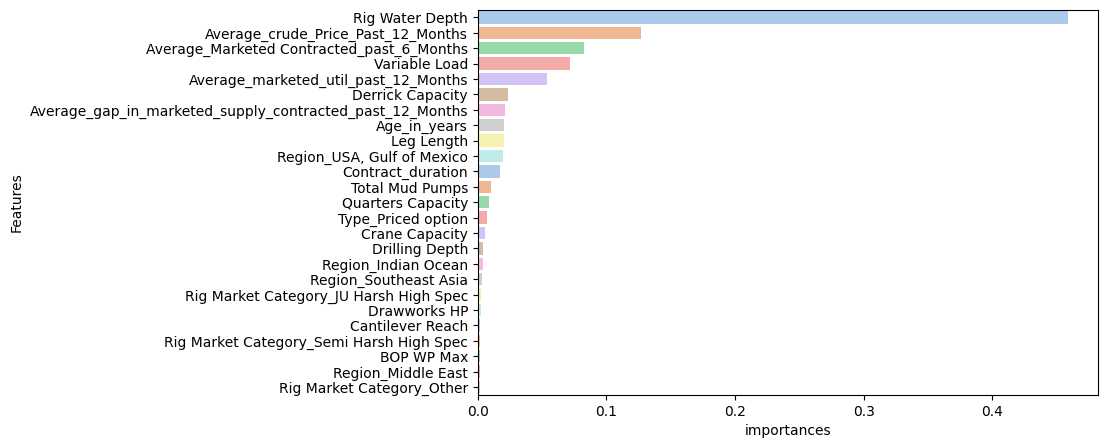

In [424]:
# feature importance for top 25 features
importances = best_gb.feature_importances_
imp=pd.DataFrame()
imp["Features"] = train_X.columns
imp["importances"]= importances
imp.sort_values("importances", ascending =False, inplace = True)
plt.figure(figsize=(8,5))
colors = sns.color_palette('pastel')
sns.barplot(imp[0:25], x= "importances", y = "Features",  palette=colors)
plt.show()

### HPT of XG Boost Model

In [425]:
# Let's tune the hyperparameters of the XG Boosting model to see if we can improve its performance
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'n_estimators': [300], #100, 200,
    'max_depth': [ 7, ], #5,8
    'learning_rate': [ 0.1, ], # 0.01,0.2
    'subsample': [ 0.9], #0.7, 0.8,
    'colsample_bytree': [0.7, ] # 0.8, 0.9
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

# Fit the model
grid_search.fit(train_X_mod,train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [7], 'n_estimators': [300],
                         'subsample': [0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [426]:
# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score (MSE): {-grid_search.best_score_}")

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Best score (MSE): 0.038342320095305436


In [427]:
# Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
# Best score (MSE): 0.03692676801611785

In [428]:
# Get the best estimator
best_xg = grid_search.best_estimator_

In [429]:
evaluate_model_metrics(train_X_mod, train_y, "XG Boost HPT", "Train", best_xg)
evaluate_model_metrics(val_X_mod, val_y, "XG Boost HPT", "Val", best_xg)

Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062
18                XG Boost  Train      98.521  0.008
19                XG Boost    Val      93.717  0.037
20         Neural Networks  Train      89.635  0.058
21         Neural Networks   Test      88.388  0.068
22       Random Forest HPT  Train      98.939  0.006
23       Random Forest HPT    Val      93.266  0.040
24   Gradient Boosting HPT  Train      99.414  0.003
25   Gradient Boosting HPT    Val      94.103  0.035
26            XG Boost HPT  Train      99.336  0.004
27            XG Boost HPT    Val      94.110  0.035

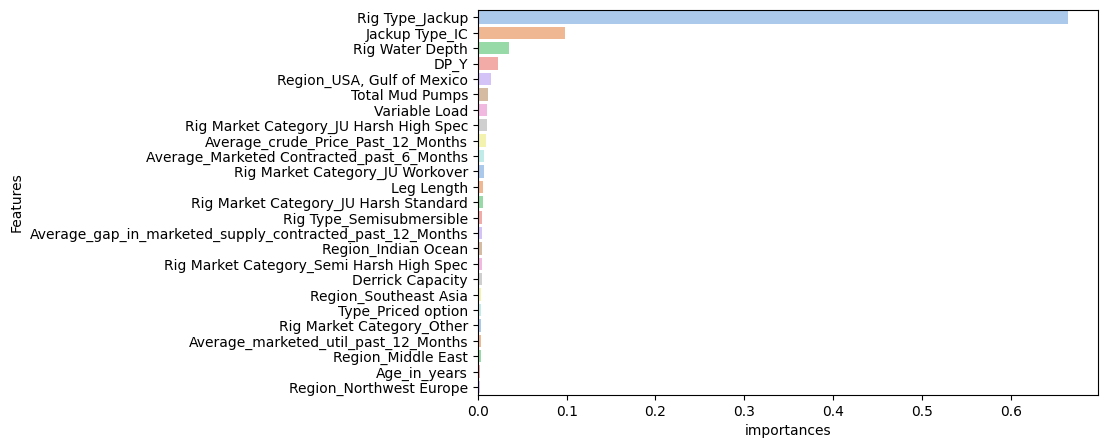

In [430]:
# Get the feature importance scores for top 25 features
importances = best_xg.feature_importances_
imp=pd.DataFrame()
imp["Features"] = train_X_mod.columns
imp["importances"]= importances
imp.sort_values("importances", ascending =False, inplace = True)
plt.figure(figsize=(8,5))
colors = sns.color_palette('pastel')
sns.barplot(imp[0:25], x= "importances", y = "Features",  palette=colors)
plt.show()

### HPT of Neural Networks

In [432]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(94,)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))  # Output layer with single neuron for regression

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss=MeanSquaredError()
    )

    return model

In [433]:
%%time
# Create a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters
tuner.search(train_X_nn, train_y_nn, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, and the optimal dropout rate is {best_hps.get('dropout_1')}.
""")

Trial 10 Complete [00h 00m 46s]
val_loss: 0.10071192681789398

Best val_loss So Far: 0.0902784988284111
Total elapsed time: 00h 08m 57s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512, the optimal learning rate for the optimizer
is 0.0001, and the optimal dropout rate is 0.0.

CPU times: user 6min 53s, sys: 19.7 s, total: 7min 13s
Wall time: 8min 57s


In [434]:
%%time
# Build the model with the optimal hyperparameters and train it
model_hpt_nn = tuner.hypermodel.build(best_hps)
model_hpt_nn.fit(train_X_nn, train_y_nn, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 83.1966 - val_loss: 0.5077
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6931 - val_loss: 0.2554
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5105 - val_loss: 0.2058
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4528 - val_loss: 0.1864
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4373 - val_loss: 0.1754
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4028 - val_loss: 0.1631
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3969 - val_loss: 0.1548
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3725 - val_loss: 0.1520
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3521 - val_loss: 0.1414
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3351 - val_loss: 0.1495
Epoch 11/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3252 - val_loss: 0.1282
Epoch 12/100
155/155 ━━━━━━━━━━━━━━━━━

In [435]:
evaluate_model_metrics(train_X_nn, train_y_nn, "Neural Networks HPT", "Train", model_hpt_nn)
evaluate_model_metrics(test_X_nn, test_y_nn, "Neural Networks HPT", "Test", model_hpt_nn)

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Model Name   Type  R2 Score %    MSE
0        Linear Regression  Train      83.340  0.094
1        Linear Regression    Val      82.546  0.103
2    Linear Regression VIF  Train      80.161  0.112
3    Linear Regression VIF    Val      79.348  0.122
4         Ridge Regression  Train      82.751  0.097
5         Ridge Regression    Val      81.873  0.107
6         Lasso Regression  Train      80.881  0.108
7         Lasso Regression    Val      80.202  0.117
8             Decison Tree  Train      99.915  0.000
9             Decison Tree    Val      87.849  0.072
10           Random Forest  Train      98.955  0.006
11           Random Forest    Val      93.228  0.040
12  Support Vector Machine  Train      91.813  0.046
13  Support Vector Machine    Val      89.735  0.061
14     K-nearest neighbors  Train      89.023  0.062
15     K-nearest neighbors    Val      81.078  0.112
16       Gradient Boosting  Train      90.680  0.052
17       Gradient Boosting    Val      89.540  0.062
18                XG Boost  Train      98.521  0.008
19                XG Boost    Val      93.717  0.037
20         Neural Networks  Train      89.635  0.058
21         Neural Networks   Test      88.388  0.068
22       Random Forest HPT  Train      98.939  0.006
23       Random Forest HPT    Val      93.266  0.040
24   Gradient Boosting HPT  Train      99.414  0.003
25   Gradient Boosting HPT    Val      94.103  0.035
26            XG Boost HPT  Train      99.336  0.004
27            XG Boost HPT    Val      94.110  0.035
28     Neural Networks HPT  Train      87.643  0.070
29     Neural Networks HPT   Test      84.925  0.089

Accuracy from Neural Network is significantly low compared to other Models.

As evident above Gradient Boosting and XG Boost is giving similar max accuracy of around 94.11 % on validation data.

## Ensemble Model


Ensemble models are a powerful technique in machine learning that combine the predictions of multiple models to produce a single, more robust prediction. The idea is to leverage the strengths and mitigate the weaknesses of individual models to improve overall performance. Lets us try to check accuracy using our two higest performing models.

In [436]:
# predictions using Gradient Boosting and XG Boost model after HPT
gb_hpt_predictions = best_gb.predict(val_X)
xgb_hpt_predictions = best_xg.predict(val_X_mod)
# Average predictions
average_predictions = (gb_hpt_predictions + xgb_hpt_predictions) / 2

# Evaluate the model
accuracy = r2_score(val_y, average_predictions)
mse = mean_squared_error(val_y, average_predictions)
print(f'Ensemble model accuracy: {accuracy*100:.3f} %')
print(f'Ensemble model MSE: {mse:.3f}')

Ensemble model accuracy: 94.281 %
Ensemble model MSE: 0.034


# Model Validation

In [437]:
mod_eval = results_df[results_df["Type"] =="Val"]

In [438]:
# Adding a new row manually using append
new_row = pd.DataFrame({'Model Name': ["Ensemble GB+XGB after HPT"], 'Type': ["Val"], 'R2 Score %': [94.287], "MSE": [0.034]})
mod_eval = pd.concat([mod_eval, new_row], ignore_index=True)
mod_eval_sorted = mod_eval.sort_values(by='R2 Score %')

In [439]:
# Creating the bar plot
fig = px.bar(mod_eval_sorted,
             x='R2 Score %',
             y='Model Name',
             orientation='h',
             color='R2 Score %',  # Color by R2 Score %
             color_continuous_scale=px.colors.sequential.Viridis,  # Choose a color scale
             title="Model Performance on Validation Data",
             labels={'R2 Score %': 'R2 Score %', 'Model Name': 'Model Name'},
             text='R2 Score %')

# Show the figure
fig.show()

Ensemble model is offer more accuracy comapred to single XG Boost and Gradient Boosting model after HPT.

# Conclusion after Model Validation

Based on the analysis above, the `Ensembe Model` containing predictions using `Gradient Boosting and XG Boost model after Hyperparamter tunning`  was found to be the most accurate with accuacy  `94.287%` in predicting offshore rig day rates for Validation data. The model's ability to capture complex relationships between features, as well as its relatively low error metrics, suggests that it can be effectively used for forecasting purposes in the offshore drilling industry. Also, features whaving maximum feature importance are Rig Water Depth, Average Crude price over last 12 months, Variable Load, Average Marketed Demand for last 6 months, Derrick Capacity, Age of Rig etc.

Further improvements in model are also being made by continuously updating the model with new data, exploring additional features, and experimenting with more advanced machine learning techniques. Thereafter Model Evaluation on Test data and Detailed Interpretation shall be done. This predictive model can serve as a valuable tool for industry stakeholders to make informed decisions in a highly dynamic market.
